# Incoherent-Excitation in Monomers
## Calculations for the paper: *sanity checks, convergence & analysis*

### Contents:
** Preliminary things: **
- Imports and default parameters
- Convergence checking of overdamped spectral densities with respect to $\omega_0$
- Checking that cheap secular approximation ($i=m, j=n$) is equivalent to full secular approx. ($e_{ij}=e_{mn}$)

**Phonons only:**

- Convergence of RC theory dynamics wrt. N
- Validity of RC theory: comparison to exact solution

**EM bath included:**

- Convergence of full model with respect to N
- Instantaneous decay rates of initial population states to vibronic population states: $\omega_{RC}$ dependence.
- Convergence of steady-states with $\omega_0$
- Instantaneous decay rates of initial population states to vibronic population states: $\alpha_{ph}$ dependence.
- Instantaneous decay rates of initial population states to vibronic population states: $T_{EM}$ dependence.
- Steady-state population of vibronic states: $\alpha_{ph}$ dependence.
- Dynamics of vibronic population states (diagonal density matrix elements)
- Vibronic coherence dynamics: TLS-RC initialised in diagonal population states
- Vibronic coherence transition rates: TLS-RC initialised in off-diagonal states (non-secular transitions)

In [1]:
import time

from qutip import ket, mesolve, qeye, tensor, thermal_dm, destroy, steadystate
import qutip as qt
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi

import UD_liouv as RC
import driving_liouv as EM
import ME_checking as check
import exact_IB as exact
import scipy as sp

import phonon_weak_coupling as WC
from utils import J_overdamped, beta_f, J_underdamped, J_minimal_hard

reload(RC)
reload(EM)
reload(check)
reload(exact)
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25

Things to do in these notes:
- Convergence of RC theory with respect to N for increasing alpha:
    - a) ~~Overdamped~~
    - b) ~~Low and high-frequency under-damped~~
- ~~Are all my overdamped parameters working correctly? Is $w_0 = \epsilon$ sufficient?~~
- ~~I need to check that the exact solution gives me what I want: At which coupling strengths, mode frequencies, temperatures is the RC method valid?~~ ~~How about with underdamped modes?~~
- ~~Look at vibronic/electronic eigenstate populations across windows of validity.~~
- ~~Look at decay rates to various vibronic states when starting in various vibronic states~~
- ~~check steadystate convergence with respect to $\omega_{RC}$ including optical driving at high T.~~
- check dynamics error with respect to $\omega_{RC}$ as well for low and high T.

Thus, does the ambiguity of $\omega_{RC}$ pose a major problem for incoherent excitation? *WHAT IS THE CORRECT APPROACH?!?!*
The non-RWA approach accounts for the fact that the environment plays a part in the transitions between eigenstates and does so in a way which preserves energy conservation, whilst also not discarding terms which are slowly oscillating.

- is it possible to find a variable which determines the validity of the RWA? : inversely proportional to $\alpha_{RC}$ (maybe this is only incidentally important as it's probably the population of the vibronic levels and whether the terms are near resonance).

For 02/02/2018. Write up the story so far:
- The phonon SD sharpness, coupling strength, temperature (and optical temperature) dependence of the validity of the quantum optical approximations.
- The ambiguity of $\omega_{RC}$ for overdamped spectral densities, what this means for vibronic and electronic dynamics. i.e.: electronic behaviour converges with $\omega_{RC}$ much faster than the vibronic for naive and full. **which is the best approach and why?**



In [2]:
# Things that will always be true
G = ket([0])
E = ket([1])
sigma = G*E.dag() # Definition of a sigma_- operator.
J_EM = EM.J_minimal
# Things that are true by default but are subject to overriding
## ~~ Parameters ~~

eps = 0.1*8065.5 # TLS splitting
#eps = 2.*1519.3 # ps
T_EM = 6000. # Optical bath temperature
#H_S = eps*E*E.dag()
#alpha_EM = 0.3 # System-bath strength (optical)
Gamma_EM = 0.1*5.309 #bare decay of electronic transition from inv. ps to in inv. cm
#Gamma_EM = 6.582E-7*1519.3
T_ph = 300. # Phonon bath temperature
overdamped = True
phonon_only = True
#fig1wc = 53.*0.188

''' RC stuff '''
N = 15
#w0 = 200.*0.188
Gamma = 60. # Width of distribution
alpha_ph = 3*eps # Ind.-Boson frame coupling
beta = beta_f(T_ph)#1/(0.695*T_ph)
wc = 1*53. # Ind.-Boson frame phonon cutoff freq
shift = 0.5*np.pi*alpha_ph
w0 = eps+50 #-100 # underdamped SD parameter omega_0
optical_cutoff = 20000.
if overdamped:
        Gamma = (w0**2)/wc
n_RC = EM.Occupation(w0, T_ph)
#initial_sys = G*G.dag()
#initial_sys = E*E.dag()
#initial_sys = 0.5*(G+E)*(E.dag()+G.dag())
initial_sys = 0.5*(E+G)*(E+G).dag()

rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
#print (rho_0*tensor(qeye(2), destroy(N).dag()*destroy(N))).tr()

# Expectation values and time increments needed to calculate the dynamics
expects_wc = [G*G.dag(), E*G.dag()]
expects = [tensor(G*G.dag(), qeye(N)), tensor(E*G.dag(), qeye(N)), 
           tensor(E*E.dag(), qeye(N)), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
           tensor(qeye(2), destroy(N).dag()+destroy(N))]
nTimeSteps = 250
timelist = np.linspace(0, 0.07, nTimeSteps)


## Convergence of spectral densities and dynamics

Firstly, with what values of $\omega_0$ does the overdamped limit of underdamped SD converge?

We need to know what is a suitable value to choose for $\omega_{RC}$ in order for the spectral density to look like a converged  


In [38]:

alpha_ph = 1*eps
nsteps = 1000
w = np.linspace(0., 3*eps, nsteps)
w0_i = 1.2*eps
w0_f = w0_i+2.5*eps
# total error is naturally a function of nsteps
total_error = np.sqrt(sum((J_underdamped(
                    w, 1*eps, w0_i**2/wc, w0_i)-J_overdamped(w, 1*eps, wc)**2)))
print "Average SD error per step: {}".format(total_error/nsteps)

opts = qt.Options(nsteps=5000)

Gamma_i = w0_i**2/wc
L_RC, H_RC, A_EM_, A_nrwa_, wRC_, kappa_, Gamma_1_= RC.RC_function_UD(sigma, eps, T_ph, Gamma_i, w0_i, alpha_ph, N)
DATA_sc_i =  np.array(mesolve(H_RC, rho_0, timelist, [L_RC], expects, progress_bar=True).expect[1])

Gamma_f = w0_f**2/wc
L_RC, H_RC, A_EM_, A_nrwa_, wRC_, kappa_, Gamma_1_= RC.RC_function_UD(sigma, eps, T_ph, Gamma_f, w0_f, alpha_ph, N)
DATA_sc_f =  np.array(mesolve(H_RC, rho_0, timelist, [L_RC], expects, progress_bar=True, options=opts).expect[1])

total_error_dyn = np.sqrt(abs(sum(DATA_sc_i-DATA_sc_f)**2))
print "Average (approx.) error in each timestep: {}".format(total_error_dyn/float(nTimeSteps))

Average SD error per step: 0.0131119193741
w_RC= 967.86  TLS splitting = 806.55 RC-res. coupling= 2.90640949473  N= 15 TLS-RC coupling= 1107.3422158 Gamma_RC=  17674.5845208 alpha_ph= 806.55 beta= 0.00479616306954
10.0%. Run time:   0.56s. Est. time left: 00:00:00:05
20.0%. Run time:   1.22s. Est. time left: 00:00:00:04
30.0%. Run time:   1.84s. Est. time left: 00:00:00:04
40.0%. Run time:   2.45s. Est. time left: 00:00:00:03
50.0%. Run time:   3.05s. Est. time left: 00:00:00:03
60.0%. Run time:   3.69s. Est. time left: 00:00:00:02
70.0%. Run time:   4.30s. Est. time left: 00:00:00:01
80.0%. Run time:   4.89s. Est. time left: 00:00:00:01
90.0%. Run time:   5.51s. Est. time left: 00:00:00:00
Total run time:   6.07s
w_RC= 2984.235  TLS splitting = 806.55 RC-res. coupling= 8.96142927543  N= 15 TLS-RC coupling= 1944.4290286 Gamma_RC=  168031.293117 alpha_ph= 806.55 beta= 0.00479616306954
10.0%. Run time:   6.36s. Est. time left: 00:00:00:57
20.0%. Run time:  11.20s. Est. time left: 00:00:0

THings seem to converge fairly well where $\omega_0>\epsilon$. The greater $\omega_0$ is, the longer the calculations take but (generally) fewer states are needed.

In [39]:
from driving_liouv import Occupation
from qutip import spre, spost, sprepost

def L_full_secular(H_vib, A, eps, Gamma, T, J, time_units='cm', silent=False):
    '''
    Initially assuming that the vibronic eigenstructure has no
    degeneracy and the secular approximation has been made
    '''
    ti = time.time()
    d = H_vib.shape[0]
    L = 0
    eVals, eVecs = H_vib.eigenstates()
    A_dag = A.dag()
    terms = 0
    for l in range(int(d)):
        for m in range(int(d)):
            for p in range(int(d)):
                for q in range(int(d)):
                    secular_freq = (eVals[l]-eVals[m]) - (eVals[p]-eVals[q])
                    if abs(secular_freq) <1E-10:
                        terms+=1
                        A_lm = A.matrix_element(eVecs[l].dag(), eVecs[m])
                        A_lm_star = A_dag.matrix_element(eVecs[m].dag(), eVecs[l])
                        A_pq = A.matrix_element(eVecs[p].dag(), eVecs[q])
                        A_pq_star = A_dag.matrix_element(eVecs[q].dag(), eVecs[p])
                        coeff_1 = A_lm*A_pq_star
                        coeff_2 = A_lm_star*A_pq
                        eps_pq = abs(eVals[p]-eVals[q])
                        Occ = Occupation(eps_pq, T, time_units)
                        r_up = np.pi*J(eps_pq, Gamma, eps)*Occ
                        r_down = np.pi*J(eps_pq, Gamma, eps)*(Occ+1)
                        LM = eVecs[l]*eVecs[m].dag()
                        ML = LM.dag()
                        PQ = eVecs[p]*eVecs[q].dag()
                        QP = PQ.dag()
                        """
                        if abs(secular_freq) !=0:
                            print (abs(secular_freq), r_up, A_lm, A_lm_star, 
                                   A_pq, A_pq_star, r_down, l,m,p,q, m==q, l==p)
                        """
                        if abs(r_up*coeff_1)>0:
                            L+= r_up*coeff_1*(spre(LM*QP)-sprepost(QP,LM))
                        if abs(r_up*coeff_2)>0:
                            L+= r_up*coeff_2*(spost(PQ*ML)- sprepost(ML,PQ))
                        if abs(r_down*coeff_1)>0:
                            L+= r_down*coeff_1*(spre(ML*PQ)-sprepost(PQ, ML))
                        if abs(r_down*coeff_2)>0:
                            L+= r_down*coeff_2*(spost(QP*LM)-sprepost(LM, QP))
    if not silent:
        print "It took ", time.time()-ti, " seconds to build the secular Liouvillian"
        print "Secular approximation kept {:0.2f}% of total ME terms. \n".format(100*float(terms)/(d*d*d*d))
    return -L
w0=eps*0.3
Gamma = (w0**2)/wc
L_RC, H_RC, A_EM_, A_nrwa_, wRC_, kappa_, Gamma_1_= RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, alpha_ph, 10)
L_test1 = L_full_secular(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)
L_test2 = EM.L_vib_lindblad(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)

L_RC, H_RC, A_EM_, A_nrwa_, wRC_, kappa_, Gamma_1_= RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, alpha_ph, 20)
L_test1 = L_full_secular(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)
L_test2 = EM.L_vib_lindblad(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)

L_RC, H_RC, A_EM_, A_nrwa_, wRC_, kappa_, Gamma_1_= RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, alpha_ph, 30)
L_test1 = L_full_secular(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)
L_test2 = EM.L_vib_lindblad(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)

L_RC, H_RC, A_EM_, A_nrwa_, wRC_, kappa_, Gamma_1_= RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, alpha_ph, 40)
L_test1 = L_full_secular(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)
L_test2 = EM.L_vib_lindblad(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)
ss1 = steadystate(H_RC, [L_RC+L_test1]).ptrace(0)
ss2 = steadystate(H_RC, [L_RC+L_test2]).ptrace(0)
print ss1, ss2

w_RC= 241.965  TLS splitting = 806.55 RC-res. coupling= 0.726602373684  N= 10 TLS-RC coupling= 553.6711079 Gamma_RC=  1104.66153255 alpha_ph= 806.55 beta= 0.00479616306954
It took  1.44351196289  seconds to build the secular Liouvillian
Secular approximation kept 0.79% of total ME terms. 

It took  0.362482070923  seconds to build the vibronic Lindblad Liouvillian
w_RC= 241.965  TLS splitting = 806.55 RC-res. coupling= 0.726602373684  N= 20 TLS-RC coupling= 553.6711079 Gamma_RC=  1104.66153255 alpha_ph= 806.55 beta= 0.00479616306954
It took  10.4186332226  seconds to build the secular Liouvillian
Secular approximation kept 0.30% of total ME terms. 

It took  2.87113809586  seconds to build the vibronic Lindblad Liouvillian
w_RC= 241.965  TLS splitting = 806.55 RC-res. coupling= 0.726602373684  N= 30 TLS-RC coupling= 553.6711079 Gamma_RC=  1104.66153255 alpha_ph= 806.55 beta= 0.00479616306954
It took  44.1546599865  seconds to build the secular Liouvillian
Secular approximation kept 0.1

**So we can see that** the two approaches give the same results. This is because the terms which are discarded when there are resonances (but $l\neq p$ and $m\neq q$) are forbidden due to the symmetry of the system operator and the vibronic Hamiltonian. This occurs when the terms describe EM-field-induced transitions between vibronic states on the same manifold, which are forbidden. We can also see that the more complete version takes considerably longer, however, with higher N, proportionally fewer terms are kept after the secular approximation.

## Convergence of RC theory dynamics (wrt N)
For some fairly strong coupling, when do the calculations stop changing appreciably with increasing N?

In [40]:
wc

53.0

alpha prop: 1, w0 prop: 0.619924369227, eps: 806.55
N=17: converged to 	 ** Error:  1.78340730955e-10  ** Took: 0.781317949295s**


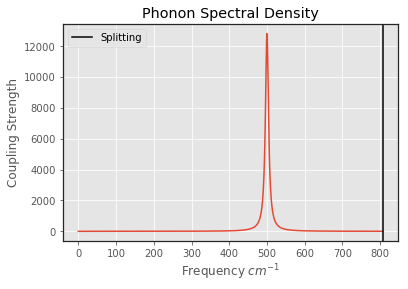

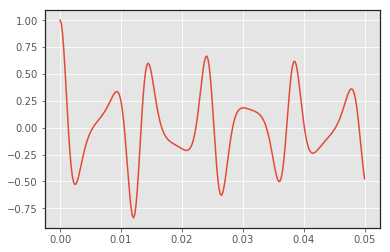

alpha prop: 1.0, w0 prop: 0.0714285714286, eps: 806.55
N=27: converged to 	 ** Error:  9.95609675679e-08  ** Took: 2.66342401505s**


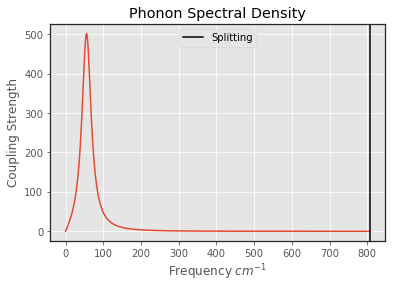

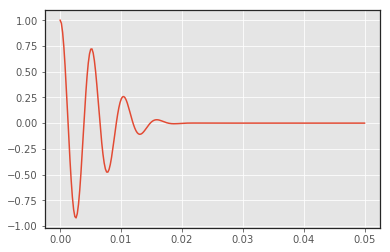

alpha prop: 1.0, w0 prop: 0.5, eps: 806.55
N=16: converged to 	 ** Error:  1.85087878933e-08  ** Took: 0.617725133896s**


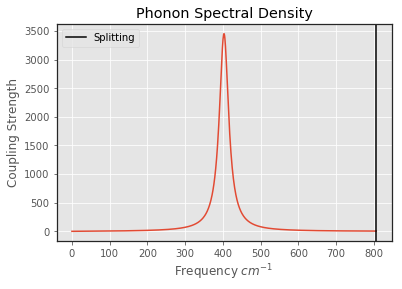

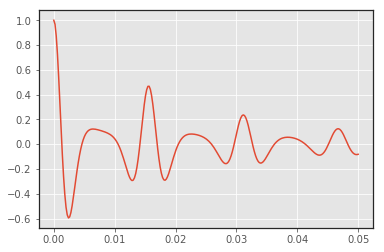

alpha prop: 1.0, w0 prop: 1.0, eps: 806.55
N=17: converged to 	 ** Error:  2.0145699972e-08  ** Took: 5.35821080208s**


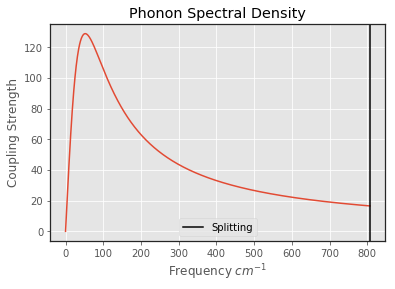

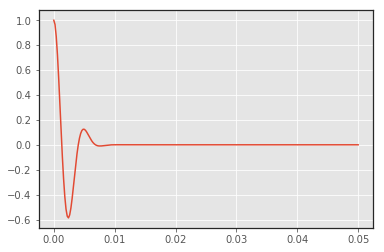

alpha prop: 1.0, w0 prop: 1.5, eps: 806.55
N=16: converged to 	 ** Error:  3.17467238573e-08  ** Took: 7.95057988167s**


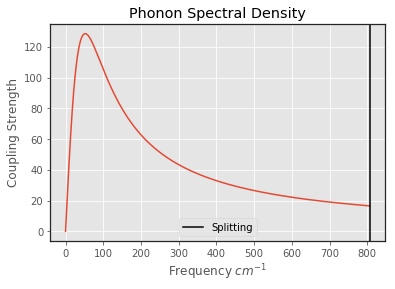

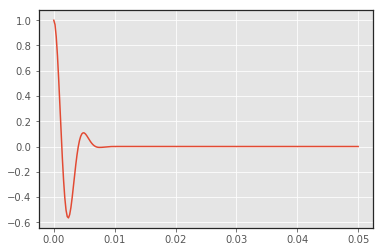

alpha prop: 1, w0 prop: 0.1, eps: 806.55
N=22: converged to 	 ** Error:  7.51508161531e-08  ** Took: 1.69845986366s**


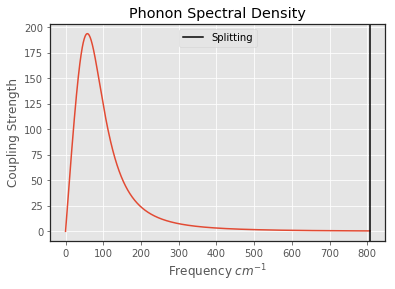

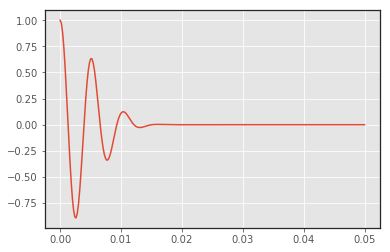

In [10]:

def integers(ni = 2, step=1):
    i = ni
    while True:
        i+=step
        yield i

eps = 0.1*8065.5

def convergence_checker(alpha_prop, w0_prop, Gamma_, overdamped=False, threshold=10E-8):
    nTimeSteps = 250
    timelist = np.linspace(0, 0.05, nTimeSteps)
    N_gen = integers()
    last_rc_sol = np.array([1])
    current_rc_sol = np.array([3])
    alpha_ph = eps*alpha_prop/np.pi
    w0 = eps*w0_prop
    if overdamped:
        Gamma_ = (w0**2)/wc
    w = np.linspace(0., eps, 1000)
    plt.figure()
    plt.plot(w, J_underdamped(w, alpha_ph, Gamma_, w0))
    plt.axvline(eps, label='Splitting',color='k')
    plt.ylabel("Coupling Strength")
    plt.xlabel(r"Frequency $cm^{-1}$")
    plt.title("Phonon Spectral Density")
    plt.legend()
    print "alpha prop: {}, w0 prop: {}, eps: {}". format(alpha_prop, w0_prop, eps)
    while sum(abs(last_rc_sol - current_rc_sol)**2) >threshold:
        
        N = N_gen.next()
        rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
        #print (rho_0*tensor(qeye(2), destroy(N).dag()*destroy(N))).tr()

        # Expectation values and time increments needed to calculate the dynamics
        expects_wc = [G*G.dag(), E*G.dag()]
        
        expects = [tensor(G*G.dag(), qeye(N)), tensor(E*G.dag()+G*E.dag(), qeye(N)), 
               tensor(E*E.dag(), qeye(N)), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
               tensor(qeye(2), destroy(N).dag()+destroy(N))]
        ti = time.time()
        L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma_1= RC.RC_function_UD(
                                                    sigma, eps, T_ph, Gamma_, 
                                                    w0, alpha_ph, N, silent=True)
        DATA_sc =  np.array(mesolve(H_RC, rho_0, timelist, [L_RC], expects).expect[1])
        tf = time.time()
        last_rc_sol = np.array(current_rc_sol)
        current_rc_sol =  DATA_sc
    print 'N={}: converged to \t ** Error: '.format(N), sum(abs(
            last_rc_sol - current_rc_sol)**2), " ** Took: {}s**".format(tf-ti)
    plt.figure()
    plt.plot(timelist, DATA_sc)
    plt.show()
convergence_checker(1, 500./eps, 10., overdamped=False, threshold=10E-10)
convergence_checker(1., 1./14., 30., threshold=10E-8)
convergence_checker(1., 1./2, 30., threshold=10E-8)

convergence_checker(1., 1., 0, overdamped=True, threshold=10E-8)
convergence_checker(1., 1.5, 0, overdamped=True, threshold=10E-8)
convergence_checker(1, 0.1, 10., overdamped=True, threshold=10E-8)

Underdamped:
- $\alpha=\epsilon$, $\omega_0=\epsilon/14, \Gamma=30cm^{-1}$ : converges at N=27 in 2.73s
- $\alpha=\epsilon$, $\omega_0=\epsilon/2, \Gamma=30cm^{-1}$ : converges at N=23 in 2.40s

Overdamped:
- $\alpha=\epsilon$, $\omega_0=1.5\epsilon, \Gamma=12274cm^{-1}$ : converges at N=16 in 6.6s
- $\alpha=\epsilon$, $\omega_0=2\epsilon, \Gamma=27617cm^{-1}$ : converges at N=15 in 9.17s

where $\Gamma$ is the width of the Lorentzian spectral density.

## Comparison to exact solution

How well does the RC theory agree with exact?
- w_0 dependence
- alpha dependence

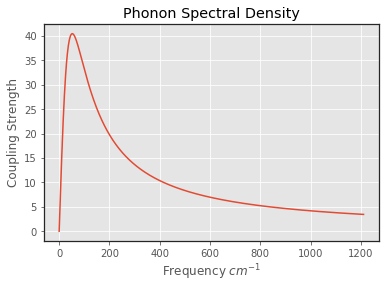

T_ph=30.0
w_RC= 887.205  TLS splitting = 806.55 RC-res. coupling= 2.71544348627  N= 15 TLS-RC coupling= 133.751186233 Gamma_RC=  15137.1675389 alpha_ph= 12.8366419351 beta= 0.0479616306954
eps: 806.55, alpha: 12.8366419351, w0: 887.205, Gamma: 15137.1675389, beta: 0.0479616306954
Exact solution 57.143 percent finished
Exact solution took 21.6539390087 to calculate.


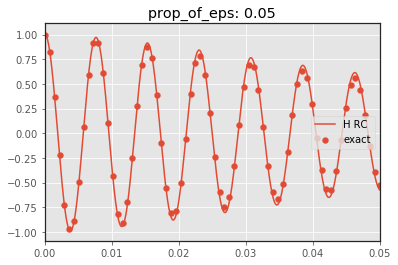

T_ph=30.0
w_RC= 887.205  TLS splitting = 806.55 RC-res. coupling= 2.71544348627  N= 15 TLS-RC coupling= 313.674335901 Gamma_RC=  15137.1675389 alpha_ph= 70.6015306429 beta= 0.0479616306954
eps: 806.55, alpha: 70.6015306429, w0: 887.205, Gamma: 15137.1675389, beta: 0.0479616306954
Exact solution 57.143 percent finished
Exact solution took 43.982175827 to calculate.


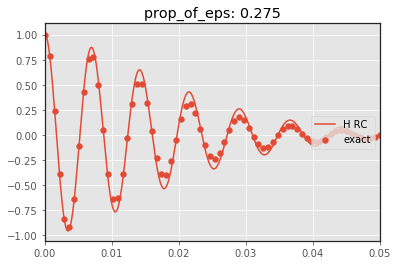

T_ph=30.0
w_RC= 887.205  TLS splitting = 806.55 RC-res. coupling= 2.71544348627  N= 15 TLS-RC coupling= 422.958388246 Gamma_RC=  15137.1675389 alpha_ph= 128.366419351 beta= 0.0479616306954
eps: 806.55, alpha: 128.366419351, w0: 887.205, Gamma: 15137.1675389, beta: 0.0479616306954
Exact solution 57.143 percent finished
Exact solution took 56.1151089668 to calculate.


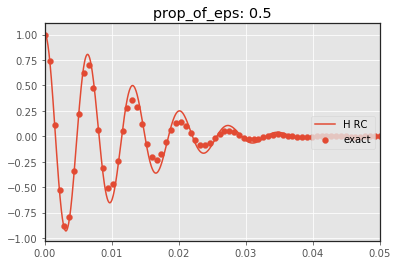

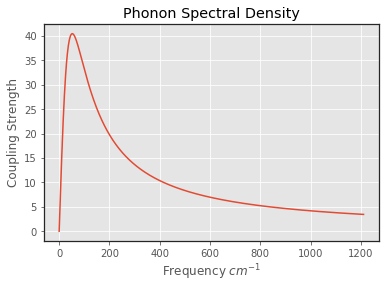

T_ph=300.0
w_RC= 887.205  TLS splitting = 806.55 RC-res. coupling= 2.71544348627  N= 15 TLS-RC coupling= 133.751186233 Gamma_RC=  15137.1675389 alpha_ph= 12.8366419351 beta= 0.00479616306954
eps: 806.55, alpha: 12.8366419351, w0: 887.205, Gamma: 15137.1675389, beta: 0.00479616306954
Exact solution 57.143 percent finished
Exact solution took 45.6962599754 to calculate.


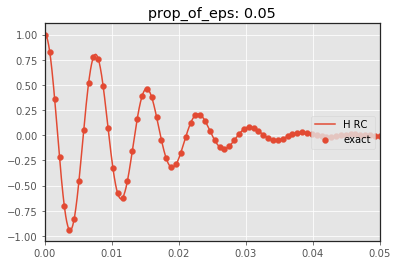

T_ph=300.0
w_RC= 887.205  TLS splitting = 806.55 RC-res. coupling= 2.71544348627  N= 15 TLS-RC coupling= 433.40337804 Gamma_RC=  15137.1675389 alpha_ph= 134.784740318 beta= 0.00479616306954
eps: 806.55, alpha: 134.784740318, w0: 887.205, Gamma: 15137.1675389, beta: 0.00479616306954
Exact solution 57.143 percent finished
Exact solution took 72.5484809875 to calculate.


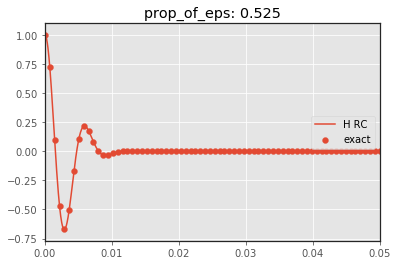

T_ph=300.0
w_RC= 887.205  TLS splitting = 806.55 RC-res. coupling= 2.71544348627  N= 15 TLS-RC coupling= 598.153488977 Gamma_RC=  15137.1675389 alpha_ph= 256.732838702 beta= 0.00479616306954
eps: 806.55, alpha: 256.732838702, w0: 887.205, Gamma: 15137.1675389, beta: 0.00479616306954
Exact solution 57.143 percent finished
Exact solution took 77.4660799503 to calculate.


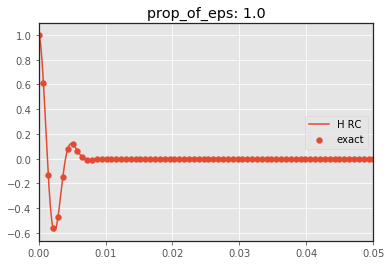

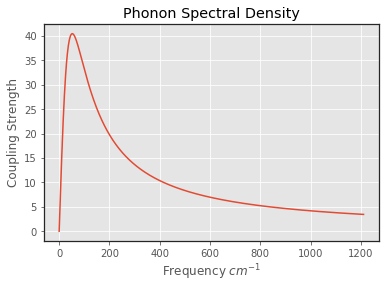

T_ph=80.0
w_RC= 887.205  TLS splitting = 806.55 RC-res. coupling= 2.71544348627  N= 25 TLS-RC coupling= 133.751186233 Gamma_RC=  15137.1675389 alpha_ph= 12.8366419351 beta= 0.0179856115108
eps: 806.55, alpha: 12.8366419351, w0: 887.205, Gamma: 15137.1675389, beta: 0.0179856115108
Exact solution 57.143 percent finished
Exact solution took 34.6186680794 to calculate.


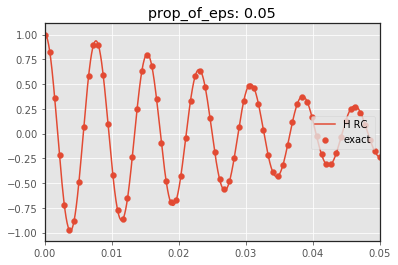

T_ph=80.0
w_RC= 887.205  TLS splitting = 806.55 RC-res. coupling= 2.71544348627  N= 25 TLS-RC coupling= 433.40337804 Gamma_RC=  15137.1675389 alpha_ph= 134.784740318 beta= 0.0179856115108
eps: 806.55, alpha: 134.784740318, w0: 887.205, Gamma: 15137.1675389, beta: 0.0179856115108
Exact solution 57.143 percent finished
Exact solution took 57.6825051308 to calculate.


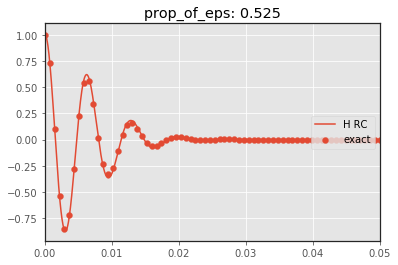

T_ph=80.0
w_RC= 887.205  TLS splitting = 806.55 RC-res. coupling= 2.71544348627  N= 25 TLS-RC coupling= 598.153488977 Gamma_RC=  15137.1675389 alpha_ph= 256.732838702 beta= 0.0179856115108
eps: 806.55, alpha: 256.732838702, w0: 887.205, Gamma: 15137.1675389, beta: 0.0179856115108
Exact solution 57.143 percent finished
Exact solution took 69.8443129063 to calculate.


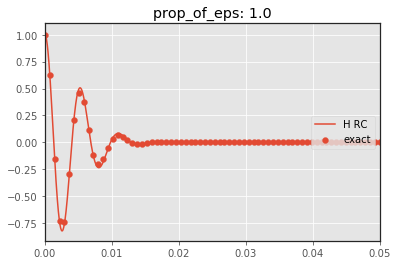

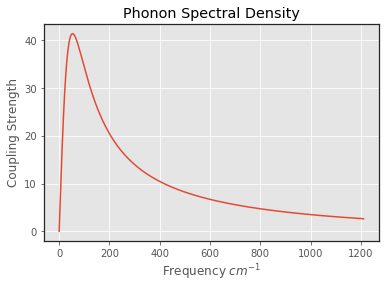

T_ph=300.0
w_RC= 322.62  TLS splitting = 806.55 RC-res. coupling= 0.987433995006  N= 28 TLS-RC coupling= 80.655 Gamma_RC=  2001.60893077 alpha_ph= 12.8366419351 beta= 0.00479616306954
eps: 806.55, alpha: 12.8366419351, w0: 322.62, Gamma: 2001.60893077, beta: 0.00479616306954
Exact solution 57.143 percent finished
Exact solution took 30.8012471199 to calculate.


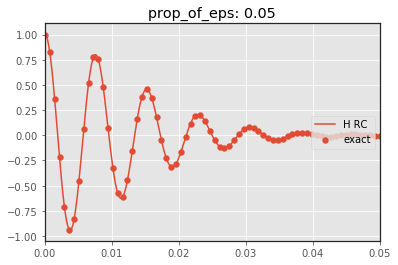

T_ph=300.0
w_RC= 322.62  TLS splitting = 806.55 RC-res. coupling= 0.987433995006  N= 28 TLS-RC coupling= 261.352070515 Gamma_RC=  2001.60893077 alpha_ph= 134.784740318 beta= 0.00479616306954
eps: 806.55, alpha: 134.784740318, w0: 322.62, Gamma: 2001.60893077, beta: 0.00479616306954
Exact solution 57.143 percent finished
Exact solution took 45.4999370575 to calculate.


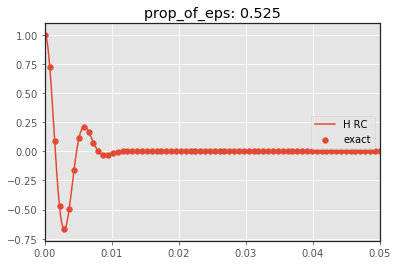

T_ph=300.0
w_RC= 322.62  TLS splitting = 806.55 RC-res. coupling= 0.987433995006  N= 28 TLS-RC coupling= 360.70012545 Gamma_RC=  2001.60893077 alpha_ph= 256.732838702 beta= 0.00479616306954
eps: 806.55, alpha: 256.732838702, w0: 322.62, Gamma: 2001.60893077, beta: 0.00479616306954
Exact solution 57.143 percent finished
Exact solution took 64.6587760448 to calculate.


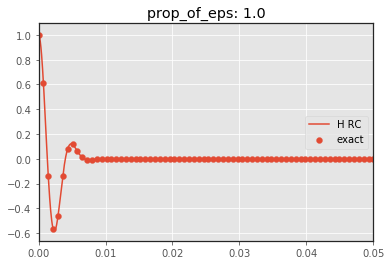

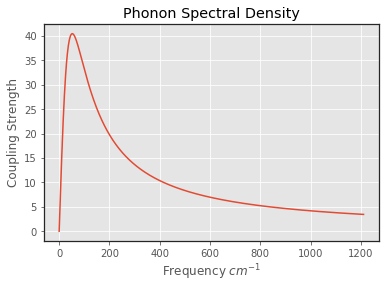

T_ph=1000.0
w_RC= 887.205  TLS splitting = 806.55 RC-res. coupling= 2.71544348627  N= 26 TLS-RC coupling= 133.751186233 Gamma_RC=  15137.1675389 alpha_ph= 12.8366419351 beta= 0.00143884892086
eps: 806.55, alpha: 12.8366419351, w0: 887.205, Gamma: 15137.1675389, beta: 0.00143884892086
Exact solution 57.143 percent finished
Exact solution took 41.5432770252 to calculate.


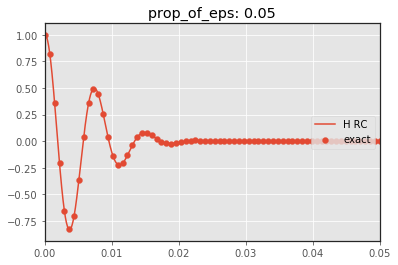

T_ph=1000.0
w_RC= 887.205  TLS splitting = 806.55 RC-res. coupling= 2.71544348627  N= 26 TLS-RC coupling= 433.40337804 Gamma_RC=  15137.1675389 alpha_ph= 134.784740318 beta= 0.00143884892086
eps: 806.55, alpha: 134.784740318, w0: 887.205, Gamma: 15137.1675389, beta: 0.00143884892086


KeyboardInterrupt: 

In [29]:
reload(RC)
reload(EM)
reload(check)
reload(exact)

w0 = 0.4*500
Gamma = (w0**2)/53.
#exact.plot_integrand(beta_f(300), 50., Gamma, w0)

def exact_comparison_alpha(eps, w0_prop, Gamma_, N=3, overdamped=False, T_ph=300., upper_alpha=1.):
    timelist_exact = np.linspace(0, 0.05, 70)
    timelist = np.linspace(0, 0.05, 1000)
    w0 = eps*w0_prop
    n_RC = EM.Occupation(w0, T_ph)
    if overdamped:
        Gamma_ = (w0**2)/wc
    w = np.linspace(0., eps*1.5, 1000)
    plt.figure()
    alpha_ph = 0.1*eps
    plt.plot(w, J_underdamped(w, alpha_ph, Gamma_, w0))
    plt.ylabel("Coupling Strength")
    plt.xlabel(r"Frequency $cm^{-1}$")
    plt.title("Phonon Spectral Density")
    plt.legend()
    plt.show()
    
    exact_sol = []
    rc_sol = []
    prop_of_eps = np.linspace(0.05, upper_alpha, 3)
    for prop in prop_of_eps:
        # how well
        alpha = prop*eps/pi
        beta = beta_f(T_ph)#1/(0.695*T_ph)
        ti = time.time()
        
        print "T_ph={}".format(T_ph)
        #print "Exact solution took {} seconds.".format(time.time()-ti)
        expects = [tensor(G*G.dag(), qeye(N)), tensor(E*G.dag()+G*E.dag(), qeye(N)), 
               tensor(E*E.dag(), qeye(N)), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
               tensor(qeye(2), destroy(N).dag()+destroy(N))]
        rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
        #DATA_wc = mesolve(H_S, initial_sys, timelist, [L_wc], expects_wc, progress_bar=True)
        L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma= RC.RC_function_UD(sigma, eps, 
                                                                       T_ph, Gamma_, 
                                                                       w0, alpha, N)
        #print H_RC.eigenenergies()
        #print eps-0.5*np.pi*alpha, eps+w0, eps-0.5*np.pi*alpha+w0
        try:
            DATA_sc = mesolve(H_RC, rho_0, timelist, [L_RC], 
                              expects, options=qt.Options(nsteps=1000)).expect[1].real
        except:
            DATA_sc = mesolve(H_RC, rho_0, timelist, [L_RC], 
                              expects, options=qt.Options(nsteps=15000)).expect[1].real
        rho_01 = np.array(exact.exact_dynamics(eps, alpha, wc, 
                                               w0, Gamma_, beta, initial_sys, 
                                               timelist_exact, overdamped=overdamped))
        #exact_sol.append(rho_01.real)
        #rc_sol.append(DATA_sc.real)
        plt.figure()
        plt.title("prop_of_eps: {}".format(prop))
        plt.scatter(timelist_exact, rho_01, label="exact", linewidth='0.3')
        plt.plot(timelist, DATA_sc, label="H RC")
        plt.xlim(0,timelist[-1])
        # Everything is oscillating at the shifted frequency
        #plt.plot(timelist, 0.5*np.exp((-50.-1j*(eps-shift))*timelist)) 
        sigmaX_values = [[], []]
        with open("DATA/alpha_epsilon_underdamped.dat", "r") as f:
            data = f.read()
            for row in data.split('\n'):
                row = row.split('\t')
                sigmaX_values[0].append(row[0])
                sigmaX_values[1].append(row[1])
        #plt.plot(sigmaX_values[0], sigmaX_values[1], label='Ahsan RC')
        plt.legend(loc='right')
        plt.show()

eps= 0.1*8065.5
exact_comparison_alpha(eps, 1.1, 0, N=15,T_ph=30., overdamped=True, upper_alpha=0.5)
exact_comparison_alpha(eps, 1.1, 0, N=15, overdamped=True)
exact_comparison_alpha(eps, 1.1, 0, N=25,T_ph=80., overdamped=True)
exact_comparison_alpha(eps, 0.4, 0, N=28,T_ph=300., overdamped=True)
exact_comparison_alpha(eps, 1.1, 0, N=26,T_ph=1000., overdamped=True)



UNDERDAMPED SDs


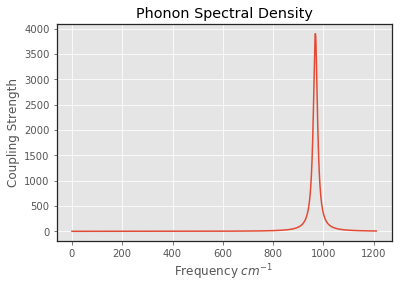

T_ph=300.0
w_RC= 967.86  TLS splitting = 806.55 RC-res. coupling= 0.00328880092352  N= 25 TLS-RC coupling= 139.698557884 Gamma_RC=  20 alpha_ph= 12.8366419351 beta= 0.00479616306954
eps: 806.55, alpha: 12.8366419351, w0: 967.86, Gamma: 20, beta: 0.00479616306954
Exact solution 57.143 percent finished
Exact solution took 29.3668971062 to calculate.


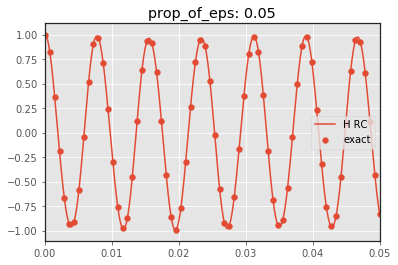

T_ph=300.0
w_RC= 967.86  TLS splitting = 806.55 RC-res. coupling= 0.00328880092352  N= 25 TLS-RC coupling= 452.675064795 Gamma_RC=  20 alpha_ph= 134.784740318 beta= 0.00479616306954
eps: 806.55, alpha: 134.784740318, w0: 967.86, Gamma: 20, beta: 0.00479616306954
Exact solution 57.143 percent finished
Exact solution took 42.0425100327 to calculate.


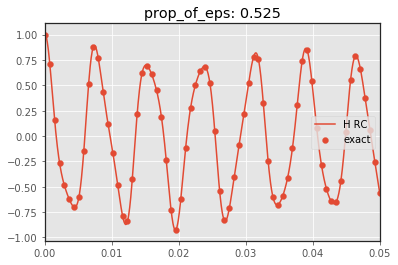

T_ph=300.0
w_RC= 967.86  TLS splitting = 806.55 RC-res. coupling= 0.00328880092352  N= 25 TLS-RC coupling= 624.750943577 Gamma_RC=  20 alpha_ph= 256.732838702 beta= 0.00479616306954
eps: 806.55, alpha: 256.732838702, w0: 967.86, Gamma: 20, beta: 0.00479616306954
Exact solution 57.143 percent finished
Exact solution took 42.6923639774 to calculate.


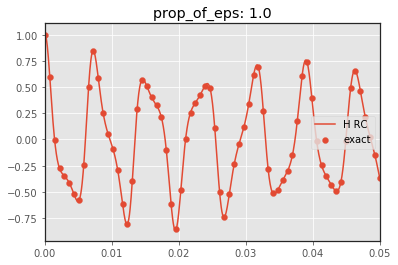

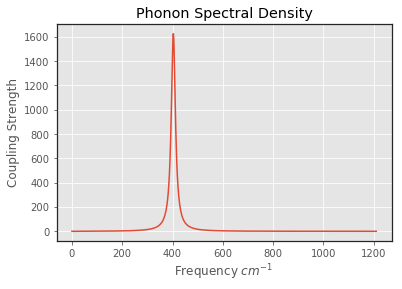

T_ph=300.0
w_RC= 403.275  TLS splitting = 806.55 RC-res. coupling= 0.00789312221645  N= 25 TLS-RC coupling= 90.1750313626 Gamma_RC=  20 alpha_ph= 12.8366419351 beta= 0.00479616306954
eps: 806.55, alpha: 12.8366419351, w0: 403.275, Gamma: 20, beta: 0.00479616306954
Exact solution 57.143 percent finished
Exact solution took 14.6072218418 to calculate.


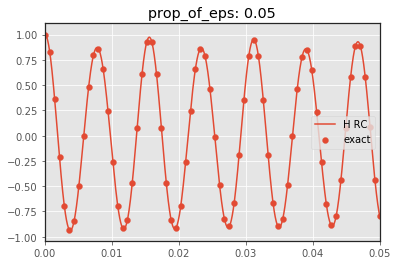

T_ph=300.0
w_RC= 403.275  TLS splitting = 806.55 RC-res. coupling= 0.00789312221645  N= 25 TLS-RC coupling= 292.200497866 Gamma_RC=  20 alpha_ph= 134.784740318 beta= 0.00479616306954
eps: 806.55, alpha: 134.784740318, w0: 403.275, Gamma: 20, beta: 0.00479616306954
Exact solution 57.143 percent finished
Exact solution took 31.1704580784 to calculate.


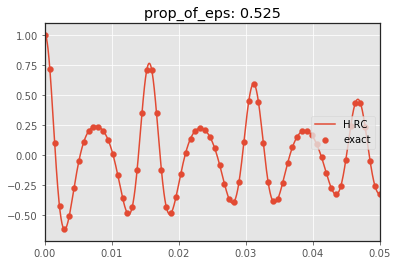

T_ph=300.0
w_RC= 403.275  TLS splitting = 806.55 RC-res. coupling= 0.00789312221645  N= 25 TLS-RC coupling= 403.275 Gamma_RC=  20 alpha_ph= 256.732838702 beta= 0.00479616306954
eps: 806.55, alpha: 256.732838702, w0: 403.275, Gamma: 20, beta: 0.00479616306954
Exact solution 57.143 percent finished
Exact solution took 27.8523929119 to calculate.


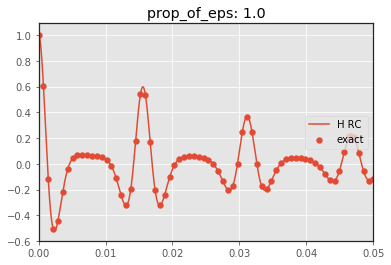

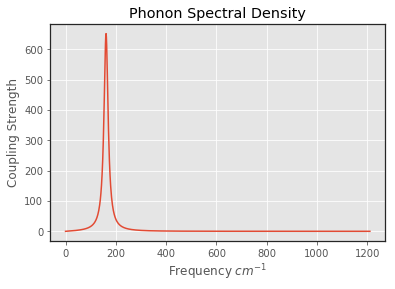

T_ph=300.0
w_RC= 161.31  TLS splitting = 806.55 RC-res. coupling= 0.0197328055411  N= 27 TLS-RC coupling= 57.0316974366 Gamma_RC=  20 alpha_ph= 12.8366419351 beta= 0.00479616306954
eps: 806.55, alpha: 12.8366419351, w0: 161.31, Gamma: 20, beta: 0.00479616306954
Exact solution 57.143 percent finished
Exact solution took 12.9920699596 to calculate.


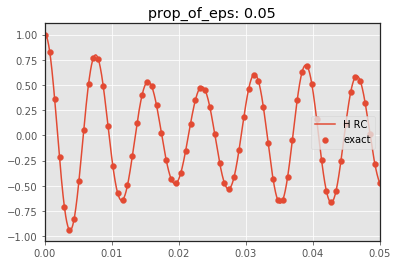

T_ph=300.0
w_RC= 161.31  TLS splitting = 806.55 RC-res. coupling= 0.0197328055411  N= 27 TLS-RC coupling= 184.803821338 Gamma_RC=  20 alpha_ph= 134.784740318 beta= 0.00479616306954
eps: 806.55, alpha: 134.784740318, w0: 161.31, Gamma: 20, beta: 0.00479616306954


KeyboardInterrupt: 

In [30]:
print "UNDERDAMPED SDs"
#exact_comparison_alpha(eps, 0.4, ((0.4*eps)**2)/wc, N=25,T_ph=300., overdamped=False)
exact_comparison_alpha(eps, 1.2, 20, N=25, overdamped=False)
exact_comparison_alpha(eps, 1./2., 20, N=25, overdamped=False)
exact_comparison_alpha(eps, 1./5., 20, N=27, overdamped=False)
exact_comparison_alpha(eps, 1./20., 20, N=33, overdamped=False, upper_alpha=2.)
#exact_comparison_alpha(eps, 1., 10., N=33, overdamped=False, upper_alpha=2.)

So we can see that for broad overdamped environments the RC method works extremely well in all of the above regimes: including strongly coupled underdamped modes. The only time it really fails is with strongly-coupled, low-temperature environments.

In [ ]:
exact_comparison_alpha(eps, 53./eps, 53., N=26,T_ph=300., overdamped=False, upper_alpha=2.)
exact_comparison_alpha(eps, 53./eps, 0, N=26,T_ph=300., overdamped=True, upper_alpha=2.)


## Convergence of optical driving code: wrt N

Now we will check steadystate convergence with respect to N including optical driving.

In [44]:
w0 = eps*1.1
wc = 52.
Gamma = (w0**2)/wc

def driving_convergence_N(alpha_prop, w0_prop, Gamma_, T_EM=6000., overdamped=False):
    e0_population = [[],[],[]]
    g1_population = [[],[],[]]
    labels = ['nrwa', 'non-sec', 'naive']
    alpha_ph = eps*alpha_prop
    shift = 0.5*np.pi*alpha_ph
    w0 = eps*w0_prop
    if overdamped:
        Gamma_ = (w0**2)/wc
    #w = np.linspace(0., eps, 1000)
    #plt.figure()
    #plt.plot(w, J_underdamped(w, alpha_ph, Gamma_, w0))
    #plt.axvline(eps-shift, label='Splitting',color='k')
    #plt.ylabel("Coupling Strength")
    #plt.xlabel(r"Frequency $cm^{-1}$")
    #plt.title("Phonon Spectral Density")
    #plt.legend()
    #plt.show()
    n_RC = EM.Occupation(w0, T_ph)
    N_values = range(3,23)
    for n in N_values:
        rho_0 = tensor(initial_sys, thermal_dm(n, n_RC))
        #print (rho_0*tensor(qeye(2), destroy(N).dag()*destroy(N))).tr()

        # Expectation values and time increments needed to calculate the dynamics
        expects = [tensor(G*G.dag(), qeye(n)), tensor(E*G.dag(), qeye(n)), 
               tensor(E*E.dag(), qeye(n)), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
               tensor(qeye(2), destroy(n).dag()+destroy(n))]
        ti = time.time()
        L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma_1= RC.RC_function_UD(
                                                    sigma, eps, T_ph, Gamma_, 
                                                    w0, alpha_ph, n, silent=True)
        evals, states = H_RC.eigenstates()
        
        L= [EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM, silent=True), 
            EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J_EM, silent=True),
            EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J=J_EM, silent=True)]
        
        for j, L_EM in enumerate(L):
            state = states[1]
            e0_population[j].append(steadystate(H_RC, [L_RC+L_EM]).matrix_element(
                                                                state.dag(), state))
            state = states[2]
            g1_population[j].append(steadystate(H_RC, [L_RC+L_EM]).matrix_element(
                                                                state.dag(), state))
        tf = time.time()
        if n%5==0:
            print " ** Steady states took: {}s. {}% finished**".format(tf-ti, 100*n/float(len(N_values)))
    plt.figure()
    for i in range(len(e0_population)):
        plt.ylabel('e-0 population')
        plt.xlabel('N')
        plt.plot(N_values, e0_population[i], label=labels[i])
        plt.legend()
    plt.figure()
    for i in range(len(g1_population)):
        plt.ylabel('g-1 population')
        plt.xlabel('N')
        plt.plot(N_values, g1_population[i], label=labels[i])
        plt.legend()
    plt.show()


Low frequency underdamped
 ** Steady states took: 0.971544981003s. 25.0% finished**
 ** Steady states took: 1.31808805466s. 50.0% finished**
 ** Steady states took: 1.98672509193s. 75.0% finished**
 ** Steady states took: 3.77307415009s. 100.0% finished**


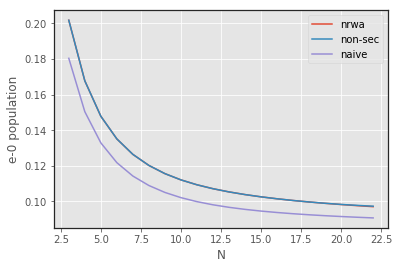

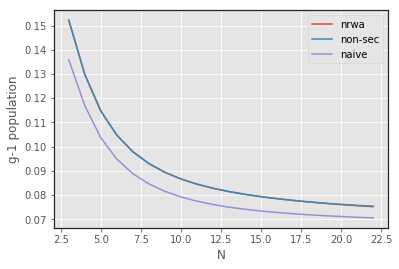

medium frequency underdamped
 ** Steady states took: 0.25606584549s. 25.0% finished**
 ** Steady states took: 0.878252029419s. 50.0% finished**
 ** Steady states took: 1.94690084457s. 75.0% finished**
 ** Steady states took: 6.08903694153s. 100.0% finished**


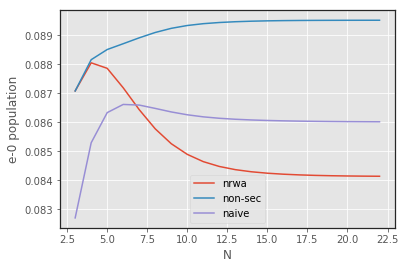

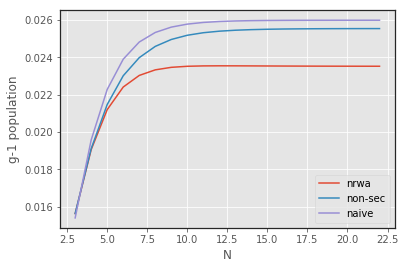

Overdamped: $\omega_0=\epsilon$
 ** Steady states took: 0.320301055908s. 25.0% finished**
 ** Steady states took: 0.85133600235s. 50.0% finished**
 ** Steady states took: 2.64687609673s. 75.0% finished**
 ** Steady states took: 5.11688899994s. 100.0% finished**


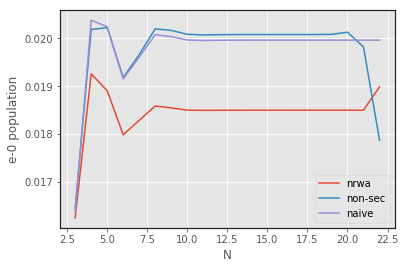

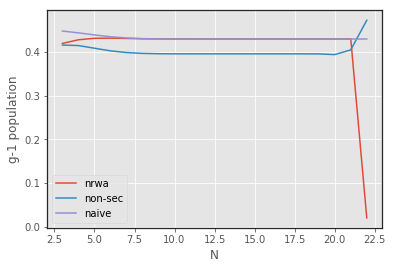

Overdamped: $\omega_0=1.5\epsilon$
 ** Steady states took: 0.242336988449s. 25.0% finished**
 ** Steady states took: 1.21051692963s. 50.0% finished**
 ** Steady states took: 1.9255168438s. 75.0% finished**
 ** Steady states took: 5.18718099594s. 100.0% finished**


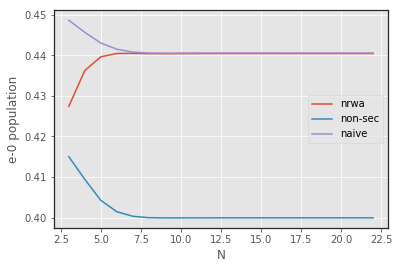

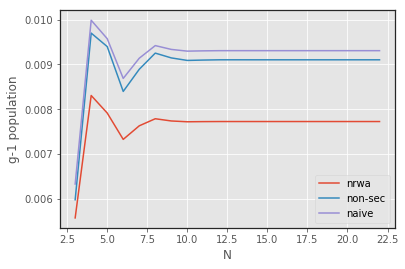

In [46]:
print "Low frequency underdamped"
driving_convergence_N(1., 1./14., 30.)
print "medium frequency underdamped"
driving_convergence_N(1., 1./2, 30.)
print "Overdamped: $\omega_0=\epsilon$"
driving_convergence_N(1., 1., 0, overdamped=True)
print "Overdamped: $\omega_0=1.5\epsilon$"
driving_convergence_N(1., 1.5, 0, overdamped=True)

Above, we can see that the overdamped steadystates are very unstable when $\omega_0 = \epsilon$, due to many degeneracies/near-degeneracies in the spectrum. Things are more stable when choosing $\omega_0 = 1.1\epsilon$ for example, and steady states converge by about N=12 for strong coupling. For low frequency and underdamped, things converge more slowly.

## instantaneous decay rates: $\omega_{RC}$ dependence
Check convergence of decay rates with w0. With $\omega_0>\epsilon$ we hope to see the decay rates converge.

10.0% complete.
20.0% complete.
30.0% complete.
40.0% complete.
50.0% complete.
60.0% complete.
70.0% complete.
80.0% complete.
90.0% complete.
100.0% complete.


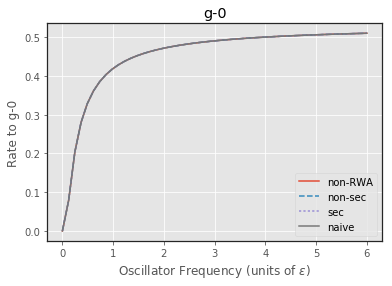

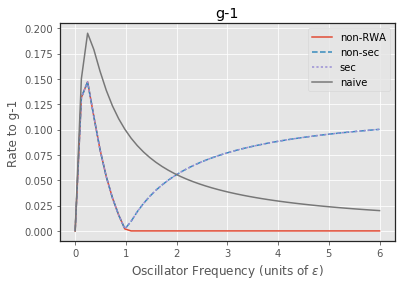

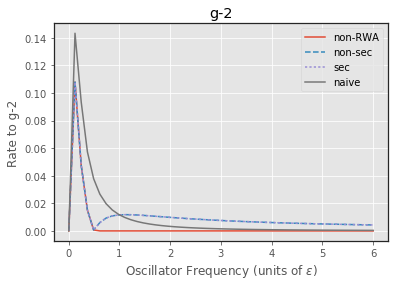

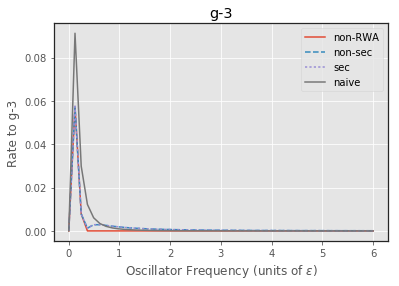

In [52]:
from qutip import vector_to_operator, operator_to_vector, basis


def decay_rate_wRC_dependence(eps, T_ph, alpha_ph, Gamma, T_EM=0., overdamped=True, nvib=3):
    omega_0_props = np.linspace(0.001, 6., 50)
    omega_0 = omega_0_props*eps
    #displacements = alpha_ph/w0
    N = 25
    
    decay_wrt_wRC = [[],[],[],[]]
    labels = ['g-0',  'g-1', 'g-2','g-3', 'g-4', 'g-5']
    count = 1
    for w0 in omega_0:
        if count%5 == 0:
            print "{}% complete.".format((100.*count)/len(omega_0_props))
        count+=1
        if overdamped:
            Gamma = w0**2/wc
        else:
            Gamma = 60.
        
        if w0 > eps*0.7:
            N = 14
        L_RC, H, A_EM, A_nrwa, wRC, kappa, Gamma_1 = RC.RC_function_UD(
                                            sigma, eps, T_ph, Gamma, w0, 
                                            alpha_ph, N , silent=True)
        
    # given some Liouvillian, find the instantaneous decay rates
    # from e-0 to the ground manifold eigenstates, for several
    # oscillator displacements
    # - need to find the first eigenstate in the excited manifold
        evals, states = H.eigenstates()
        ground_list = []
        excited_list = []
        for i in range(len(evals)):
            is_ground = sum(states[i])[0][0].real == 1.
            if is_ground:
                ground_list.append(i)
            else:
                excited_list.append(i)
        excited_ket = states[excited_list[0]]
        
        #initial_ket = tensor(basis(2,1), basis(N,0))
        excited_rho = excited_ket*excited_ket.dag()
        
        L= [EM.L_non_rwa(H, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM, silent=True), 
            EM.L_nonsecular(H, A_EM, eps, Gamma_EM, T_EM, J=J_EM, silent=True),
            EM.L_vib_lindblad(H, A_EM, eps, Gamma_EM, T_EM, J=J_EM, silent=True),
            EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J=J_EM, silent=True)]
        for i_, L_EM in enumerate(L):
            decay_rates = [] # not really decay rates but population at short times
            for j in range(nvib):
                ground_ket = tensor(basis(2,0), basis(N,j))
                #print states[ground_list][j].dag()*target_ket
                #target_rho = operator_to_vector(target_ket*target_ket.dag())
                L_rho0_prod = vector_to_operator(L_EM*operator_to_vector(excited_ket*excited_ket.dag()))
                rate = L_rho0_prod.matrix_element(ground_ket.dag(), ground_ket)
                decay_rates.append(rate)
                
            if len(decay_rates)!=nvib:
                print ground_list
            decay_wrt_wRC[i_].append(decay_rates)
    for level in range(nvib): 
        plt.figure()
        plt.title(labels[level])
        plt.plot(omega_0_props, np.array(decay_wrt_wRC[0]).T[level], label='non-RWA')
        plt.plot(omega_0_props, np.array(decay_wrt_wRC[1]).T[level], label='non-sec', linestyle='dashed')
        plt.plot(omega_0_props, np.array(decay_wrt_wRC[2]).T[level], label='sec', linestyle='dotted')
        plt.plot(omega_0_props, np.array(decay_wrt_wRC[3]).T[level], label='naive')
        plt.legend()
        plt.xlabel(r'Oscillator Frequency (units of $\epsilon$)')
        plt.ylabel('Rate to {}'.format(labels[level]))
    plt.show()
    return omega_0_props, decay_wrt_wRC
    #for i, alpha in enumerate(alpha_ph):
    #    plt.plot(decay_wrt_alpha[i])

omega_0_props, decay_wrt_wRC = decay_rate_wRC_dependence(eps, 300., eps*0.15, 60., overdamped=True, nvib=4)
#decay_rate_plotter(H_RC, L_ns)
#decay_rate_plotter(H_RC, L_n)

## Steadystate convergence: $\omega_{RC}$ dependence
Now convergence of steadystates with respect to $\omega_{RC}$, since although the rates for lowest lying states (particularly for naive) are not converged well into $\omega_{RC}>\epsilon$, this may not affect the steady states. If so at high T, it might not at low T.

In [5]:
w0 = eps*1.1
wc = 52.
Gamma = (w0**2)/wc

def driving_convergence_wRC(eps, alpha_prop, T_EM=6000., T_ph=300., 
                            overdamped=False, min_w0_prop=0.01,
                            max_w0_prop=4., Gamma=20.):
    omega_0_props = np.linspace(min_w0_prop, max_w0_prop, 40)
    omega_0 = omega_0_props*eps
    #displacements = alpha_ph/w0
    N = 29
    count = 1
    data = []
    labels = ['nrwa', 'non-sec', 'naive']
    
    alpha_ph = eps*alpha_prop
    shift = 0.5*np.pi*alpha_ph

    for w0 in omega_0:
        
        if overdamped:
            Gamma = w0**2/wc
            if w0 > eps*0.2:
                N = 25#25
            if w0 > eps*0.7:
                N=14#14
        else:
            Gamma = Gamma
            if w0 <0.6*eps:
                N=35

        
        n_RC = EM.Occupation(w0, T_ph)
        rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
        #print (rho_0*tensor(qeye(2), destroy(N).dag()*destroy(N))).tr()

        # Expectation values and time increments needed to calculate the dynamics
        expects = [tensor(G*G.dag(), qeye(N)), tensor(E*G.dag(), qeye(N)), 
               tensor(E*E.dag(), qeye(N)), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
               tensor(qeye(2), destroy(N).dag()+destroy(N))]
        ti = time.time()
        L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma_1= RC.RC_function_UD(
                                                    sigma, eps, T_ph, Gamma, 
                                                    w0, alpha_ph, N, silent=True)
        evals, states = H_RC.eigenstates()
        ground_list = []
        excited_list = []
        for i in range(len(evals)): #
            is_ground = sum(states[i])[0][0].real == 1.
            if is_ground:
                ground_list.append(i)
            else:
                excited_list.append(i)
        L= [EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM, silent=True), 
            EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J_EM, silent=True),
            EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J=J_EM, silent=True)]
        obs_states = [states[i] for i in [excited_list[0],excited_list[1],
                                          ground_list[0],ground_list[1],
                                          ground_list[2]]]
        d1 = []
        for j, L_EM in enumerate(L):
            ss = steadystate(H_RC, [L_RC+L_EM])
            d2 = []
            for i, state in enumerate(obs_states):    
                d2.append(ss.matrix_element(state.dag(), state).real)
            d2.append((ss.ptrace(0)).matrix_element(G.dag(), G))
            d1.append(d2)
        data.append(d1)
        tf = time.time()
        if count ==1 or count%5==0:
            print "{:0.2f}% finished".format((float(count)/len(omega_0))*100)
            print " ** The previous steady state took: {}s**".format(tf-ti)
        count+=1
        
    data = np.array(data).transpose((1,2,0))
    vib_states = ['e-0', 'e-1', 'g-0', 'g-1','g-2','ground']
    f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', figsize=(14,8))
    axes = [eval("ax{}".format(i)) for i in range(1,7)]    
    for j, title in enumerate(vib_states):
        for i in range(len(data)):
            axes[j].set_title(title)
            axes[j].plot(omega_0_props, data[i][j], label=labels[i])
            axes[j].set(xlabel=r'Oscillator frequency (units of $\epsilon$)', 
                                                       ylabel="Population")
    plt.tight_layout(pad=0.3, w_pad=0.3, h_pad=1.0)
    plt.legend()
    plt.show()
    
"""    
#driving_convergence_wRC(eps, 0.3, T_EM=0., overdamped=True)
driving_convergence_wRC(eps, 0.3, T_EM=6000., max_w0_prop=1.1, overdamped=True)
driving_convergence_wRC(eps, 0.3, T_EM=6000., min_w0_prop=1, overdamped=True)
driving_convergence_wRC(eps, 0.3, T_EM=6000., min_w0_prop=1, overdamped=True)
#driving_convergence_wRC(eps, 0.1, T_EM=6000., overdamped=True)"""

'    \n#driving_convergence_wRC(eps, 0.3, T_EM=0., overdamped=True)\ndriving_convergence_wRC(eps, 0.3, T_EM=6000., max_w0_prop=1.1, overdamped=True)\ndriving_convergence_wRC(eps, 0.3, T_EM=6000., min_w0_prop=1, overdamped=True)\ndriving_convergence_wRC(eps, 0.3, T_EM=6000., min_w0_prop=1, overdamped=True)\n#driving_convergence_wRC(eps, 0.1, T_EM=6000., overdamped=True)'

2.50% finished
 ** The previous steady state took: 10.484869957s**
12.50% finished
 ** The previous steady state took: 9.21435499191s**
25.00% finished
 ** The previous steady state took: 7.24345707893s**
37.50% finished
 ** The previous steady state took: 10.3514001369s**
50.00% finished
 ** The previous steady state took: 7.04897093773s**
62.50% finished
 ** The previous steady state took: 7.00630998611s**
75.00% finished
 ** The previous steady state took: 1.92819499969s**
87.50% finished
 ** The previous steady state took: 2.46114611626s**
100.00% finished
 ** The previous steady state took: 1.76189303398s**


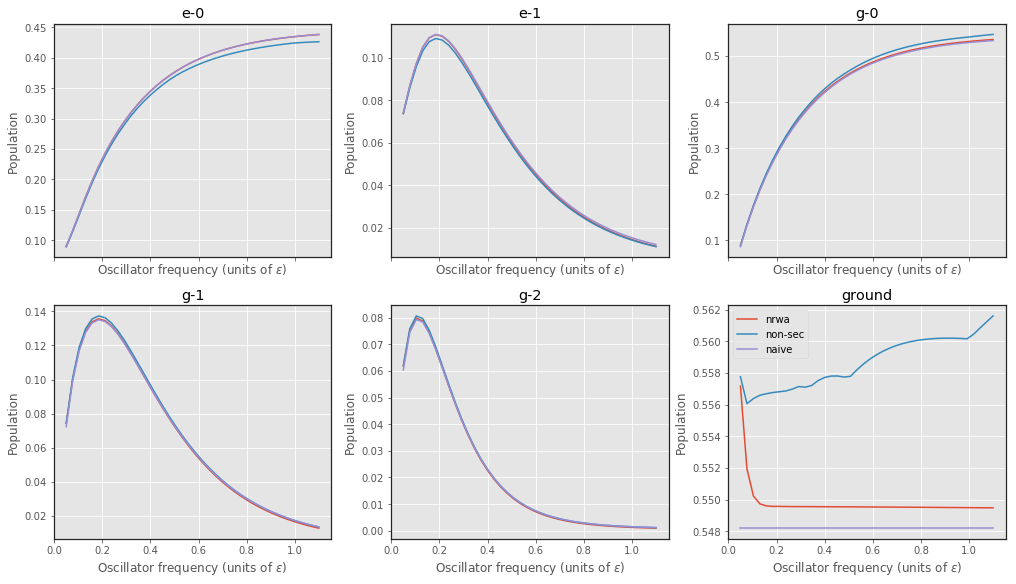

2.50% finished
 ** The previous steady state took: 3.48801493645s**
12.50% finished
 ** The previous steady state took: 2.79251289368s**
25.00% finished
 ** The previous steady state took: 2.00759482384s**
37.50% finished
 ** The previous steady state took: 1.7678501606s**
50.00% finished
 ** The previous steady state took: 1.96606683731s**
62.50% finished
 ** The previous steady state took: 2.08428096771s**
75.00% finished
 ** The previous steady state took: 1.97749090195s**
87.50% finished
 ** The previous steady state took: 1.84557390213s**
100.00% finished
 ** The previous steady state took: 1.70107984543s**


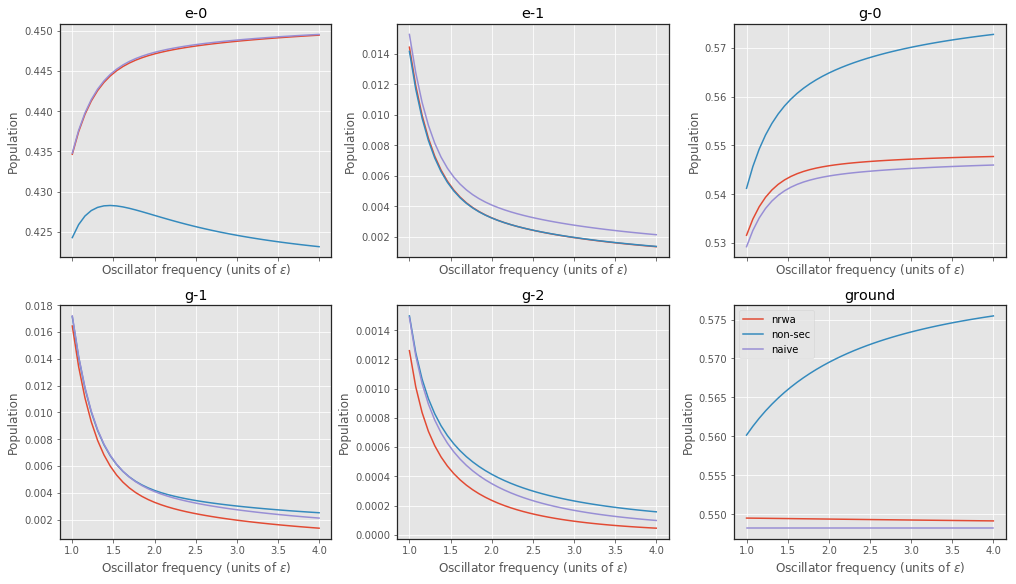

In [53]:
driving_convergence_wRC(eps, 0.5, T_EM=6000., min_w0_prop=0.05, max_w0_prop=1.1, overdamped=True)
driving_convergence_wRC(eps, 0.5, T_EM=6000., min_w0_prop=1., overdamped=True)

So we can see that the non-secular theory predicts steadystates which are very sensitive to $\omega_{RC}$, even when it is the same scale as $\epsilon$. This is counterintuitive since this is regime in which the specifics of the RC itself should not be so important (no longer single-mode like). This could be to do with the unphysical and non-thermodynamically stable processes that it allows. Although the phenomenological Lindblad theory has these processes as well, this is only incidental as the actual dissipator cannot see the vibronic levels at all, in actuality the only thing that matters about the Naive environment is the temperature and decay rate. The NS can see these levels but just deals with them inconsistently.

Now, underdamped spectral densities.

2.50% finished
 ** The previous steady state took: 16.3661940098s**
12.50% finished
 ** The previous steady state took: 14.713301897s**
25.00% finished
 ** The previous steady state took: 14.5542831421s**
37.50% finished
 ** The previous steady state took: 16.9170250893s**
50.00% finished
 ** The previous steady state took: 16.2428588867s**
62.50% finished
 ** The previous steady state took: 14.6274909973s**
75.00% finished
 ** The previous steady state took: 16.0402951241s**
87.50% finished
 ** The previous steady state took: 21.0202770233s**
100.00% finished
 ** The previous steady state took: 16.9761199951s**


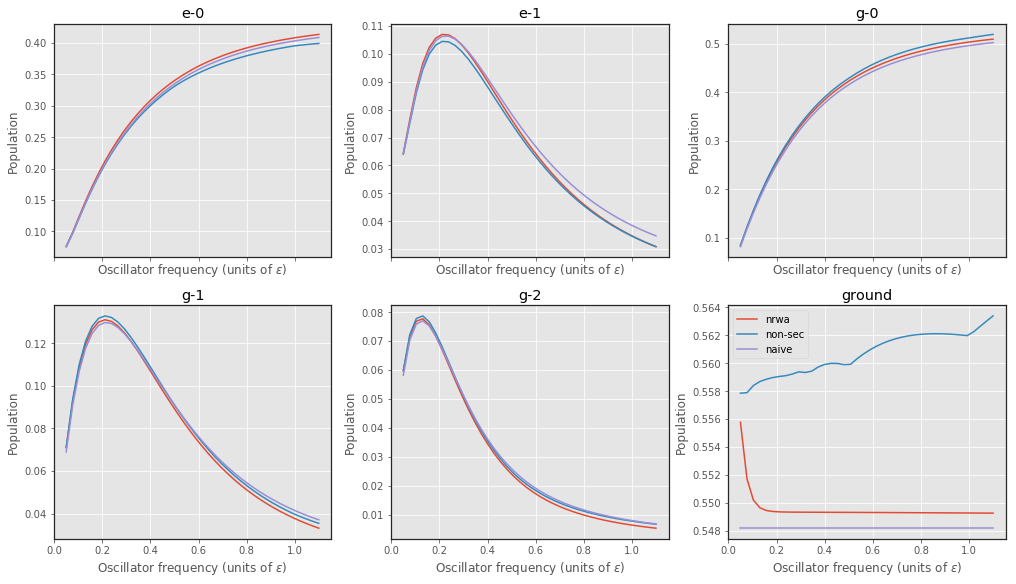

2.50% finished
 ** The previous steady state took: 9.59237408638s**
12.50% finished
 ** The previous steady state took: 11.8186540604s**
25.00% finished
 ** The previous steady state took: 8.73994016647s**
37.50% finished
 ** The previous steady state took: 8.56671595573s**
50.00% finished
 ** The previous steady state took: 8.46927118301s**
62.50% finished
 ** The previous steady state took: 8.28793311119s**
75.00% finished
 ** The previous steady state took: 10.0503180027s**
87.50% finished
 ** The previous steady state took: 9.14174509048s**
100.00% finished
 ** The previous steady state took: 9.64179801941s**


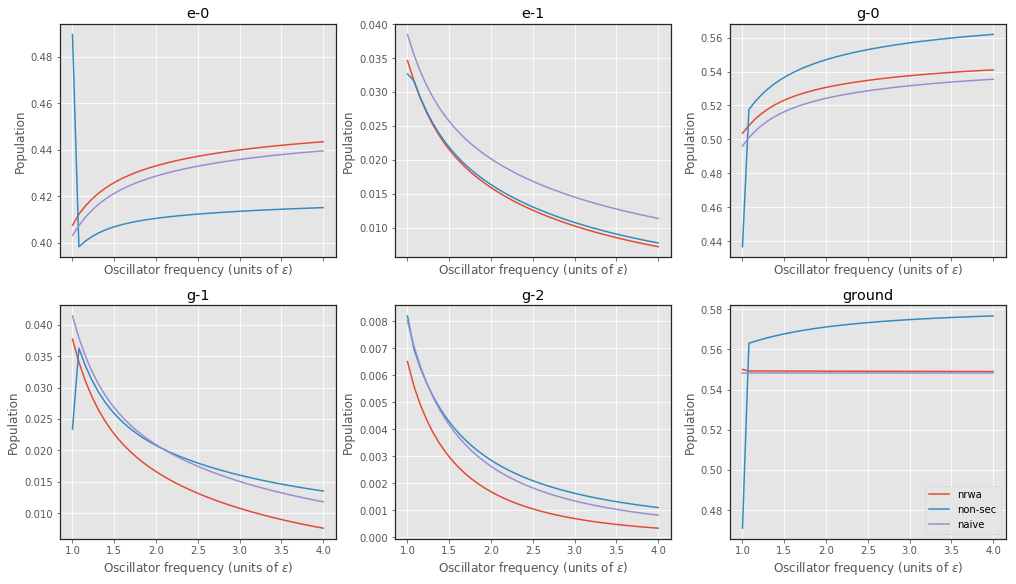

In [9]:
#
driving_convergence_wRC(eps, 0.5, T_EM=6000., min_w0_prop=0.05, max_w0_prop=1.1, overdamped=False)
driving_convergence_wRC(eps, 0.5, T_EM=6000., min_w0_prop=1., overdamped=False)

We can see that the electronic steady states converge very quickly with $\omega_0$ for the non-RWA (they're constant for naive). For the non-secular however, the steady-states do not converge and they are very sensitive to small changes in $\omega_0$. This is very similar behaviour as the overdamped case.

## Instantaneous Decay rates: coupling strength dependence

Now we will look at decay rates at short times and $T_{EM}=0$ from the $|e,0\rangle \to |g,k\rangle$ states.

10.00% finished
50.00% finished
100.00% finished


/home/henry/anaconda2/envs/qutip/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


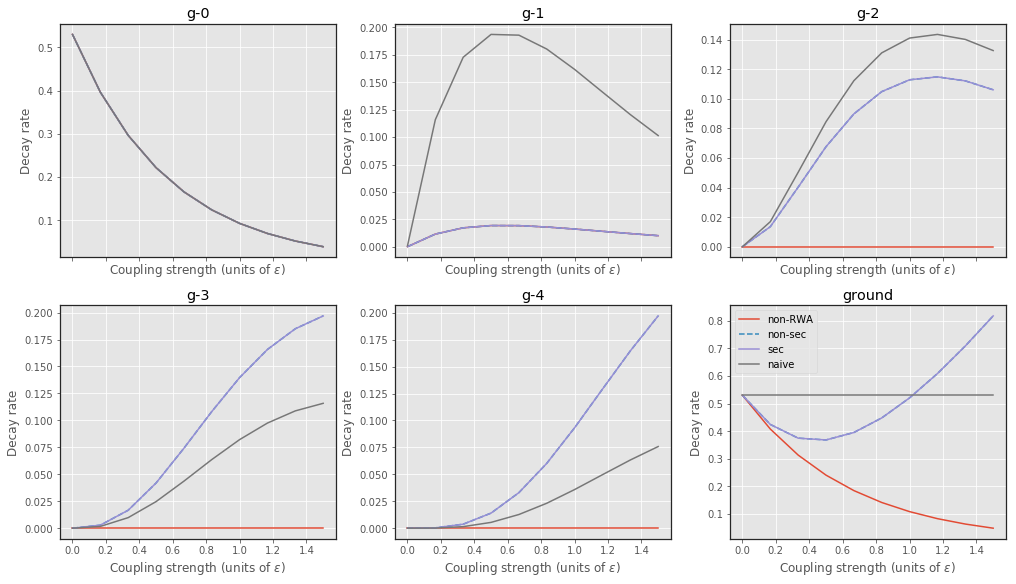

10.00% finished
50.00% finished
100.00% finished


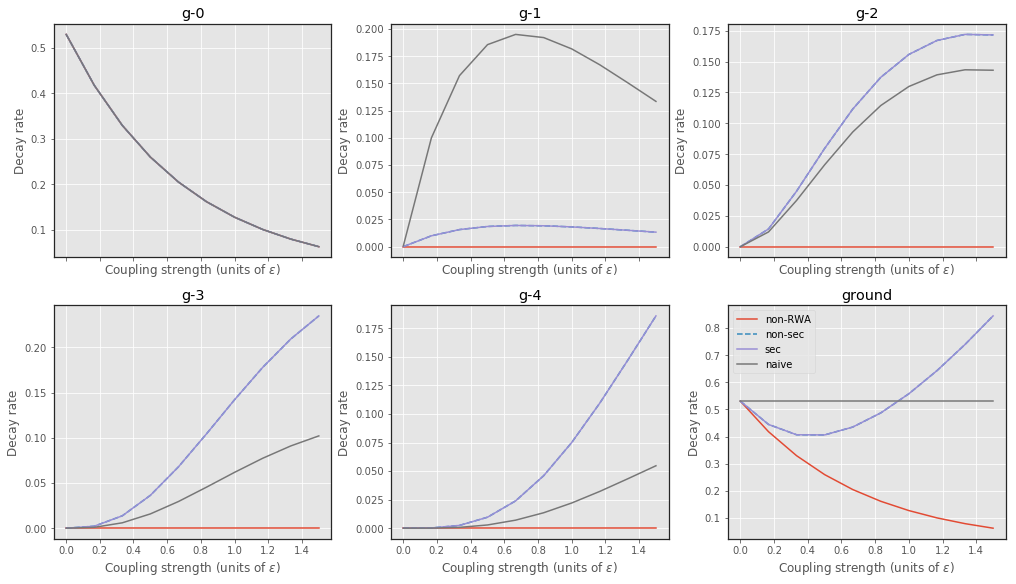

10.00% finished
50.00% finished
100.00% finished


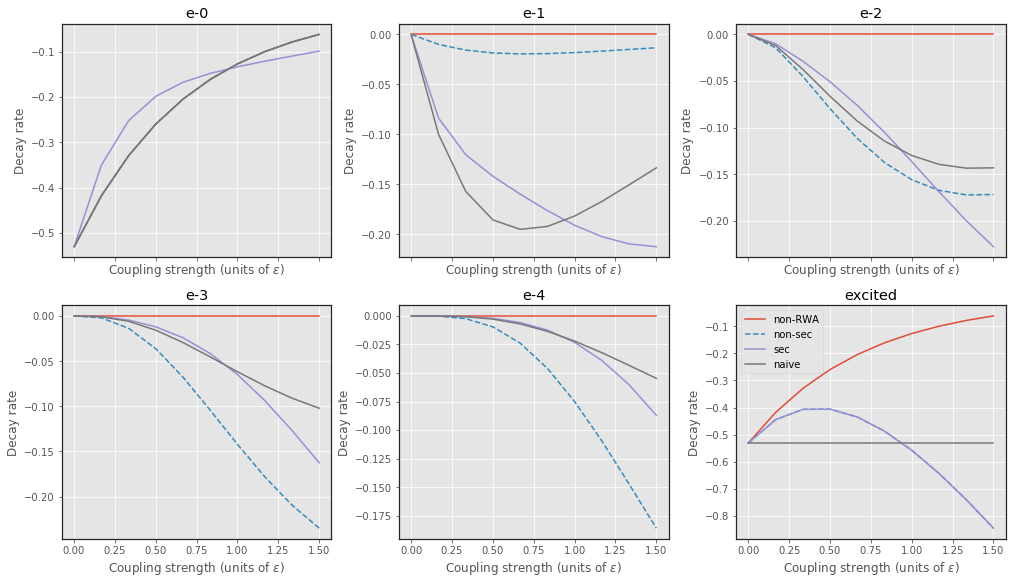

10.00% finished
50.00% finished
100.00% finished


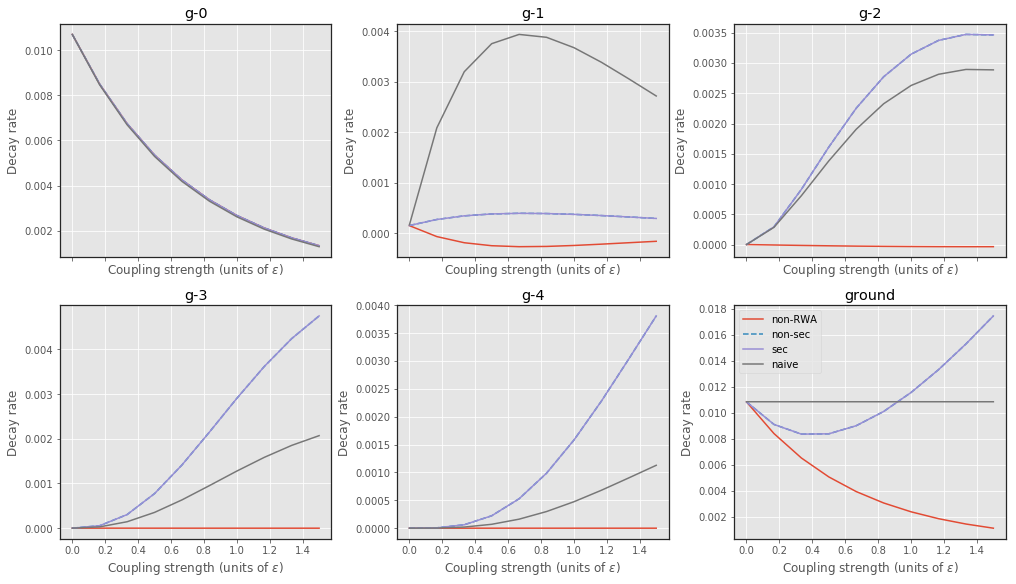

10.00% finished
50.00% finished
100.00% finished


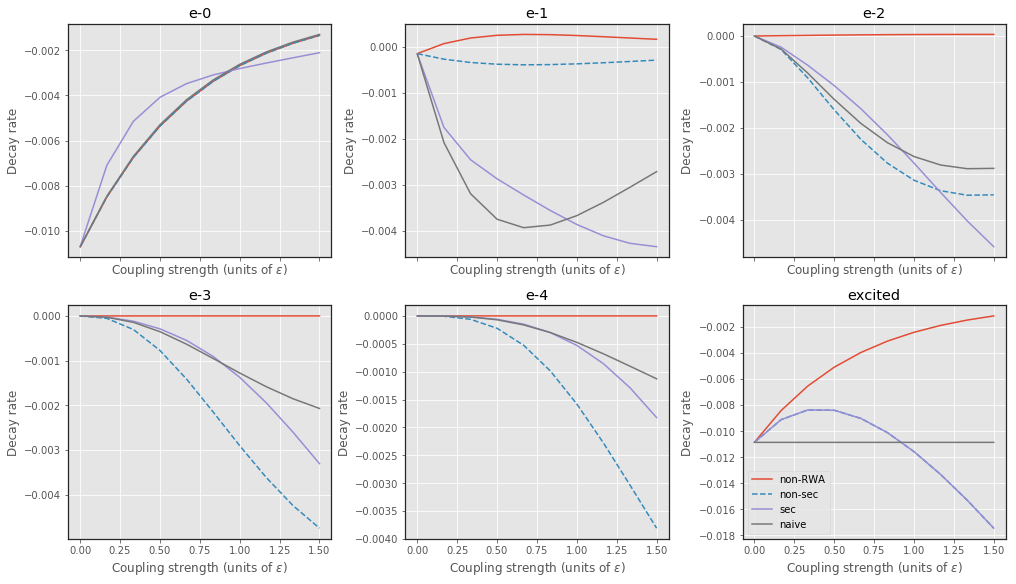

In [4]:
from qutip import vector_to_operator, operator_to_vector, basis


def decay_rate_alpha( eps, T_ph, w0, overdamped=True, nvib=5, T_EM=0., init_sys=1, init_RC=0, final_sys=0):
    alpha_props = np.linspace(0.001,1.5,10)
    alpha_ph = alpha_props*eps
    N = 15
    if overdamped:
        Gamma_ = w0**2/wc
    else:
        Gamma_ = 60.
    decay_wrt_alpha = [[],[],[],[]]
    count = 1
    for alpha_ in alpha_ph:
        
        L_RC, H, A_EM, A_nrwa, wRC, kappa, Gamma_1 = RC.RC_function_UD(sigma, eps, T_ph, 
                                                                       Gamma_, w0, alpha_, 
                                                                       N, silent=True)
    # given some Liouvillian, find the instantaneous decay rates
    # from e-0 to the ground manifold eigenstates, for several
    # oscillator displacements
    # - need to find the first eigenstate in the excited manifold
        evals, states = H.eigenstates()
        ground_list = []
        excited_list = []
        for i in range(len(evals)): #
            is_ground = sum(states[i])[0][0].real == 1.
            if is_ground:
                ground_list.append(i)
            else:
                excited_list.append(i)
        excited_ket = states[excited_list[0]]
        if init_sys == 0:
            init_ket = states[ground_list[init_RC]]
            init_rho = init_ket*init_ket.dag()
        elif init_sys==1:
            init_ket = states[excited_list[init_RC]]
            init_rho = init_ket*init_ket.dag()
        else:
            num = (-H*beta_f(T_ph)).expm()
            init_rho =  num/num.tr()
        if final_sys == 0:
            labels = ['g-0',  'g-1', 'g-2','g-3', 'g-4', 'ground']
            final_elec = G
        else:
            labels = ['e-0',  'e-1', 'e-2','e-3', 'e-4', 'excited']
            final_elec = E
        L= [EM.L_non_rwa(H, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM, silent=True), 
            EM.L_nonsecular(H, A_EM, eps, Gamma_EM, T_EM, J=J_EM, silent=True),
            EM.L_vib_lindblad(H, A_EM, eps, Gamma_EM, T_EM, J=J_EM, silent=True),
            EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J=J_EM, silent=True)]
        for i_, L_EM in enumerate(L):
            decay_rates = []
            for j in range(nvib):
                final_ket = tensor(basis(2,final_sys), basis(N,j))
                #print states[ground_list][j].dag()*target_ket
                #target_rho = operator_to_vector(target_ket*target_ket.dag())
                L_rho0_prod = vector_to_operator(L_EM*operator_to_vector(init_rho))
                rate = L_rho0_prod.matrix_element(final_ket.dag(), final_ket)
                decay_rates.append(rate)
            L_rho0_prod = vector_to_operator(L_EM*operator_to_vector(init_rho))
            rate = L_rho0_prod.ptrace(0).matrix_element(final_elec.dag(), final_elec)
            decay_rates.append(rate)
            decay_wrt_alpha[i_].append(decay_rates)
        if count ==1 or count%5==0:
            print "{:0.2f}% finished".format((float(count)/len(alpha_ph))*100)
        count+=1
    f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', figsize=(14,8))
    axes = [eval("ax{}".format(i)) for i in range(1,7)]
    for i in range(nvib): # each vibronic level of interest
        axes[i].set_title(labels[i])
        axes[i].plot(alpha_props,np.array(decay_wrt_alpha[0]).T[i], label='non-RWA')
        axes[i].plot(alpha_props,np.array(decay_wrt_alpha[1]).T[i], label='non-sec', linestyle='dashed')
        axes[i].plot(alpha_props,np.array(decay_wrt_alpha[2]).T[i], label='sec')
        axes[i].plot(alpha_props,np.array(decay_wrt_alpha[3]).T[i], label='naive')
        axes[i].set(xlabel=r"Coupling strength (units of $\epsilon$)", 
               ylabel="Decay rate")
    axes[-1].set_title(labels[-1])
    axes[-1].plot(alpha_props,np.array(decay_wrt_alpha[0]).T[-1], label='non-RWA')
    axes[-1].plot(alpha_props,np.array(decay_wrt_alpha[1]).T[-1], label='non-sec', linestyle='dashed')
    axes[-1].plot(alpha_props,np.array(decay_wrt_alpha[2]).T[-1], label='sec')
    axes[-1].plot(alpha_props,np.array(decay_wrt_alpha[3]).T[-1], label='naive')
    axes[-1].set(xlabel=r"Coupling strength (units of $\epsilon$)", 
           ylabel="Decay rate")
    plt.tight_layout(pad=0.3, w_pad=0.3, h_pad=1.0)
    plt.legend()
    plt.show()
    return alpha_ph, decay_wrt_alpha
    #for i, alpha in enumerate(alpha_ph):
    #    plt.plot(decay_wrt_alpha[i])

alphas, decay_wrt_alpha = decay_rate_alpha(eps, T_ph, eps*0.9)
alphas, decay_wrt_alpha = decay_rate_alpha(eps, T_ph, eps*1.1, T_EM=0.,
                                                    init_sys=1, init_RC=0, final_sys=0) # initially thermal
alphas, decay_wrt_alpha = decay_rate_alpha(eps, T_ph, eps*1.1,
                                                    init_sys=1, init_RC=0, final_sys=1) # initially thermal
alphas, decay_wrt_alpha = decay_rate_alpha(eps, T_ph, eps*1.1, T_EM=0.,
                                                    init_sys=3, init_RC=0, final_sys=0) # initially thermal
alphas, decay_wrt_alpha = decay_rate_alpha(eps, T_ph, eps*1.1,
                                                    init_sys=3, init_RC=0, final_sys=1) # initially thermal

#decay_rate_plotter(H_RC, L_ns)
#decay_rate_plotter(H_RC, L_n)

IT seems that:
- I can't see any decay rates from $|e,0\rangle \to |g,k\rangle$ with $\langle g,k|L_{EM}\rho(0) |e,0\rangle$ in non-RWA. If the system starts in a higher-lying vibrational state though, it decays to lower lying ground vibrational states in a similar manner to the non-secular theory. It's as if only certain transitions are allowed electronically and some vibrationally, so when these states are populated via the latter process they decay in a similar fashion to the non-secular theory. This absolutely makes sense from an energetic point of view as the RC frequency is greater than the system splitting, so if ground vibrational quantum number > excited vib. then this is a higher lying state and so cannot be populated at zero EM temperature.
- Using my method of defining the rates $|e,0\rangle \to |g,k\rangle$ with $\langle g,k|L_{EM}\rho(0) |g,k\rangle$ I only see non-zero decay rates for non-RWA case for $n=0$. As alpha increases the decay to $|g,0\rangle$ decreases to zero (should be exponential overlap no?) by none of the other decay pathways open up as well. This would make it thermodynamically unstable, localising an population in the excited state (quantum zeno?).
- With $T_{EM}=0$ and $\rho(0)=|g, n\rangle$ there are rates going to the excited state for non-RWA. This doesn't make any sense as these states cannot be thermally populated.

Need to: 
- find which method is definitely correct. Speak to Ahsan.
- Calculate using Ahsan's derivation of the non-RWA master equation.

## Instantaneous decay rates: EM temperature dependence 

The rates will be independent of phonon temperature as they only depend on TLS_RC eigenstates which do not contain information about $T_ph$.

w0: 241.965, eps: 806.55, alpha_ph: 80.655


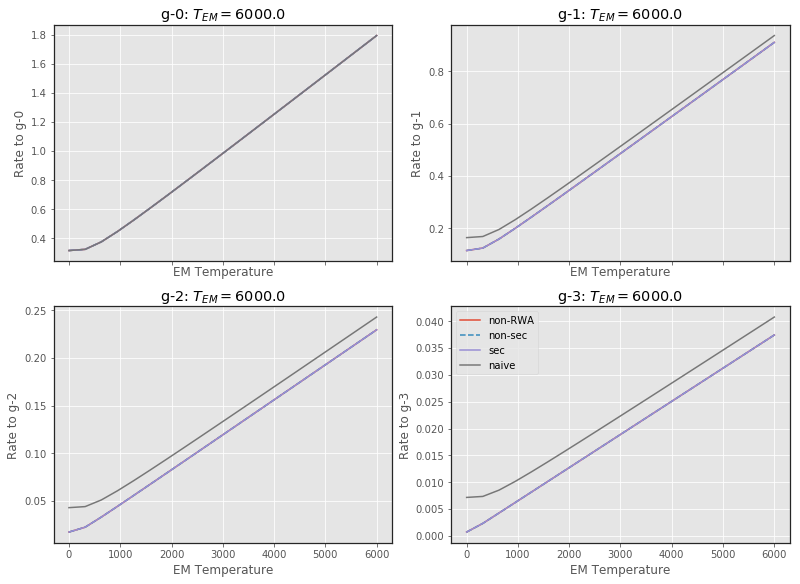

w0: 725.895, eps: 806.55, alpha_ph: 80.655


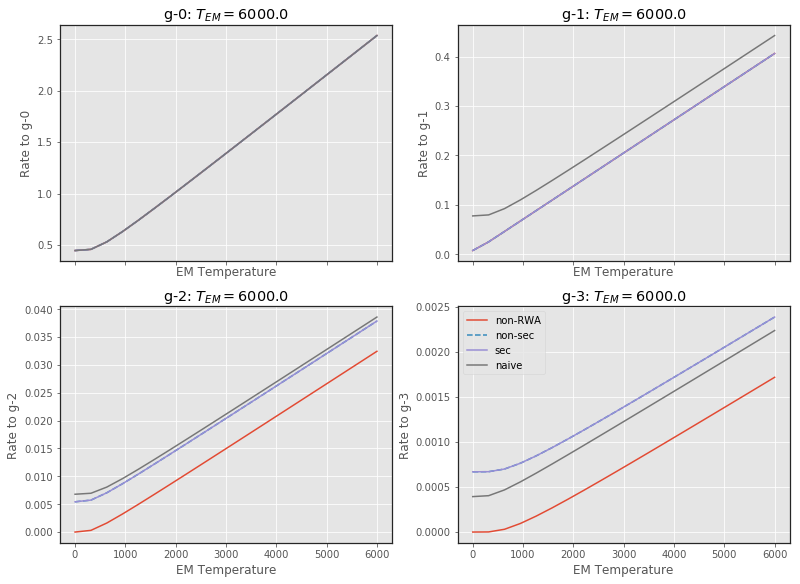

In [61]:
from qutip import vector_to_operator, operator_to_vector, basis


def decay_rate_wrt_T(eps, alpha_ph, w0, overdamped=True):
    nvib=4
    T_array = np.linspace(0,6000,20)
    N = 5
    if overdamped:
        Gamma_ = w0**2/wc
    else:
        Gamma_ = 60.
        N = 24
    decay_wrt_T = [[],[],[],[]]
    labels = ['g-0',  'g-1', 'g-2','g-3', 'g-4', 'g-5']
    
    for T in T_array:
        L_RC, H, A_EM, A_nrwa, wRC, kappa, Gamma_1 = RC.RC_function_UD(sigma, eps, 300., Gamma_,
                                                                       w0, alpha_ph, N, silent=True)
    # given some Liouvillian, find the instantaneous decay rates
    # from e-0 to the ground manifold eigenstates, for several
    # oscillator displacements
    # - need to find the first eigenstate in the excited manifold
        evals, states = eigstate_calc_and_mag_sort(H, sort=False)
        ground_list = []
        excited_list = []
        for i in range(len(evals)): #
            is_ground = sum(states[i])[0][0].real == 1.
            if is_ground:
                ground_list.append(i)
            else:
                excited_list.append(i)
        excited_ket = states[excited_list[0]]
        
        #initial_ket = tensor(basis(2,1), basis(N,0))
        excited_rho = excited_ket*excited_ket.dag()
        
        L= [EM.L_non_rwa(H, A_nrwa, eps, Gamma_EM, T, J=J_EM, silent=True), 
            EM.L_nonsecular(H, A_EM, eps, Gamma_EM, T, J=J_EM, silent=True),
            EM.L_vib_lindblad(H, A_EM, eps, Gamma_EM, T, J=J_EM, silent=True),
            EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T, J=J_EM, silent=True)]
        for i_, L_EM in enumerate(L):
            decay_rates = [] # not really decay rates but population at short times
            for j in range(nvib):
                ground_ket = tensor(basis(2,0), basis(N,j))
                #print states[ground_list][j].dag()*target_ket
                #target_rho = operator_to_vector(target_ket*target_ket.dag())
                L_rho0_prod = vector_to_operator(L_EM*operator_to_vector(excited_ket*excited_ket.dag()))
                rate = L_rho0_prod.matrix_element(ground_ket.dag(), ground_ket)
                decay_rates.append(rate)
                
            if len(decay_rates)!=nvib:
                print ground_list
            decay_wrt_T[i_].append(decay_rates)
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', figsize=(11,8))
    axes = [eval("ax{}".format(i)) for i in range(1,5)]
    print "w0: {}, eps: {}, alpha_ph: {}".format(w0, eps, alpha_ph)
    for level in range(nvib):
        axes[level].set_title(labels[level]+r": $T_{EM}=$"+"{:0.1f}".format(T_EM))
        axes[level].plot(T_array,np.array(decay_wrt_T[0]).T[level], label='non-RWA')
        axes[level].plot(T_array,np.array(decay_wrt_T[1]).T[level], label='non-sec', linestyle='dashed')
        axes[level].plot(T_array,np.array(decay_wrt_T[2]).T[level], label='sec')
        axes[level].plot(T_array,np.array(decay_wrt_T[3]).T[level], label='naive')
        axes[level].set(xlabel='EM Temperature', ylabel='Rate to {}'.format(labels[level]))
    plt.tight_layout(pad=0.3, w_pad=0.3, h_pad=1.0)
    plt.legend()
    plt.show()
    return T_array, decay_wrt_T
    #for i, alpha in enumerate(alpha_ph):
    #    plt.plot(decay_wrt_alpha[i])

_, _ = decay_rate_wrt_T(eps, 0.1*eps, eps*0.3)
_, _ = decay_rate_wrt_T(eps, 0.1*eps, eps*0.9)

#decay_rate_plotter(H_RC, L_ns)
#decay_rate_plotter(H_RC, L_n)

## Steady-state population of vibronic states: phonon coupling dependence

In [25]:
def steadystatePop_coupling_dependence(prop_couplings, T_ph, eps, Gamma, w0, T_EM, 
                                    Gamma_EM, overdamped=True, N=14):
    
    if overdamped:
        Gamma = w0**2/wc
    else:
        N=25
    plt.figure()
    G = ket([0])
    E = ket([1])
    sigma = G*E.dag() # Definition of a sigma_- operator.
    J = EM.J_minimal
    count = 1.

    data_nrwa  = [[],[],[],[],[],[],[]]
    data_ns    = [[],[],[],[],[],[],[]]
    data_s     = [[],[],[],[],[],[],[]]
    data_n     = [[],[],[],[],[],[],[]]
    labels = ['g-0',  'g-1', 'g-2','e-0','e-1', 'e-2'] 
    # This is true for specific Hamiltonian parameters
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    print "RC freq. prop = $", w0/eps
    for prop in prop_couplings:
        alpha_ph = prop*eps
        if prop < 0.5:
            N = 14
        I_RC = qt.qeye(N)
        if count ==1 or count%5==0:
            print "{:0.2f}% finished".format((count/len(prop_couplings))*100)
        count+=1
        L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma= RC.RC_function_UD(sigma, eps, 
                                                                       T_ph, Gamma, 
                                                                       w0, alpha_ph, N,
                                                                       silent=True)
        evals, states = H_RC.eigenstates()
        ground_list = []
        excited_list = []
        for i in range(2*N): #
            is_ground = sum(states[i])[0][0].real == 1.
            if is_ground:
                ground_list.append(i)
            else:
                excited_list.append(i)
        lowest_6 = [s*s.dag() for s in states[ground_list[0:3] + excited_list[0:3]]]
        lowest_6.append(tensor(E*E.dag(), I_RC))
        #print len(excited_list), 'excited'
        # electromagnetic bath liouvillians
        L_nrwa = EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J, silent=True)
        L_ns = EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J, silent=True)
        L_s = EM.L_vib_lindblad(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J, silent=True)
        L_n = EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J=J, silent=True)
        for j, obs in enumerate(lowest_6):
            method = 'iterative-lgmres'
            data_nrwa[j].append((obs*steadystate(H_RC, [L_RC+L_nrwa])).tr())
            data_ns[j].append((obs*steadystate(H_RC, [L_RC+L_ns])).tr())
            data_s[j].append((obs*steadystate(H_RC, [L_RC+L_s])).tr())
            data_n[j].append((obs*steadystate(H_RC, [L_RC+L_n])).tr())
    f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', figsize=(14,8))
    axes = [eval("ax{}".format(i)) for i in range(1,7)]
    for i, lab in enumerate(labels):
        axes[i].set_title(lab)
        axes[i].plot(prop_couplings, data_nrwa[i], label='nrwa')
        axes[i].plot(prop_couplings, data_ns[i], label='ns', linestyle='dashed')
        axes[i].plot(prop_couplings, data_s[i], label='s')
        axes[i].plot(prop_couplings, data_n[i], label='n')
        #plt.grid()
        axes[i].set(xlabel=r"Phonon Coupling Strength: units of $\epsilon$", 
               ylabel="Population")
        #axes[i].label_outer()
    plt.tight_layout(pad=0.3, w_pad=0.3, h_pad=1.0)
    plt.legend()
    plt.figure()
    plt.title("Excited state")
    plt.plot(prop_couplings, data_nrwa[-1], label='nrwa')
    plt.plot(prop_couplings, data_ns[-1], label='ns', linestyle='dashed')
    plt.plot(prop_couplings, data_s[-1], label='s')
    plt.plot(prop_couplings, data_n[-1], label='n')
    plt.legend()
    plt.ylabel("Population")
    plt.xlabel(r"Phonon Coupling Strength: units of $\epsilon$")
    plt.show()

RC freq. prop = $ 0.1
3.33% finished
16.67% finished
33.33% finished
50.00% finished
66.67% finished
83.33% finished
100.00% finished


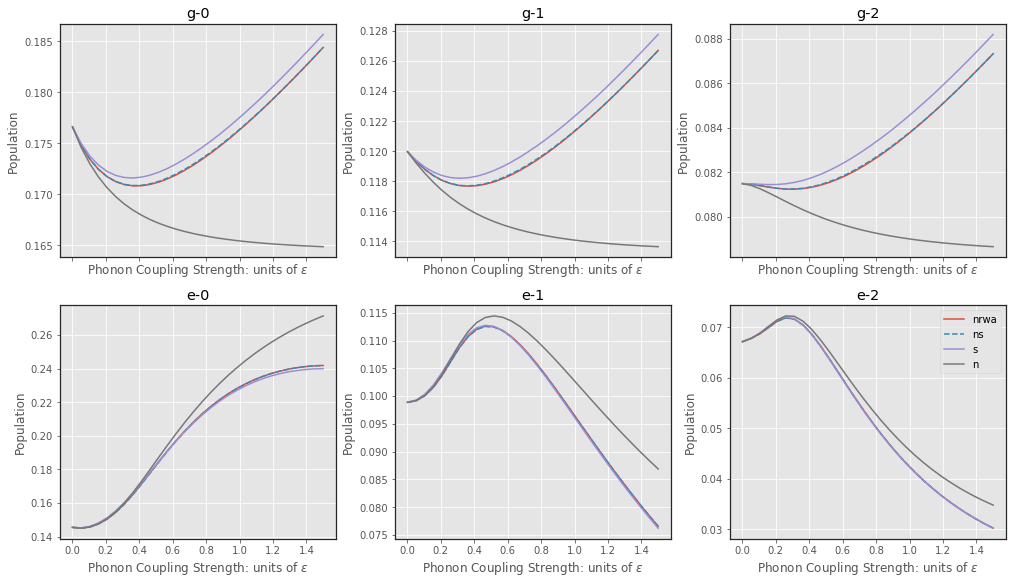

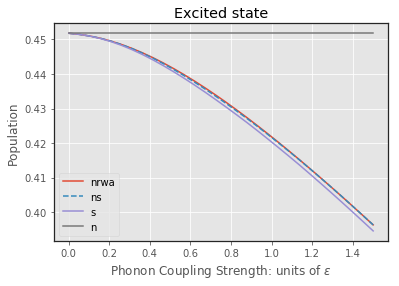

RC freq. prop = $ 0.4
3.33% finished
16.67% finished
33.33% finished
50.00% finished
66.67% finished
83.33% finished
100.00% finished


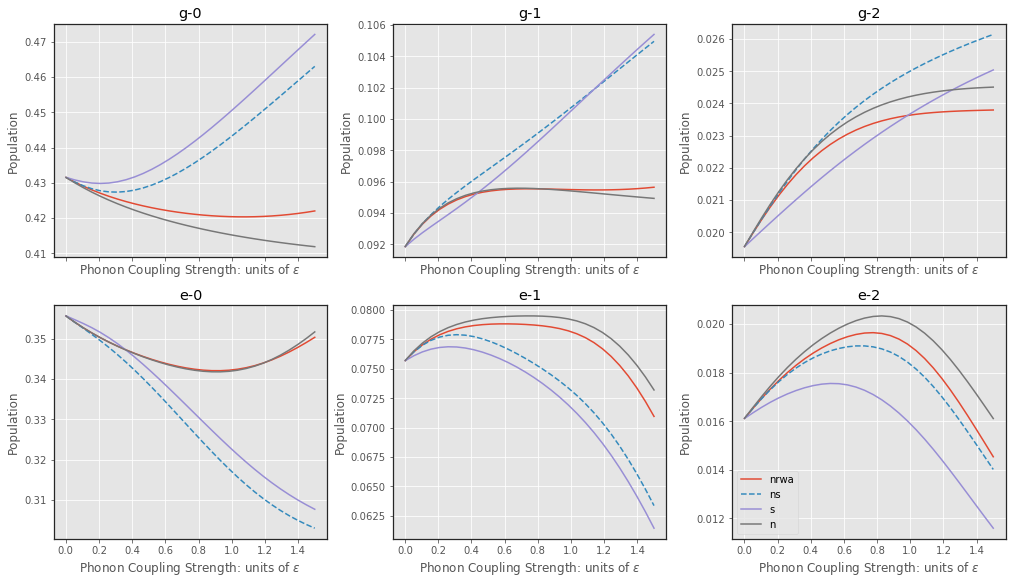

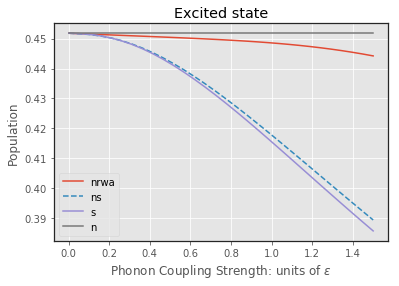

RC freq. prop = $ 0.9
3.33% finished
16.67% finished
33.33% finished
50.00% finished
66.67% finished
83.33% finished
100.00% finished


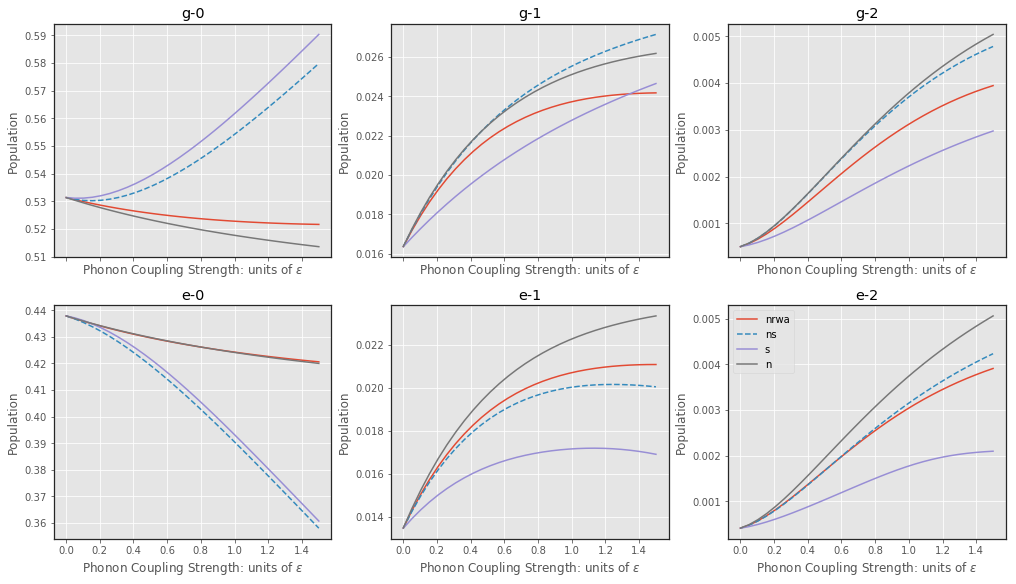

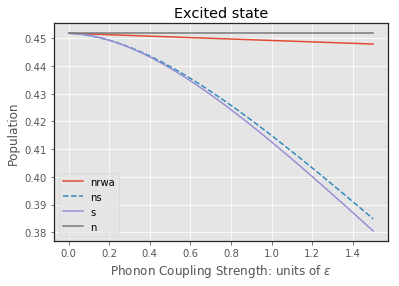

RC freq. prop = $ 1.5
3.33% finished
16.67% finished
33.33% finished
50.00% finished
66.67% finished
83.33% finished
100.00% finished


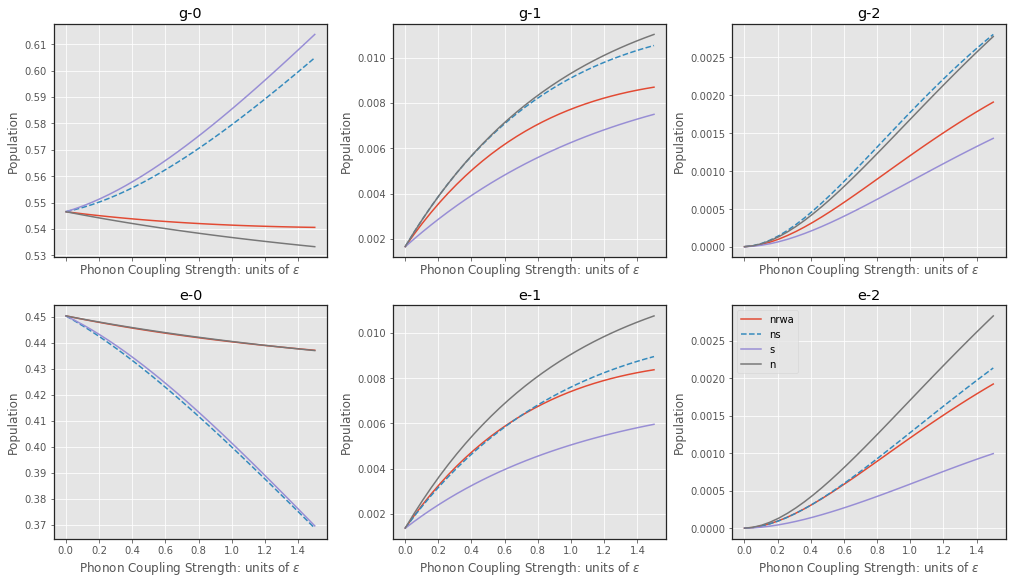

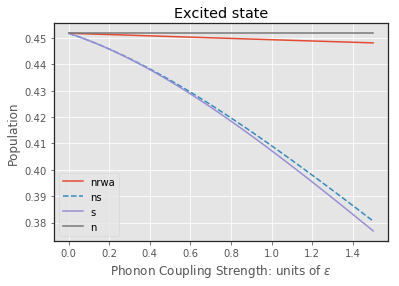

RC freq. prop = $ 3.0
3.33% finished
16.67% finished
33.33% finished
50.00% finished
66.67% finished
83.33% finished
100.00% finished


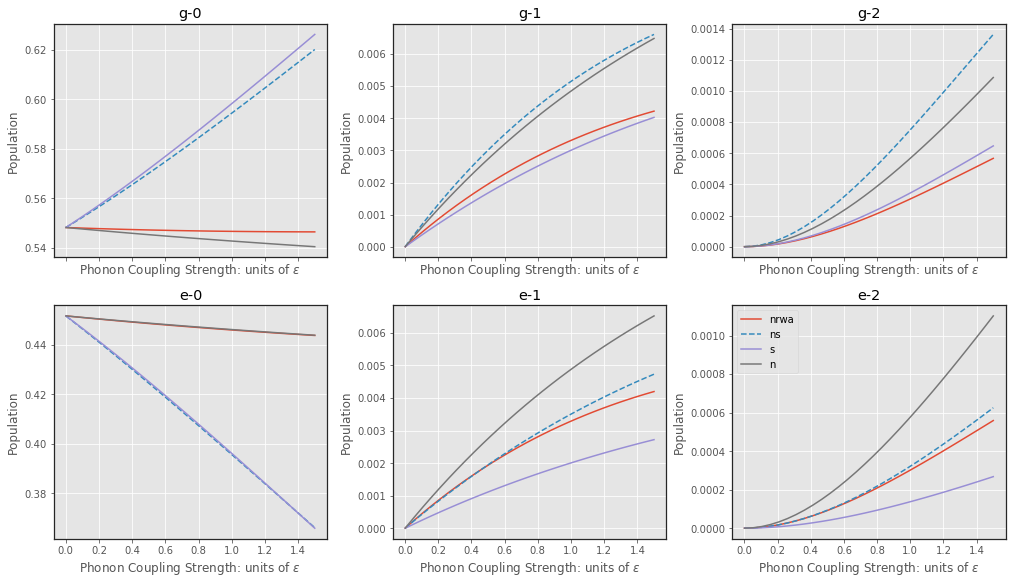

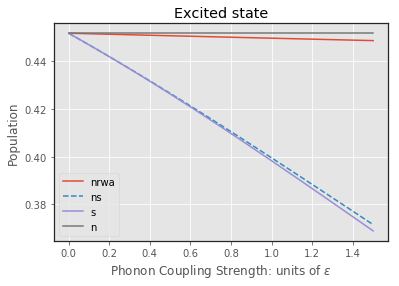

In [26]:
couplings = np.linspace(0.001,1.5,30)
steadystatePop_coupling_dependence(couplings, T_ph, eps, 60, 0.1*eps, 
                                T_EM, Gamma_EM, overdamped=False)
steadystatePop_coupling_dependence(couplings, T_ph, eps, Gamma, 0.4*eps, 
                                T_EM, Gamma_EM, overdamped=True)
steadystatePop_coupling_dependence(couplings, T_ph, eps, Gamma, 0.9*eps, 
                                T_EM, Gamma_EM, overdamped=True)
steadystatePop_coupling_dependence(couplings, T_ph, eps, 60, 1.5*eps, 
                                T_EM, Gamma_EM, overdamped=True)
steadystatePop_coupling_dependence(couplings, T_ph, eps, 60, 3.*eps, 
                                T_EM, Gamma_EM, overdamped=True)

As w0 gets larger, the vibronic dynamics change drastically but the overall electronic levels do not.

# Dynamics of Vibronic States
Should be able to see the vibronic states being occupied, even if the rates are initially zero?

In [ ]:
def vibronic_state_dynamics(init_sys, init_RC, prop_coupling, eps, Gamma, w0, T_ph=300., T_EM=6000., 
                                    Gamma_EM=1., overdamped=True):
    # Start system+RC in adiabatic eigenstate and then time-evolve
    alpha_ph = prop_coupling*eps

    if overdamped:
        w0 = eps*1.01
        Gamma = w0**2/wc
        N = 15
    else:
        N=24
    w = np.linspace(0., eps*1.5, 1000)
    plt.figure()
    plt.plot(w, J_underdamped(w, alpha_ph, Gamma, w0))
    plt.axvline(eps, label='Splitting',color='k')
    plt.ylabel("Coupling Strength")
    plt.xlabel(r"Frequency $cm^{-1}$")
    plt.title("Phonon Spectral Density")
    plt.legend()
    plt.show()
    
    N = 6
    G = ket([0])
    E = ket([1])
    
    sigma = G*E.dag() # Definition of a sigma_- operator.
    J = EM.J_minimal
    count = 1
    I_RC = qt.qeye(N)
    labels = ['g-0',  'g-1', 'g-2','e-0','e-1', 'e-2'] 
    # This is true for specific Hamiltonian parameters
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dyn_DATA = []
    
    L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma= RC.RC_function_UD(sigma, eps, 
                                                                   T_ph, Gamma, 
                                                                   w0, alpha_ph, N)
    evals, states = H_RC.eigenstates()
    ground_list = []
    excited_list = []
    concat_list = [ground_list, excited_list]
    for i in range(len(evals)): #
        is_ground = sum(states[i])[0][0].real == 1.
        if is_ground:
            ground_list.append(i)
        else:
            excited_list.append(i)
    # work out how to initialise system rho
    index_list = []
    if type(init_sys) == tuple:
        #coherence state
        if type(init_RC) == tuple:
            # take in a 2-tuple to initialise in coherence state.
            print init_sys, init_RC
            rho_left = states[concat_list[init_sys[0]][init_RC[0]]]
            rho_right = states[concat_list[init_sys[1]][init_RC[1]]].dag()
            init_rho = rho_left*rho_right
        else:
            raise ValueError
    elif init_sys == 0:
        # population state
        init_rho = states[ground_list[init_RC]]*states[ground_list[init_RC]].dag()
    elif init_sys==1:
        init_rho = states[excited_list[init_RC]]*states[excited_list[init_RC]].dag()
    else:
        # if in neither ground or excited
        # for the minute, do nothing. This'll be fixed below.
        pass
    
        
    if init_sys>1:
        # finally, if not in either G or E, initialise as thermal
        num = (-H_RC*beta_f(T_ph)).expm()
        init_rho =  num/num.tr()
    
    expects_vib = [s*s.dag() for s in states[ground_list[0:3] + excited_list[0:3]]]
    expects_vib.append(tensor(E*E.dag(), I_RC))
    #print len(excited_list), 'excited'
    # electromagnetic bath liouvillians
    L_nrwa = EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J, silent=True)
    L_ns = EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J, silent=True)
    L_s = EM.L_vib_lindblad(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J, silent=True)
    L_n = EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J=J, silent=True)
    Liouvs = [L_nrwa, L_ns, L_s, L_n]
    timelist = np.linspace(0,1.,900)
    options = qt.Options(nsteps=1500, num_cpus=2)
    if T_EM<1000:
        timelist = np.linspace(0,2.,1500)
        #options = qt.Options(nsteps=1500, num_cpus=3)
    for L_EM in Liouvs:
        ti = time.time()
        dyn_DATA.append(mesolve(H_RC, init_rho, timelist, [L_RC+L_EM], expects_vib, options=options))
        print "Completed dynamics calculation {} in {} seconds.".format(Liouvs.index(L_EM)+1, time.time()-ti)
    
    f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', figsize=(14,8))
    axes = [eval("ax{}".format(i)) for i in range(1,7)]
    for i, lab in enumerate(labels):
        
        axes[i].set_title(lab)
        axes[i].plot(timelist, dyn_DATA[0].expect[i], label='nrwa')
        axes[i].plot(timelist, dyn_DATA[1].expect[i], label='ns', linestyle='dashed')
        axes[i].plot(timelist, dyn_DATA[2].expect[i], label='s')
        axes[i].plot(timelist, dyn_DATA[3].expect[i], label='n')
        #plt.grid()
        axes[i].set(xlabel=r"Time", 
               ylabel="Population")
        #axes[i].label_outer()
        if type(init_sys) == int:
            """
            init_state_final_pop_0 = dyn_DATA[0].expect[(3*init_sys+init_RC)][-1] # naive
            init_state_final_pop_1 = dyn_DATA[1].expect[(3*init_sys+init_RC)][-1] # nrwa
            init_state_final_pop_2 = dyn_DATA[2].expect[(3*init_sys+init_RC)][-1] # ns
            init_state_final_pop_3 = dyn_DATA[3].expect[(3*init_sys+init_RC)][-1] # s
            print "{} state accounts for".format(lab)
            print "NRWA: {:0.4f}%".format(100*(dyn_DATA[0].expect[i][-1]/init_state_final_pop_0))
            print "NS: {:0.4f}%" .format(100*(dyn_DATA[1].expect[i][-1]/init_state_final_pop_1))
            print "Naive: {:0.4f}% of total dynamics".format(100*(dyn_DATA[2].expect[i][-1]/init_state_final_pop_2))
            print "Naive: {:0.4f}% of total dynamics".format(100*(dyn_DATA[3].expect[i][-1]/init_state_final_pop_3))
            """
            pass
    plt.tight_layout(pad=0.3, w_pad=0.3, h_pad=1.0)
    plt.legend()
    plt.figure()
    plt.title("Excited state")
    plt.plot(timelist, dyn_DATA[0].expect[-1], label='nrwa')
    plt.plot(timelist, dyn_DATA[1].expect[-1], label='ns', linestyle='dashed')
    plt.plot(timelist, dyn_DATA[2].expect[-1], label='s')
    plt.plot(timelist, dyn_DATA[3].expect[-1], label='n')
    plt.legend()
    plt.ylabel("Population")
    plt.xlabel(r"Time")
    plt.show()

vibronic_state_dynamics(2, 0, 0.2, eps, 0., 0., T_ph=300., T_EM=0., 
                                Gamma_EM=Gamma_EM, overdamped=True) # start in thermal TLS-RC state
vibronic_state_dynamics(2, 0, 0.2, eps, 0., 0., T_ph=300., T_EM=6000., 
                                Gamma_EM=Gamma_EM, overdamped=True) # start in thermal TLS-RC state
vibronic_state_dynamics(1, 0, 0.2, eps, 10., 0, T_ph=300., T_EM=6000., 
                                    Gamma_EM=Gamma_EM, overdamped=True)


So (starting in $|e, 0\rangle$), we can see that the the excited state vibronic levels are populated on very short timescales, these all then decay on much slower timescales to the ground manifold. This fast population occurs in the ground state levels as well, however some must dissipate to ground manifold before this can occur as there is no non-adiabatic phonon coupling between the two manifolds. It also happens to a greater extent in naive case, since this facilitates transfer to energetically forbidden states to a greater extent than ns and s. Thus there are actually fewer decay pathways from the excited to the ground manifold, so excited state population is essentially trapped by the RC. **Is this what you'd expect physically in an overdamped environment?**


When initialised in the ground state g-0, the ground manifold is populated quickly. In turn these vibronic levels then populate the excited manifold on slower timescales. When the first vibronic level is populated, this is able to decay downwards to e-0. When the second (g-2) is populated, this can decay to both e-1 and e-0. Etc.



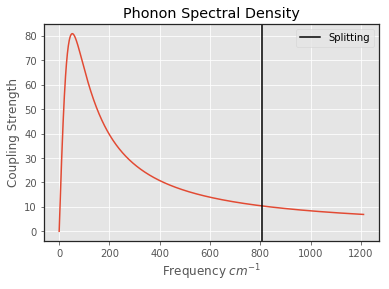

w_RC= 814.6155  TLS splitting = 806.55 RC-res. coupling= 2.49327083739  N= 5 TLS-RC coupling= 454.325296588 Gamma_RC=  12761.5079392 alpha_ph= 161.31 beta= 0.00479616306954
(0, 1) (1, 0)
Calculating non-RWA Liouvilliian took 0.124255180359 seconds.
It took  0.123713970184  seconds to build the Non-secular RWA Liouvillian
It took  0.124886989594  seconds to build the vibronic Lindblad Liouvillian
It took  0.00480389595032  seconds to build the electronic-Lindblad Liouvillian
Completed dynamics calculation 1 in 4.90795183182 seconds.
Completed dynamics calculation 2 in 3.75043702126 seconds.
Completed dynamics calculation 3 in 3.35310196877 seconds.
Completed dynamics calculation 4 in 3.25941896439 seconds.


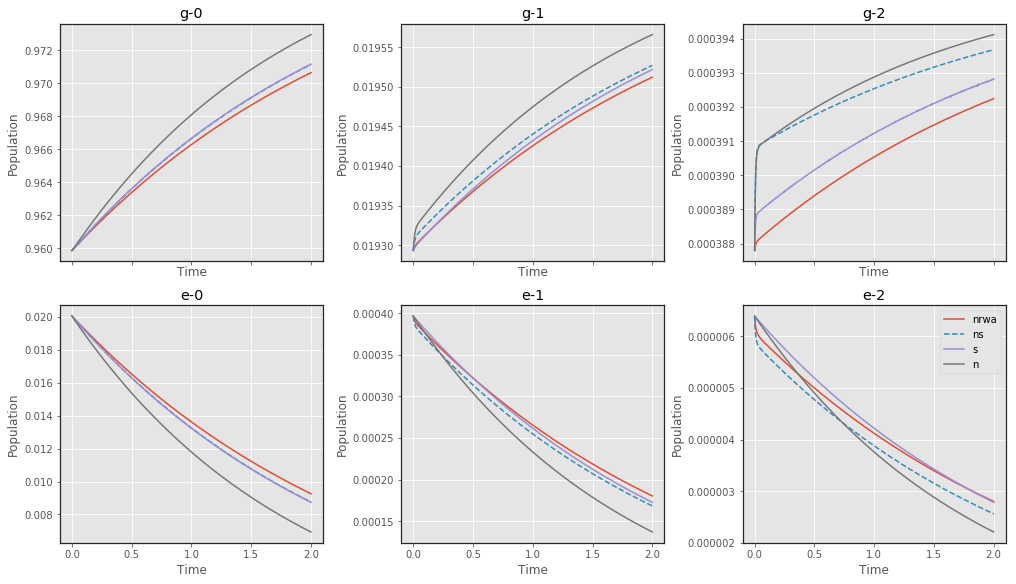

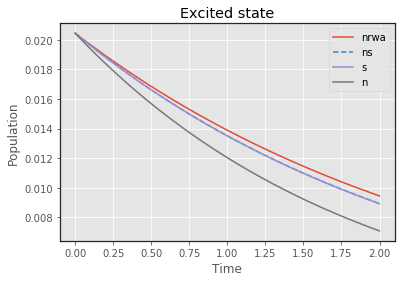

In [171]:
vibronic_state_dynamics((0,1), (1,0), 0.2, eps, 10., 0, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=True) # g1-e0

Initialising the system in a coherence state does absolutely nothing to the decay to population states. Now let's try the dynamics *into* coherences from diagonal population states.

# Vibronic coherence dynamics: initialised in population states

In [11]:
def vibronic_coherence_dynamics(init_sys, init_RC, prop_coupling, eps, Gamma, w0, T_ph=300., T_EM=6000., 
                                    Gamma_EM=1., overdamped=True, optical_off=False, w0_prop=1.01):
    # Start system+RC in adiabatic eigenstate and then time-evolve
    alpha_ph = prop_coupling*eps

    if overdamped:
        w0 = eps*w0_prop
        Gamma = w0**2/wc
        N = 15
    else:
        N=24
    w = np.linspace(0., eps*1.5, 1000)
    plt.figure()
    plt.plot(w, J_underdamped(w, alpha_ph, Gamma, w0))
    plt.axvline(eps, label='Splitting',color='k')
    plt.ylabel("Coupling Strength")
    plt.xlabel(r"Frequency $cm^{-1}$")
    plt.title("Phonon Spectral Density")
    plt.legend()
    plt.show()
    
    N = 9
    G = ket([0])
    E = ket([1])
    
    sigma = G*E.dag() # Definition of a sigma_- operator.
    J = EM.J_minimal
    count = 1
    I_RC = qt.qeye(N)
    labels = ['g0-g1',  'g0-g2', 'g1-g2','e0-e1','e0-e2','e1-e2']
    #labels += ['e0-g0',  'e0-g1', 'e0-g2','e1-g0','e1-g1','e1-g2']
    # This is true for specific Hamiltonian parameters
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dyn_DATA = []
    
    L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma= RC.RC_function_UD(sigma, eps, 
                                                                   T_ph, Gamma, 
                                                                   w0, alpha_ph, N)
    evals, states = H_RC.eigenstates()
    ground_list = []
    excited_list = []
    for i in range(len(evals)): #
        is_ground = sum(states[i])[0][0].real == 1.
        if is_ground:
            ground_list.append(i)
        else:
            excited_list.append(i)
    
    if init_sys == 0:
        init_ket = states[ground_list[init_RC]]
        init_rho = init_ket*init_ket.dag()
    elif init_sys==1:
        init_ket = states[excited_list[init_RC]]
        init_rho = init_ket*init_ket.dag()
    elif init_sys==10:
        init_ket = np.sqrt(2)*(states[excited_list[init_RC]]+states[ground_list[init_RC]])
        init_rho = init_ket*init_ket.dag()
    else:
        num = (-H_RC*beta_f(T_ph)).expm()
        init_rho =  num/num.tr()
    ground = [states[i] for i in ground_list]
    excited = [states[i] for i in excited_list]
    # labels = ['g0-g1',  'g0-g2', 'g1-g2','e0-e1','e0-e2','e1-e2']
    print excited_list
    expects_vib = [ground[0]*ground[1].dag(), ground[0]*ground[2].dag(), ground[1]*ground[2].dag()]
    expects_vib += [excited[0]*excited[1].dag(), excited[0]*excited[2].dag(), excited[1]*excited[2].dag()]
    
    #expects_vib += [excited[0]*ground[0].dag(), excited[0]*ground[1].dag(), excited[0]*ground[2].dag()]
    #expects_vib += [excited[1]*ground[0].dag(), excited[1]*ground[1].dag(), excited[1]*ground[2].dag()]
    expects_vib += [qt.tensor((E*G.dag()), qt.qeye(N))]
    #print len(excited_list), 'excited'
    # electromagnetic bath liouvillians
    L_nrwa = EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J)
    L_ns = EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J)
    L_s = EM.L_vib_lindblad(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J)
    L_n = EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J=J)
    Liouvs = [L_nrwa, L_ns, L_s, L_n]
    timelist = np.linspace(0,1.,900)
    options = qt.Options(nsteps=1500, num_cpus=2)
    if T_EM<1000:
        timelist = np.linspace(0,2.,1500)
        #options = qt.Options(nsteps=1500, num_cpus=3)
    for L_EM in Liouvs:
        ti = time.time()
        if optical_off:
            L = L_RC
        else:
            L = L_RC+L_EM
        dyn_DATA.append(mesolve(H_RC, init_rho, timelist, [L], expects_vib, options=options))
        print "Completed dynamics calculation {} in {} seconds.".format(Liouvs.index(L_EM)+1, time.time()-ti)
    
    
    f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', figsize=(14,8))
    
    #f, ((ax1, ax2, ax3), (ax4, ax5, ax6), 
    #    (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(4, 3, sharex='col', figsize=(14,16))
    axes = [eval("ax{}".format(i)) for i in range(1,len(labels)+1)]
    for i, lab in enumerate(labels):
        
        #init_state_final_pop_0 = dyn_DATA[0].expect[(3*init_sys+init_RC)][-1] # naive
        #init_state_final_pop_1 = dyn_DATA[1].expect[(3*init_sys+init_RC)][-1] # nrwa
        #init_state_final_pop_2 = dyn_DATA[2].expect[(3*init_sys+init_RC)][-1] # ns
        #init_state_final_pop_3 = dyn_DATA[3].expect[(3*init_sys+init_RC)][-1] # s
        axes[i].set_title(lab)
        axes[i].plot(timelist, dyn_DATA[0].expect[i], label='nrwa')
        axes[i].plot(timelist, dyn_DATA[1].expect[i], label='ns', linestyle='dashed')
        axes[i].plot(timelist, dyn_DATA[2].expect[i], label='s')
        axes[i].plot(timelist, dyn_DATA[3].expect[i], label='n')
        #plt.grid()
        axes[i].set(xlabel=r"Time", ylabel="Coherence")
        #axes[i].label_outer()
        
        #print "{} state accounts for".format(lab)
        #print "NRWA: {:0.4f}%".format(100*(dyn_DATA[0].expect[i][-1]/init_state_final_pop_0))
        #print "NS: {:0.4f}%" .format(100*(dyn_DATA[1].expect[i][-1]/init_state_final_pop_1))
        #print "Naive: {:0.4f}% of total dynamics".format(100*(dyn_DATA[2].expect[i][-1]/init_state_final_pop_2))
        #print "Naive: {:0.4f}% of total dynamics".format(100*(dyn_DATA[3].expect[i][-1]/init_state_final_pop_3))
    plt.tight_layout(pad=0.3, w_pad=0.3, h_pad=1.0)
    plt.legend()
    """
    plt.figure()
    plt.title("E-G")
    plt.plot(timelist, dyn_DATA[0].expect[-1], label='nrwa')
    plt.plot(timelist, dyn_DATA[1].expect[-1], label='ns', linestyle='dashed')
    plt.plot(timelist, dyn_DATA[2].expect[-1], label='s')
    plt.plot(timelist, dyn_DATA[3].expect[-1], label='n')
    plt.legend()
    plt.ylabel("Population")
    plt.xlabel(r"Time")
    """
    plt.show()

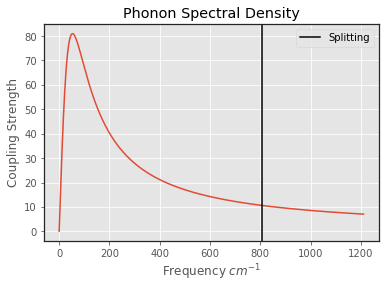

w_RC= 814.6155  TLS splitting = 806.55 RC-res. coupling= 2.4462279914  N= 9 TLS-RC coupling= 454.325296588 Gamma_RC=  12520.7247706 alpha_ph= 161.31 beta= 0.00479616306954
[1, 3, 5, 7, 9, 12, 14, 16, 17]
Calculating non-RWA Liouvilliian took 0.200142145157 seconds.
It took  0.275090932846  seconds to build the Non-secular RWA Liouvillian
It took  0.298882007599  seconds to build the vibronic Lindblad Liouvillian
It took  0.00260615348816  seconds to build the electronic-Lindblad Liouvillian
Completed dynamics calculation 1 in 12.7069978714 seconds.
Completed dynamics calculation 2 in 11.1382889748 seconds.
Completed dynamics calculation 3 in 9.34599399567 seconds.
Completed dynamics calculation 4 in 8.61001205444 seconds.


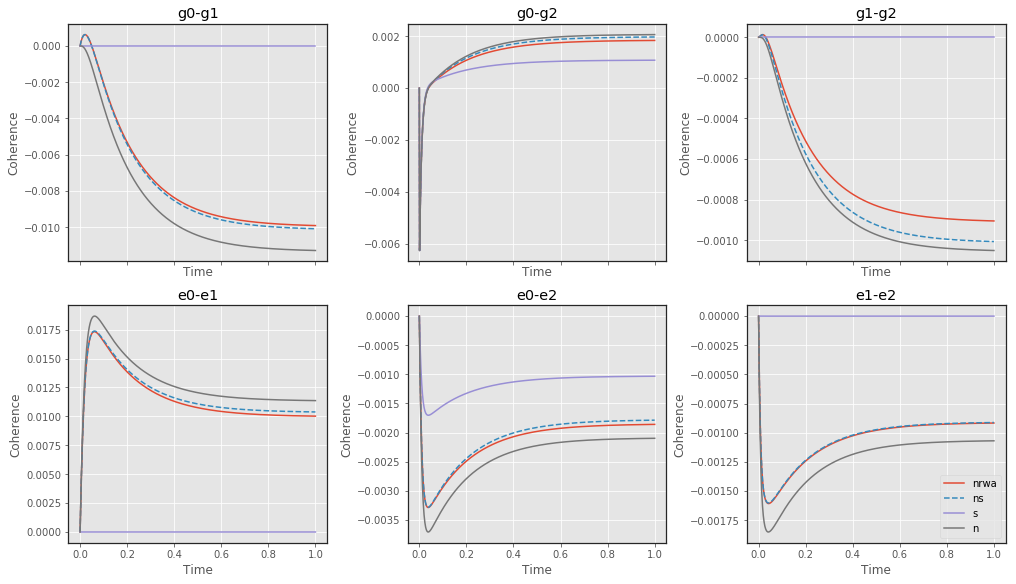

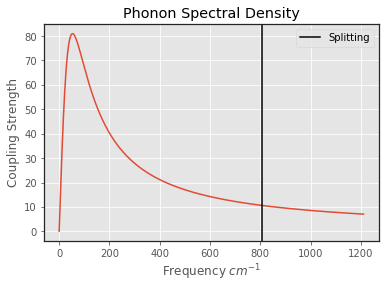

w_RC= 814.6155  TLS splitting = 806.55 RC-res. coupling= 2.4462279914  N= 9 TLS-RC coupling= 454.325296588 Gamma_RC=  12520.7247706 alpha_ph= 161.31 beta= 0.00479616306954
[1, 3, 5, 7, 9, 12, 14, 16, 17]
Calculating non-RWA Liouvilliian took 0.195820093155 seconds.
It took  0.26112985611  seconds to build the Non-secular RWA Liouvillian
It took  0.291073083878  seconds to build the vibronic Lindblad Liouvillian
It took  0.00264501571655  seconds to build the electronic-Lindblad Liouvillian
Completed dynamics calculation 1 in 24.9383759499 seconds.
Completed dynamics calculation 2 in 19.9715669155 seconds.
Completed dynamics calculation 3 in 18.0388789177 seconds.
Completed dynamics calculation 4 in 17.1431541443 seconds.


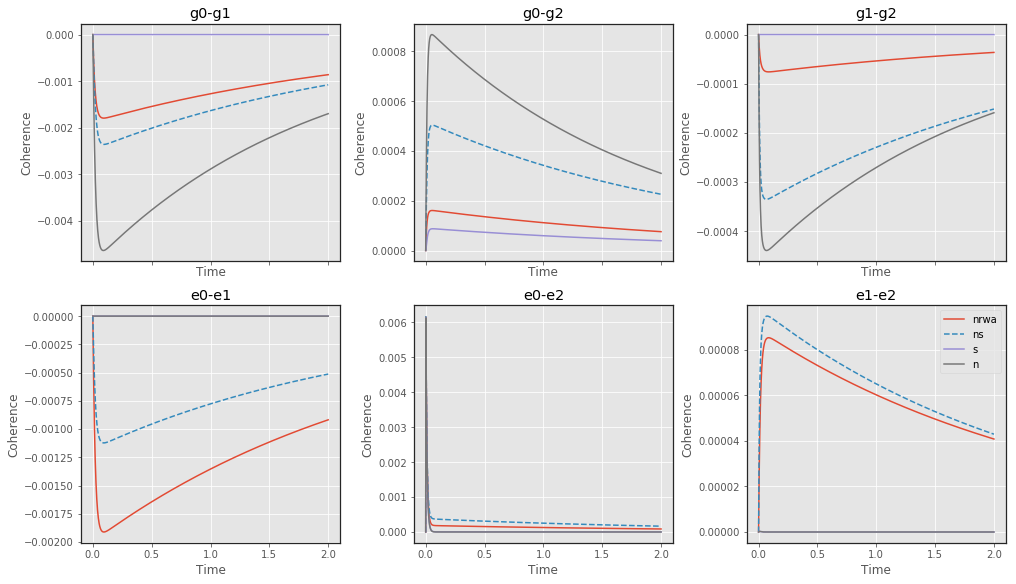

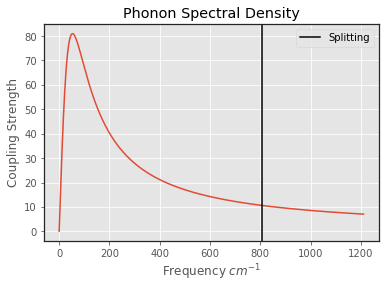

w_RC= 814.6155  TLS splitting = 806.55 RC-res. coupling= 2.4462279914  N= 9 TLS-RC coupling= 454.325296588 Gamma_RC=  12520.7247706 alpha_ph= 161.31 beta= 0.00479616306954
[1, 3, 5, 7, 9, 12, 14, 16, 17]
Calculating non-RWA Liouvilliian took 0.19633102417 seconds.
It took  0.269699811935  seconds to build the Non-secular RWA Liouvillian
It took  0.289948940277  seconds to build the vibronic Lindblad Liouvillian
It took  0.00255703926086  seconds to build the electronic-Lindblad Liouvillian
Completed dynamics calculation 1 in 8.52433300018 seconds.
Completed dynamics calculation 2 in 8.51467609406 seconds.
Completed dynamics calculation 3 in 8.47510409355 seconds.
Completed dynamics calculation 4 in 8.43660998344 seconds.


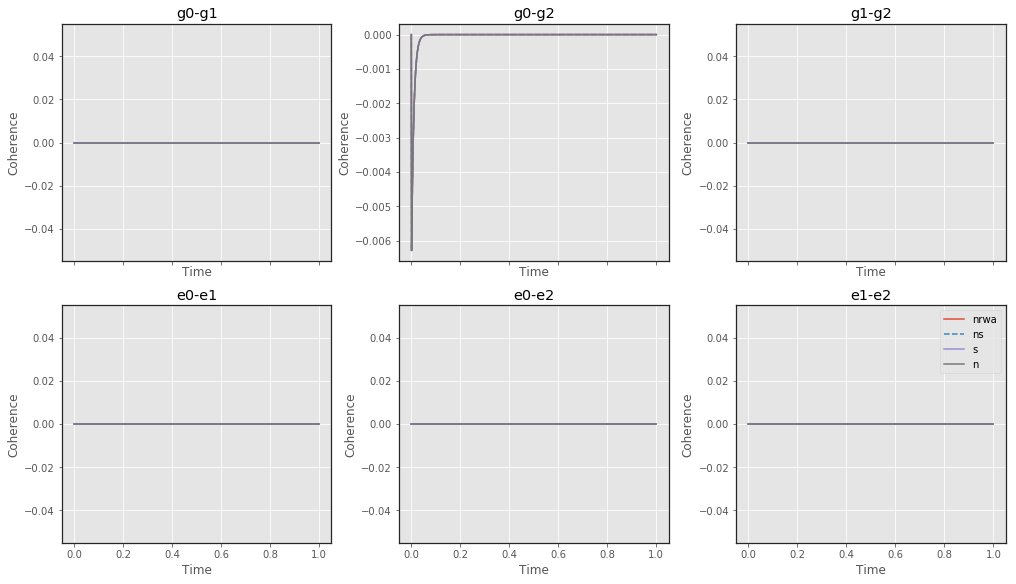

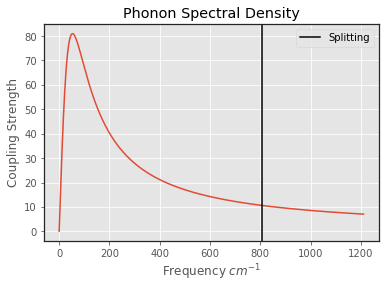

w_RC= 814.6155  TLS splitting = 806.55 RC-res. coupling= 2.4462279914  N= 9 TLS-RC coupling= 454.325296588 Gamma_RC=  12520.7247706 alpha_ph= 161.31 beta= 0.00479616306954
[1, 3, 5, 7, 9, 12, 14, 16, 17]
Calculating non-RWA Liouvilliian took 0.195043087006 seconds.
It took  0.266580104828  seconds to build the Non-secular RWA Liouvillian
It took  0.292977809906  seconds to build the vibronic Lindblad Liouvillian
It took  0.00266003608704  seconds to build the electronic-Lindblad Liouvillian
Completed dynamics calculation 1 in 16.7406930923 seconds.
Completed dynamics calculation 2 in 16.9349000454 seconds.
Completed dynamics calculation 3 in 16.8672420979 seconds.
Completed dynamics calculation 4 in 16.6877758503 seconds.


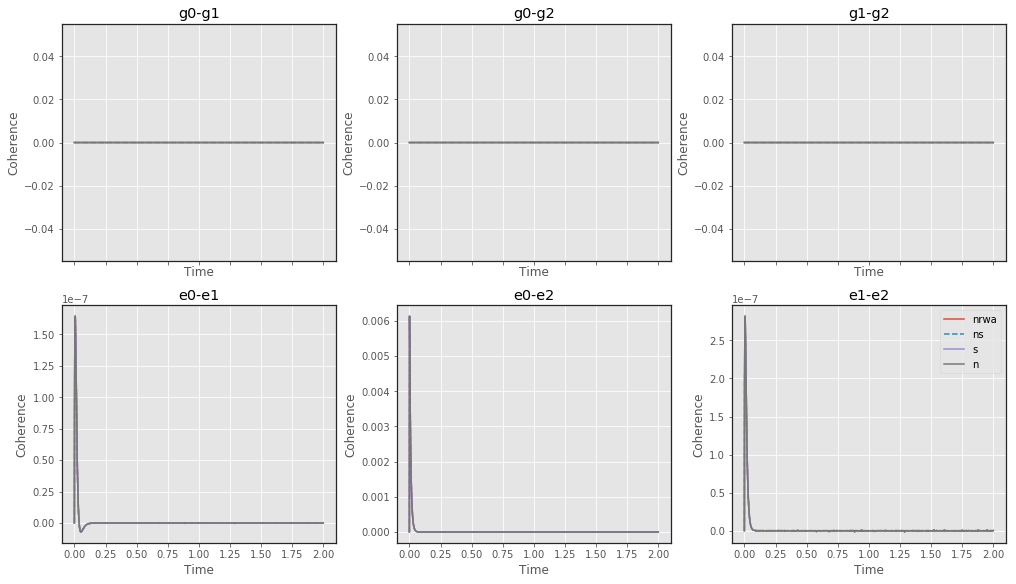

In [10]:
vibronic_coherence_dynamics(0, 0, 0.2, eps, 10., 0, T_ph=300., T_EM=6000., 
                                    Gamma_EM=Gamma_EM, overdamped=True)
vibronic_coherence_dynamics(1, 0, 0.2, eps, 10., 0, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=True)

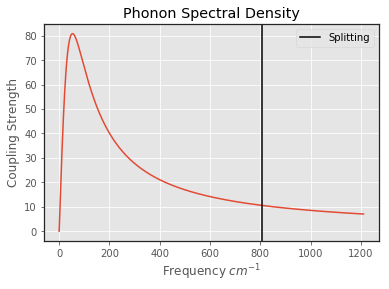

w_RC= 1209.825  TLS splitting = 806.55 RC-res. coupling= 3.63301186842  N= 9 TLS-RC coupling= 553.6711079 Gamma_RC=  27616.5383137 alpha_ph= 161.31 beta= 0.00479616306954
[1, 3, 5, 7, 9, 11, 13, 16, 17]
Calculating non-RWA Liouvilliian took 0.191921949387 seconds.
It took  0.262481927872  seconds to build the Non-secular RWA Liouvillian
It took  0.303269863129  seconds to build the vibronic Lindblad Liouvillian
It took  0.00314092636108  seconds to build the electronic-Lindblad Liouvillian
Completed dynamics calculation 1 in 51.7509670258 seconds.
Completed dynamics calculation 2 in 39.188616991 seconds.
Completed dynamics calculation 3 in 37.5303630829 seconds.
Completed dynamics calculation 4 in 36.6582241058 seconds.


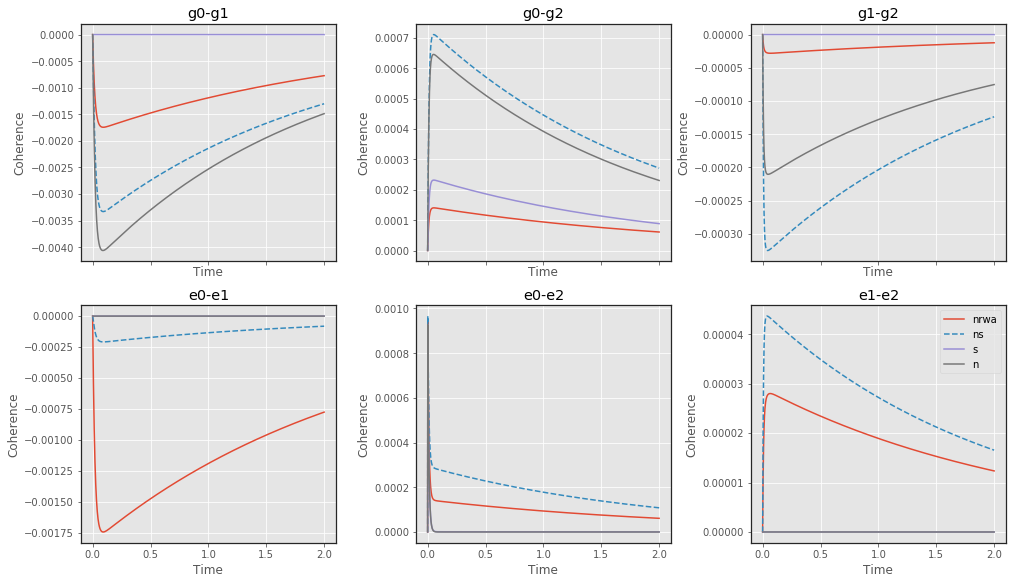

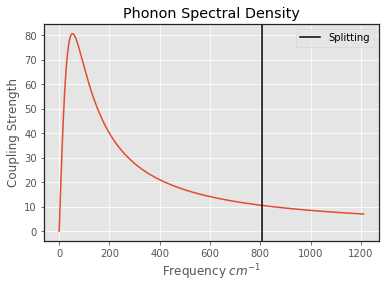

w_RC= 1613.1  TLS splitting = 806.55 RC-res. coupling= 4.84401582456  N= 9 TLS-RC coupling= 639.324326377 Gamma_RC=  49096.0681132 alpha_ph= 161.31 beta= 0.00479616306954
[1, 3, 5, 7, 9, 11, 13, 15, 17]
Calculating non-RWA Liouvilliian took 0.215118169785 seconds.
It took  0.268081903458  seconds to build the Non-secular RWA Liouvillian
It took  0.293807983398  seconds to build the vibronic Lindblad Liouvillian
It took  0.00445508956909  seconds to build the electronic-Lindblad Liouvillian
Completed dynamics calculation 1 in 83.5452480316 seconds.
Completed dynamics calculation 2 in 62.8724899292 seconds.
Completed dynamics calculation 3 in 61.4382970333 seconds.
Completed dynamics calculation 4 in 57.5432009697 seconds.


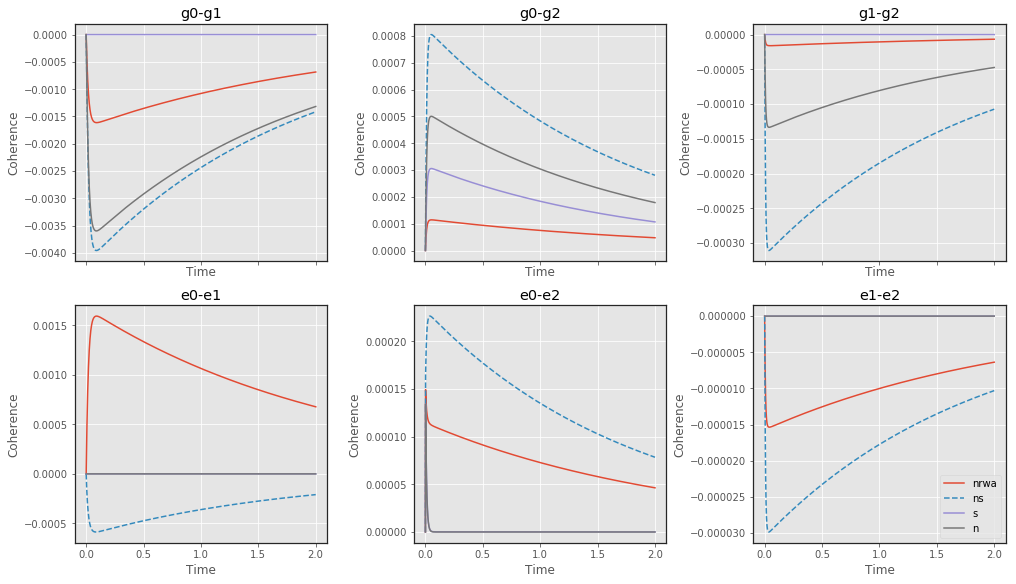

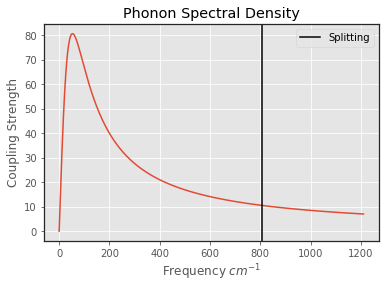

w_RC= 2016.375  TLS splitting = 806.55 RC-res. coupling= 6.0550197807  N= 9 TLS-RC coupling= 714.786326724 Gamma_RC=  76712.6064269 alpha_ph= 161.31 beta= 0.00479616306954
[1, 3, 5, 7, 9, 11, 13, 15, 17]
Calculating non-RWA Liouvilliian took 0.195505142212 seconds.
It took  0.422518968582  seconds to build the Non-secular RWA Liouvillian
It took  0.354385852814  seconds to build the vibronic Lindblad Liouvillian
It took  0.00259494781494  seconds to build the electronic-Lindblad Liouvillian


/home/henry/anaconda2/envs/qutip/lib/python2.7/site-packages/scipy/integrate/_ode.py:869: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  'Unexpected istate=%s' % istate))


Exception: ODE integration error: Try to increase the allowed number of substeps by increasing the nsteps parameter in the Options class.

In [13]:
vibronic_coherence_dynamics(1, 0, 0.2, eps, 10., 0, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=True, w0_prop=1.5)
vibronic_coherence_dynamics(1, 0, 0.2, eps, 10., 0, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=True, w0_prop=2.0)
vibronic_coherence_dynamics(1, 0, 0.2, eps, 10., 0, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=True, w0_prop=2.5)

The above calculations show very similar coherence dynamics in the excited manifold for non-sec and non-RWA in short times. The naive approach also has qualititavely similar effects in many instances. This will be due to the accumulation of coherences incidentally due to it's inability to see the manifolds. The secular approach sometimes does generate coherences, which shouldn't occur from the EM map, however can occur from phonons. It doesn't seem to be a lack of convergence but it could be a coding bug, although I don't see how. I've calculated the same figures but without the optical part to see if it's phonon generated. On very short timescales there are spikes of vibronic coherences generated within the manifold that the excitation is initially localised on. These spikes tend to occur between the zeroth and second vibrational excitation states. Could check to see if this occurs still if the system is prepared in $|g; 1\rangle$ etc.

The final thing is that coherences are only generated between vibronic states on the same manifold and not between manifolds. This is very strange, as the optical field cannot cause transitions between states on the same manifold. Why is it that the optical environment can cause superpositions between say e-0 and e-1, but not between e-0 and g-1?

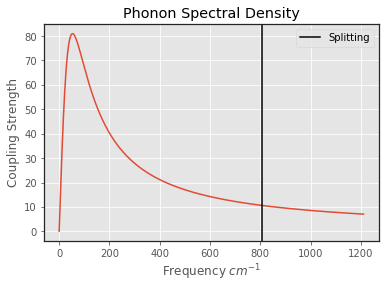

w_RC= 814.6155  TLS splitting = 806.55 RC-res. coupling= 2.4462279914  N= 9 TLS-RC coupling= 454.325296588 Gamma_RC=  12520.7247706 alpha_ph= 161.31 beta= 0.00479616306954
[1, 3, 5, 7, 9, 12, 14, 16, 17]
Calculating non-RWA Liouvilliian took 0.214691162109 seconds.
It took  0.3178358078  seconds to build the Non-secular RWA Liouvillian
It took  0.449137926102  seconds to build the vibronic Lindblad Liouvillian
It took  0.00374007225037  seconds to build the electronic-Lindblad Liouvillian
Completed dynamics calculation 1 in 20.9976329803 seconds.
Completed dynamics calculation 2 in 23.665033102 seconds.
Completed dynamics calculation 3 in 19.3511419296 seconds.
Completed dynamics calculation 4 in 19.0508229733 seconds.


/home/henry/anaconda2/envs/qutip/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


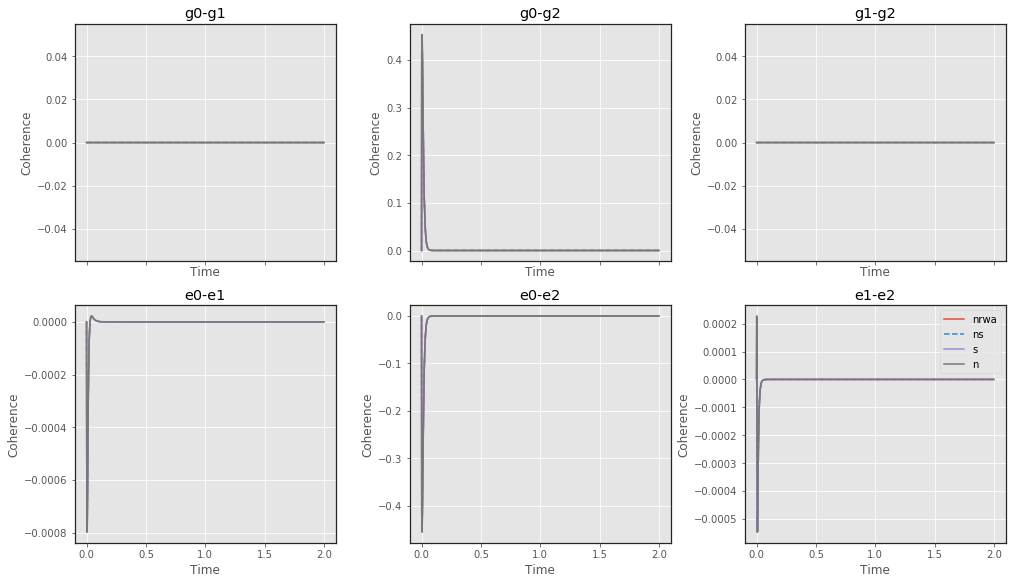

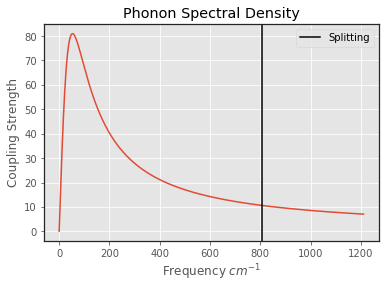

w_RC= 814.6155  TLS splitting = 806.55 RC-res. coupling= 2.4462279914  N= 9 TLS-RC coupling= 454.325296588 Gamma_RC=  12520.7247706 alpha_ph= 161.31 beta= 0.00479616306954
[1, 3, 5, 7, 9, 12, 14, 16, 17]
Calculating non-RWA Liouvilliian took 0.260719060898 seconds.
It took  0.411556005478  seconds to build the Non-secular RWA Liouvillian
It took  0.458106994629  seconds to build the vibronic Lindblad Liouvillian
It took  0.0059449672699  seconds to build the electronic-Lindblad Liouvillian
Completed dynamics calculation 1 in 9.00941801071 seconds.
Completed dynamics calculation 2 in 9.28383016586 seconds.
Completed dynamics calculation 3 in 8.56137704849 seconds.
Completed dynamics calculation 4 in 8.50934195518 seconds.


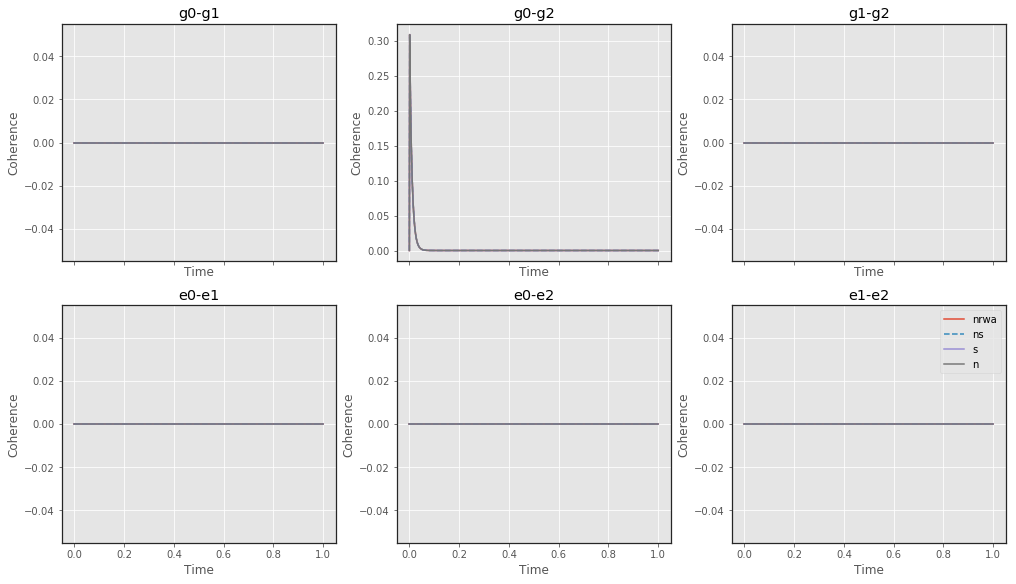

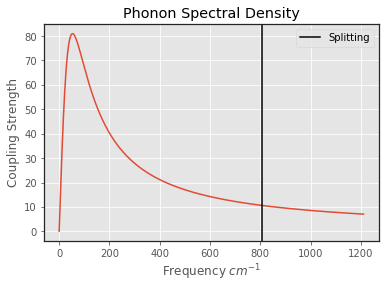

w_RC= 814.6155  TLS splitting = 806.55 RC-res. coupling= 2.4462279914  N= 9 TLS-RC coupling= 454.325296588 Gamma_RC=  12520.7247706 alpha_ph= 161.31 beta= 0.00479616306954
[1, 3, 5, 7, 9, 12, 14, 16, 17]
Calculating non-RWA Liouvilliian took 0.196796178818 seconds.
It took  0.271709918976  seconds to build the Non-secular RWA Liouvillian
It took  0.292695999146  seconds to build the vibronic Lindblad Liouvillian
It took  0.00253009796143  seconds to build the electronic-Lindblad Liouvillian
Completed dynamics calculation 1 in 8.4551680088 seconds.
Completed dynamics calculation 2 in 8.50802898407 seconds.
Completed dynamics calculation 3 in 8.42491102219 seconds.
Completed dynamics calculation 4 in 8.49687314034 seconds.


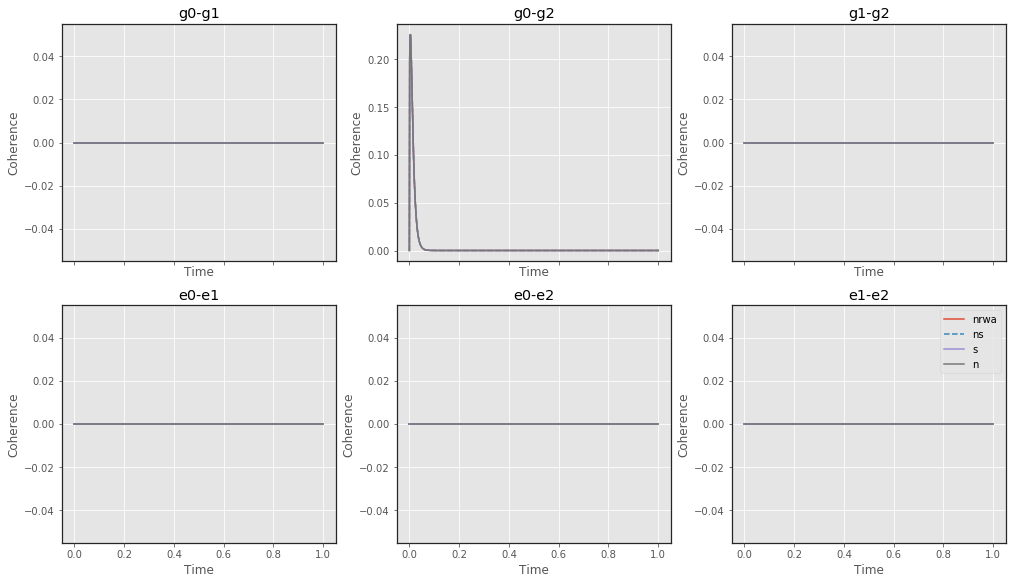

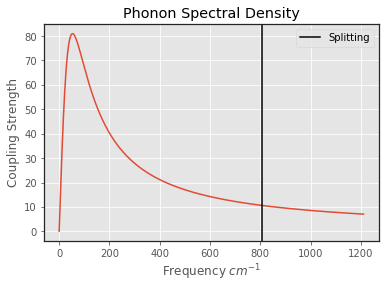

w_RC= 814.6155  TLS splitting = 806.55 RC-res. coupling= 2.4462279914  N= 9 TLS-RC coupling= 454.325296588 Gamma_RC=  12520.7247706 alpha_ph= 161.31 beta= 0.00479616306954
[1, 3, 5, 7, 9, 12, 14, 16, 17]
Calculating non-RWA Liouvilliian took 0.193871021271 seconds.
It took  0.261906147003  seconds to build the Non-secular RWA Liouvillian
It took  0.293545007706  seconds to build the vibronic Lindblad Liouvillian
It took  0.00250792503357  seconds to build the electronic-Lindblad Liouvillian
Completed dynamics calculation 1 in 16.4953668118 seconds.
Completed dynamics calculation 2 in 16.7532250881 seconds.
Completed dynamics calculation 3 in 16.6969377995 seconds.
Completed dynamics calculation 4 in 16.6940510273 seconds.


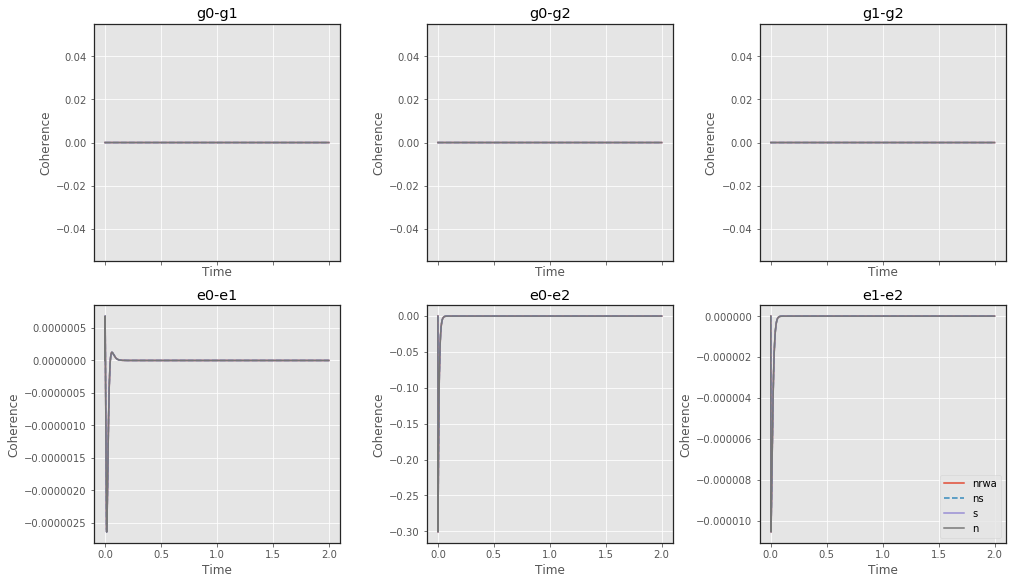

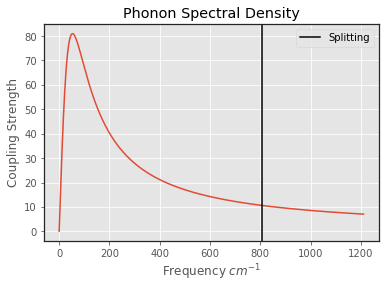

w_RC= 814.6155  TLS splitting = 806.55 RC-res. coupling= 2.4462279914  N= 9 TLS-RC coupling= 454.325296588 Gamma_RC=  12520.7247706 alpha_ph= 161.31 beta= 0.00479616306954
[1, 3, 5, 7, 9, 12, 14, 16, 17]
Calculating non-RWA Liouvilliian took 0.194473028183 seconds.
It took  0.26175904274  seconds to build the Non-secular RWA Liouvillian
It took  0.286311149597  seconds to build the vibronic Lindblad Liouvillian
It took  0.00254988670349  seconds to build the electronic-Lindblad Liouvillian
Completed dynamics calculation 1 in 16.8045890331 seconds.
Completed dynamics calculation 2 in 16.6013200283 seconds.
Completed dynamics calculation 3 in 16.6950068474 seconds.
Completed dynamics calculation 4 in 16.4896159172 seconds.


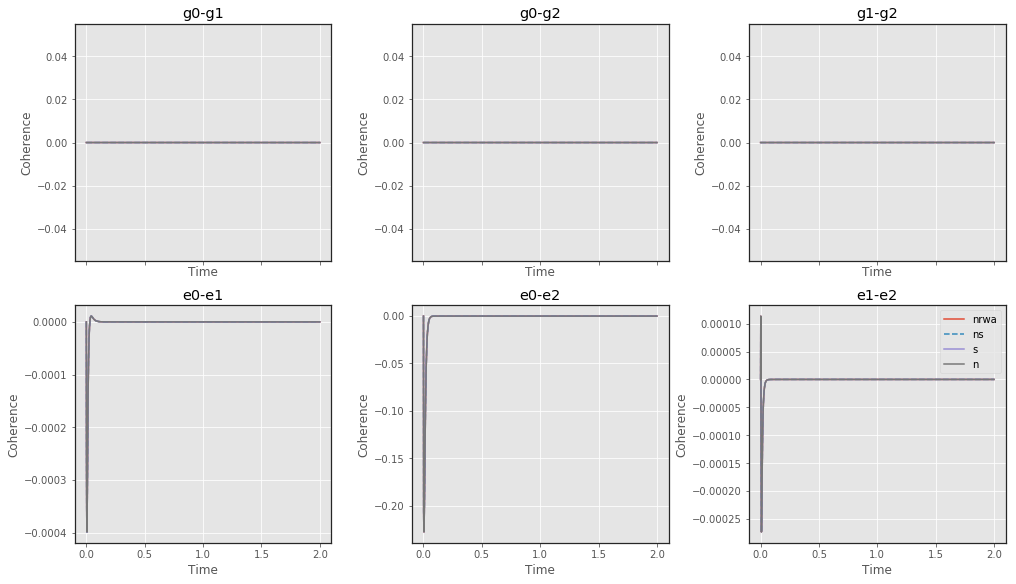

In [8]:
vibronic_coherence_dynamics(10, 2, 0.2, eps, 10., 0, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=True, optical_off=True)
vibronic_coherence_dynamics(0, 1, 0.2, eps, 10., 0, T_ph=300., T_EM=6000., 
                                    Gamma_EM=Gamma_EM, overdamped=True, optical_off=True)
vibronic_coherence_dynamics(0, 2, 0.2, eps, 10., 0, T_ph=300., T_EM=6000., 
                                    Gamma_EM=Gamma_EM, overdamped=True, optical_off=True)
vibronic_coherence_dynamics(1, 1, 0.2, eps, 10., 0, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=True, optical_off=True)
vibronic_coherence_dynamics(1, 2, 0.2, eps, 10., 0, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=True, optical_off=True)


So above, we can see that there is rapid coherence generation on short timescales, on the manifold(s) which the systems is started on. It seems like coherence is generated on the excited manifold more readily, possibly because the bath is only coupled to the excited state. Another thing is that the coherence dynamics don't seem to depend strongly on *which* vibrational state the system starts in - it is always the e0-e2 and g0-g2 transitions which are 
How about when the system does not have a non-equilibrium steady state?

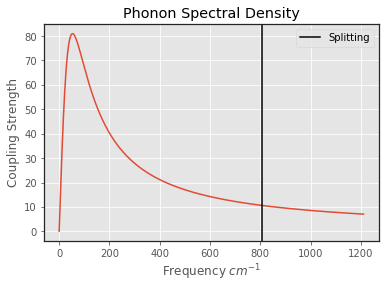

w_RC= 814.6155  TLS splitting = 806.55 RC-res. coupling= 2.4462279914  N= 9 TLS-RC coupling= 454.325296588 Gamma_RC=  12520.7247706 alpha_ph= 161.31 beta= 0.00479616306954
[1, 3, 5, 7, 9, 12, 14, 16, 17]
Calculating non-RWA Liouvilliian took 0.278502941132 seconds.
It took  0.269783973694  seconds to build the Non-secular RWA Liouvillian
It took  0.292906999588  seconds to build the vibronic Lindblad Liouvillian
It took  0.00262904167175  seconds to build the electronic-Lindblad Liouvillian
Completed dynamics calculation 1 in 26.3432619572 seconds.
Completed dynamics calculation 2 in 22.6368229389 seconds.
Completed dynamics calculation 3 in 19.0049338341 seconds.
Completed dynamics calculation 4 in 17.656845808 seconds.


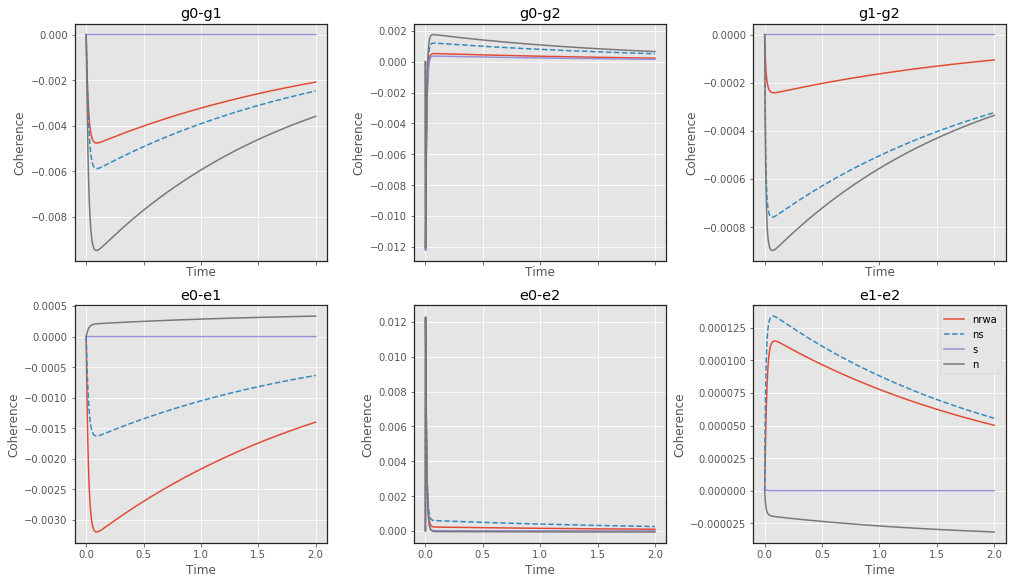

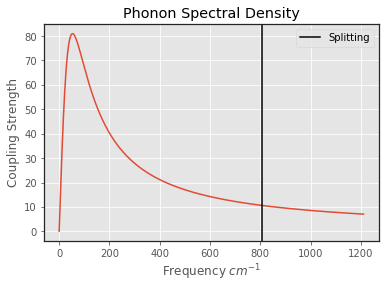

w_RC= 814.6155  TLS splitting = 806.55 RC-res. coupling= 2.4462279914  N= 9 TLS-RC coupling= 454.325296588 Gamma_RC=  12520.7247706 alpha_ph= 161.31 beta= 0.00479616306954
[1, 3, 5, 7, 9, 12, 14, 16, 17]
Calculating non-RWA Liouvilliian took 0.196196079254 seconds.
It took  0.271471977234  seconds to build the Non-secular RWA Liouvillian
It took  0.289206981659  seconds to build the vibronic Lindblad Liouvillian
It took  0.00257682800293  seconds to build the electronic-Lindblad Liouvillian
Completed dynamics calculation 1 in 30.0746099949 seconds.
Completed dynamics calculation 2 in 21.9902780056 seconds.
Completed dynamics calculation 3 in 18.6435739994 seconds.
Completed dynamics calculation 4 in 17.2919101715 seconds.


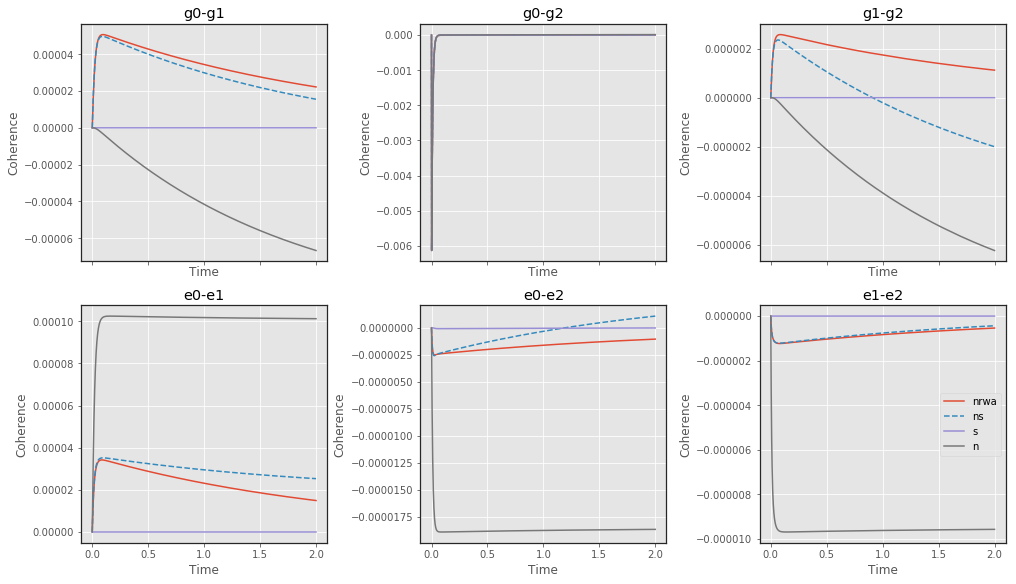

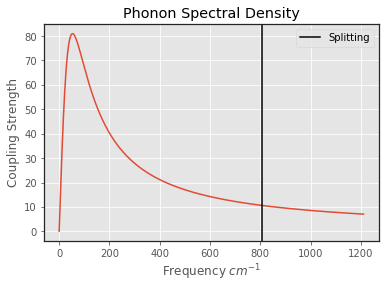

w_RC= 814.6155  TLS splitting = 806.55 RC-res. coupling= 2.4462279914  N= 9 TLS-RC coupling= 454.325296588 Gamma_RC=  12520.7247706 alpha_ph= 161.31 beta= 0.00479616306954
[1, 3, 5, 7, 9, 12, 14, 16, 17]
Calculating non-RWA Liouvilliian took 0.18791103363 seconds.
It took  0.266973018646  seconds to build the Non-secular RWA Liouvillian
It took  0.288666009903  seconds to build the vibronic Lindblad Liouvillian
It took  0.00256586074829  seconds to build the electronic-Lindblad Liouvillian
Completed dynamics calculation 1 in 25.1113920212 seconds.
Completed dynamics calculation 2 in 21.974807024 seconds.
Completed dynamics calculation 3 in 18.3770329952 seconds.
Completed dynamics calculation 4 in 17.0023181438 seconds.


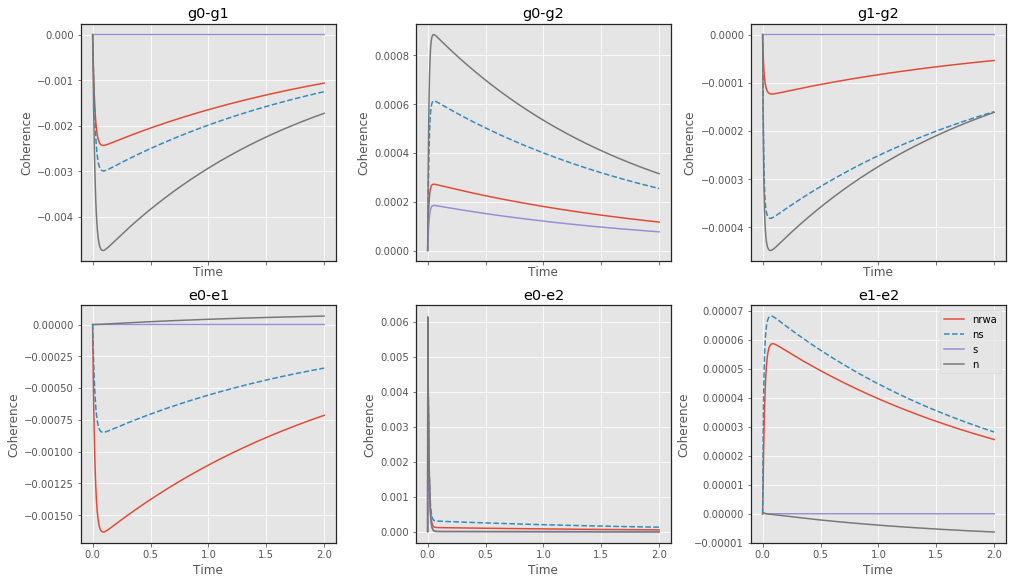

In [9]:
vibronic_coherence_dynamics(10, 0, 0.2, eps, 10., 0, T_ph=300., T_EM=300., 
                                    Gamma_EM=Gamma_EM, overdamped=True)
vibronic_coherence_dynamics(0, 0, 0.2, eps, 10., 0, T_ph=300., T_EM=300., 
                                    Gamma_EM=Gamma_EM, overdamped=True)
vibronic_coherence_dynamics(1, 0, 0.2, eps, 10., 0, T_ph=300., T_EM=300., 
                                    Gamma_EM=Gamma_EM, overdamped=True)

FROM note-bank:
To see whether it was the non-equilibrium nature of the problem which was causing the coherences in the secular case, I made the baths the same temperature. When starting this system in the ground state (this is more like the steady state, also the ground manifold is not coupled to the vibrational bath so likely to), the only coherences which are generated are the ones which also exist for no optical bath (spiking in g0-g2). Starting in excited state: g0-g2 still generates coherences as before, but e0-e2 spikes like the no optical bath case. This could be due to the fact that initially e0 is far from the steadystate of the system. This phenomenologically (potenitally) explains the dynamics, but I don't understand WHY the non-equilibrium properties would be causing this.

## Off-diagonal decay rates: $\alpha_{ph}$ dependence

In [14]:
def state_string(init_sys, init_RC):
    sys_str = []
    for i in init_sys:
        if i == 0:
            sys_str.append('g')
        elif i ==1:
            sys_str.append('e')
    return '|{};{}><{};{}|'.format(sys_str[0], init_RC[0], sys_str[1], init_RC[1])
print state_string((1,0), (1,0))

|e;1><g;0|


In [19]:
from qutip import qeye, tensor
from qutip import vector_to_operator, operator_to_vector, basis

def off_diag_decay_rate_alpha(init_sys, init_RC, eps, T_ph, w0_prop=3.1, overdamped=True, nvib=5, T_EM=0.):
    alpha_props = np.linspace(0.001,1.5,30)
    alpha_ph = alpha_props*eps
    w0 = w0_prop*eps
    N = 13
    if overdamped:
        Gamma_ = w0**2/wc
    else:
        Gamma_ = 60.
    decay_wrt_alpha = [[],[],[],[]]
    count = 1
    for alpha_ in alpha_ph:
        
        L_RC, H, A_EM, A_nrwa, wRC, kappa, Gamma_1 = RC.RC_function_UD(sigma, eps, T_ph, 
                                                                       Gamma_, w0, alpha_, 
                                                                       N, silent=True)
    # given some Liouvillian, find the instantaneous decay rates
    # from e-0 to the ground manifold eigenstates, for several
    # oscillator displacements
    # - need to find the first eigenstate in the excited manifold
        evals, states = H.eigenstates()
        ground_list = []
        excited_list = []
        concat_list = [ground_list, excited_list]
        for i in range(len(evals)): #
            is_ground = sum(states[i])[0][0].real == 1.
            if is_ground:
                ground_list.append(i)
            else:
                excited_list.append(i)
        excited_ket = states[excited_list[0]]
        if type(init_sys) == tuple:
        #coherence state
            if type(init_RC) == tuple:
                # take in a 2-tuple to initialise in coherence state.
                rho_left = states[concat_list[init_sys[0]][init_RC[0]]]
                rho_right = states[concat_list[init_sys[1]][init_RC[1]]].dag()
                init_rho = rho_left*rho_right
                
            else:
                raise ValueError
        elif init_sys == 0:
            # population state
            init_rho = states[ground_list[init_RC]]*states[ground_list[init_RC]].dag()
        elif init_sys==1:
            init_rho = states[excited_list[init_RC]]*states[excited_list[init_RC]].dag()
        else:
            # if in neither ground or excited
            # for the minute, do nothing. This'll be fixed below.
            pass
        ground = [states[j] for j in ground_list]
        excited = [states[j] for j in excited_list]
        expects_vib = []
        labels = ['g0-g1',  'g0-g2', 'e0-e1','e0-e2'] # coherences
        expects_vib = [ground[0]*ground[1].dag(), ground[0]*ground[2].dag(),
                       excited[0]*excited[1].dag(), excited[0]*excited[2].dag()]
        labels += ['g1-e0',  'g1-g2', 'e1-e3','g1-g3'] # other interesting coherences
        expects_vib += [ground[1]*excited[0].dag(), ground[1]*ground[2].dag(),
                        excited[1]*excited[3].dag(), ground[1]*ground[3].dag()]
        labels += ['g0', 'g1', 'e0', 'ground'] # populations
        expects_vib += [ground[0]*ground[1].dag(), ground[1]*ground[1].dag(),
                       excited[0]*excited[0].dag(), tensor(G*G.dag(), qeye(N))]
        L= [EM.L_non_rwa(H, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM, silent=True), 
            EM.L_nonsecular(H, A_EM, eps, Gamma_EM, T_EM, J=J_EM, silent=True),
            EM.L_vib_lindblad(H, A_EM, eps, Gamma_EM, T_EM, J=J_EM, silent=True),
            EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J=J_EM, silent=True)]
        for i_, L_EM in enumerate(L):
            decay_rates = []
            L_rho0_prod = vector_to_operator(L_EM*operator_to_vector(init_rho))
            for j in range(len(expects_vib)): 
                rate = (expects_vib[j]*L_rho0_prod).tr()
                decay_rates.append(abs(rate))
            decay_wrt_alpha[i_].append(decay_rates)
        if count ==1 or count%5==0:
            print "{:0.2f}% finished".format((float(count)/len(alpha_ph))*100)
        count+=1
    print "Initial state is"+state_string(init_sys, init_RC)
    #f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', figsize=(14,8))
    f, ((ax1, ax2, ax3), (ax4, ax5, ax6), 
        (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(4, 3, sharex='col', figsize=(14,16))
    axes = [eval("ax{}".format(i)) for i in range(1,13)]
    for i in range(len(expects_vib)): # each level of interest
        axes[i].set_title(labels[i])
        axes[i].plot(alpha_props,np.array(decay_wrt_alpha[0]).T[i], label='non-RWA')
        axes[i].plot(alpha_props,np.array(decay_wrt_alpha[1]).T[i], label='non-sec', linestyle='dashed')
        axes[i].plot(alpha_props,np.array(decay_wrt_alpha[2]).T[i], label='sec')
        axes[i].plot(alpha_props,np.array(decay_wrt_alpha[3]).T[i], label='naive')
        axes[i].set(xlabel=r"Coupling strength (units of $\epsilon$)", 
               ylabel="Decay rate")
    plt.tight_layout(pad=0.3, w_pad=0.3, h_pad=1.0)
    plt.legend()
    plt.show()
    #return alpha_ph, decay_wrt_alpha

e0, T=0.
3.33% finished
16.67% finished
33.33% finished
50.00% finished
66.67% finished
83.33% finished
100.00% finished
Initial state is|e;0><e;0|


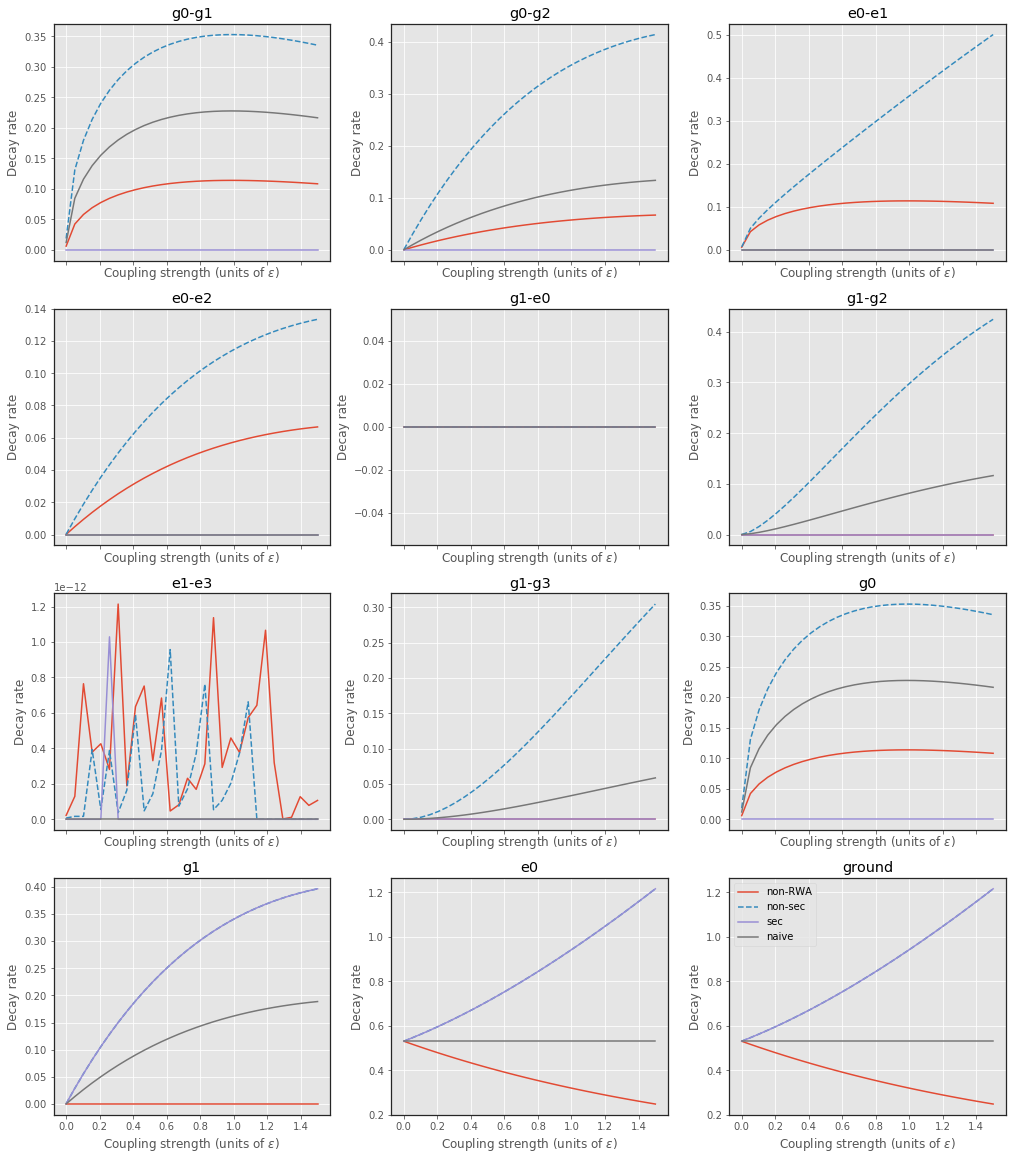

g0 T=6000
3.33% finished
16.67% finished
33.33% finished
50.00% finished
66.67% finished
83.33% finished
100.00% finished
Initial state is|g;0><g;0|


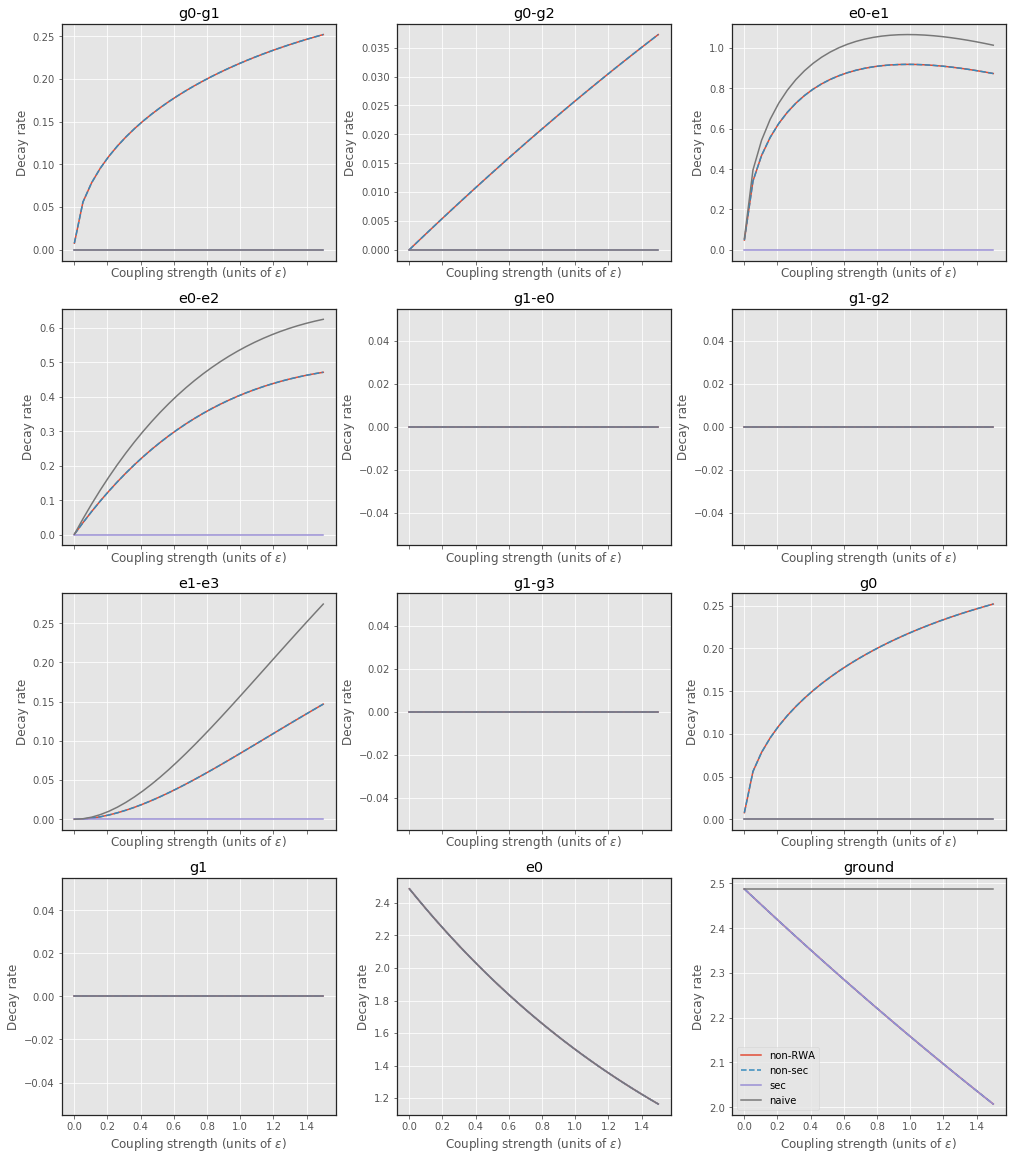

e0-e1 T=0.
3.33% finished
16.67% finished
33.33% finished
50.00% finished
66.67% finished
83.33% finished
100.00% finished
Initial state is|e;0><e;1|


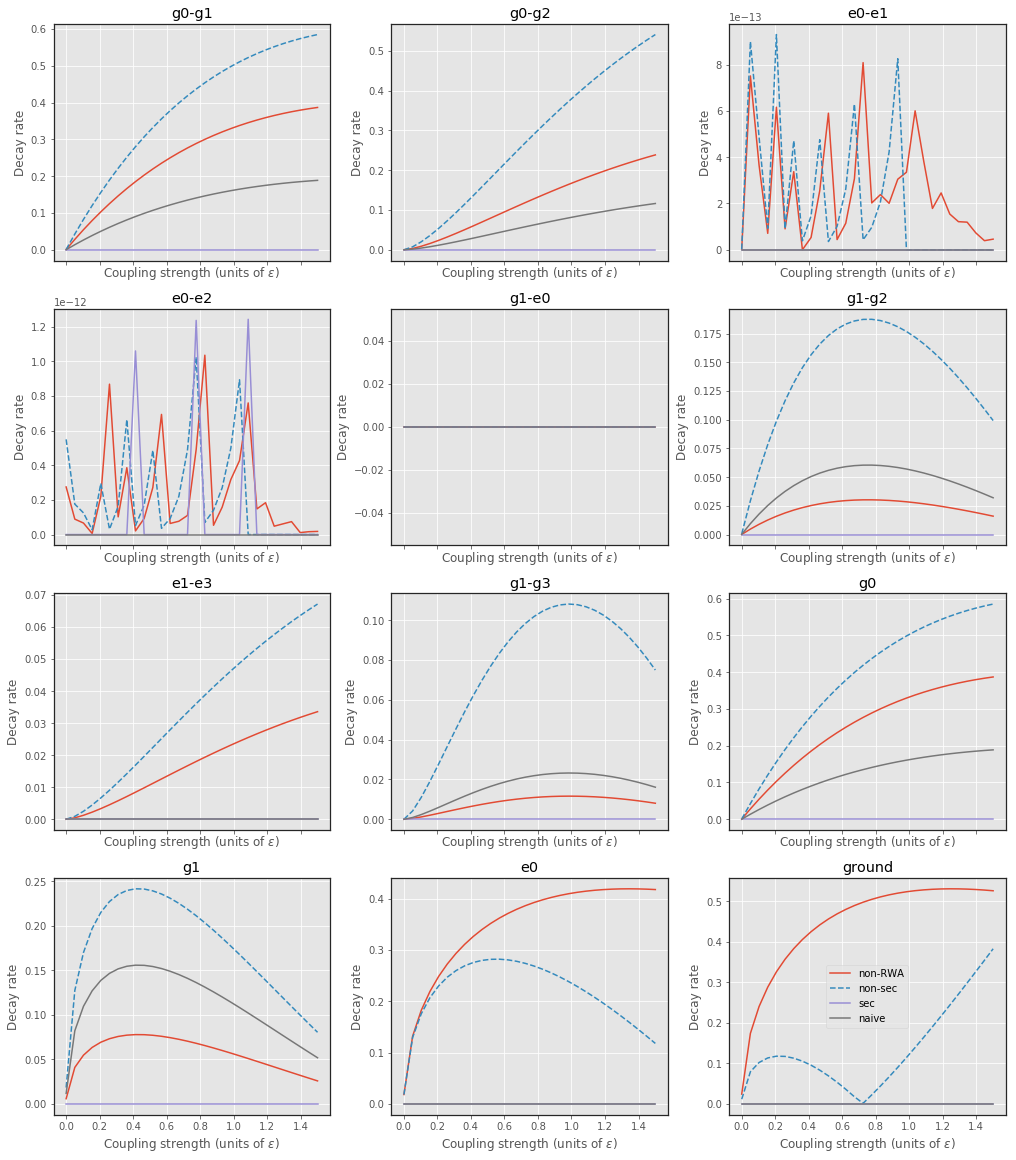

g0-g1 T=6000.
3.33% finished
16.67% finished
33.33% finished
50.00% finished
66.67% finished
83.33% finished
100.00% finished
Initial state is|g;0><g;1|


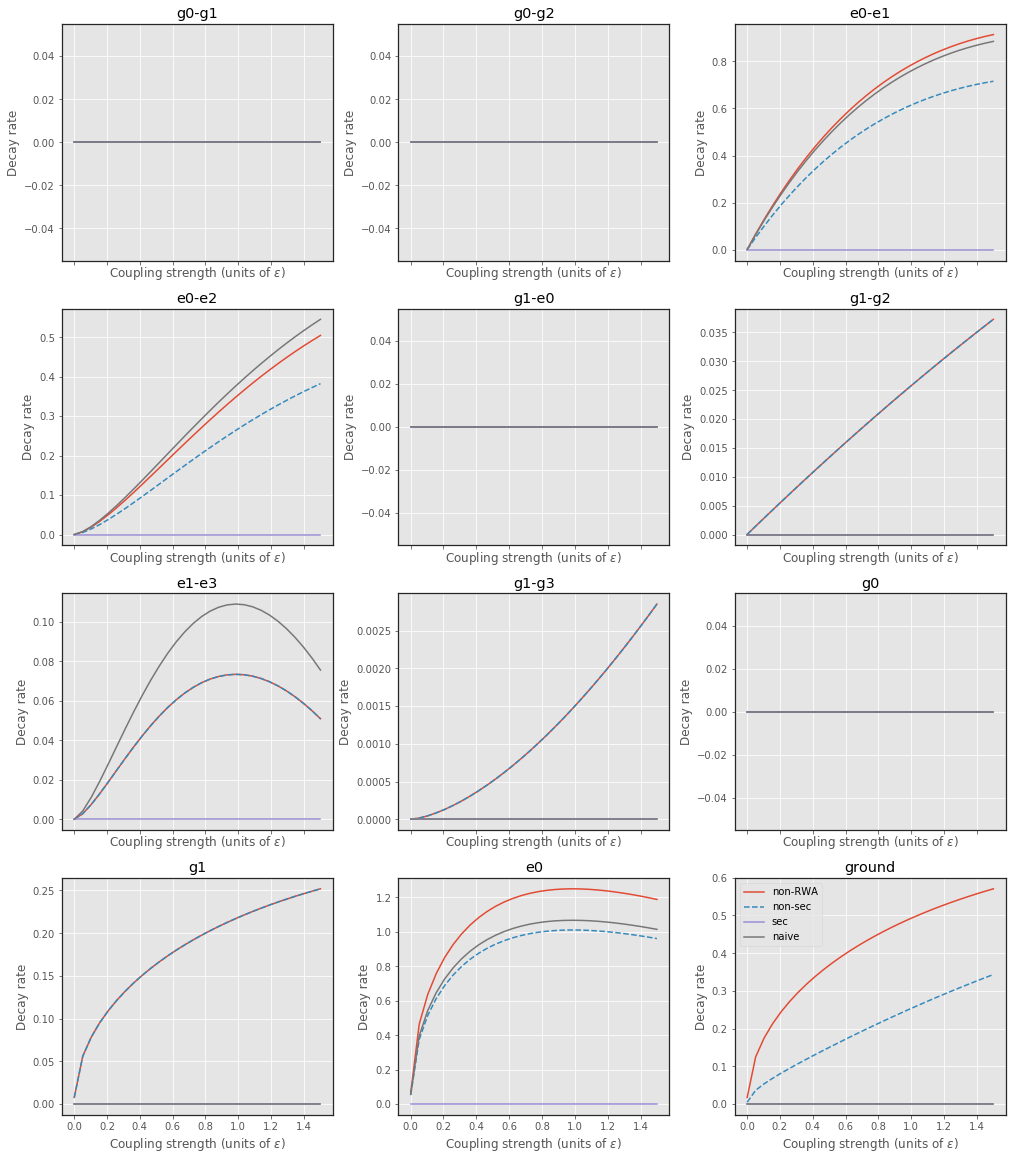

g0-g2 T=6000.
3.33% finished
16.67% finished
33.33% finished
50.00% finished
66.67% finished
83.33% finished
100.00% finished
Initial state is|g;0><g;2|


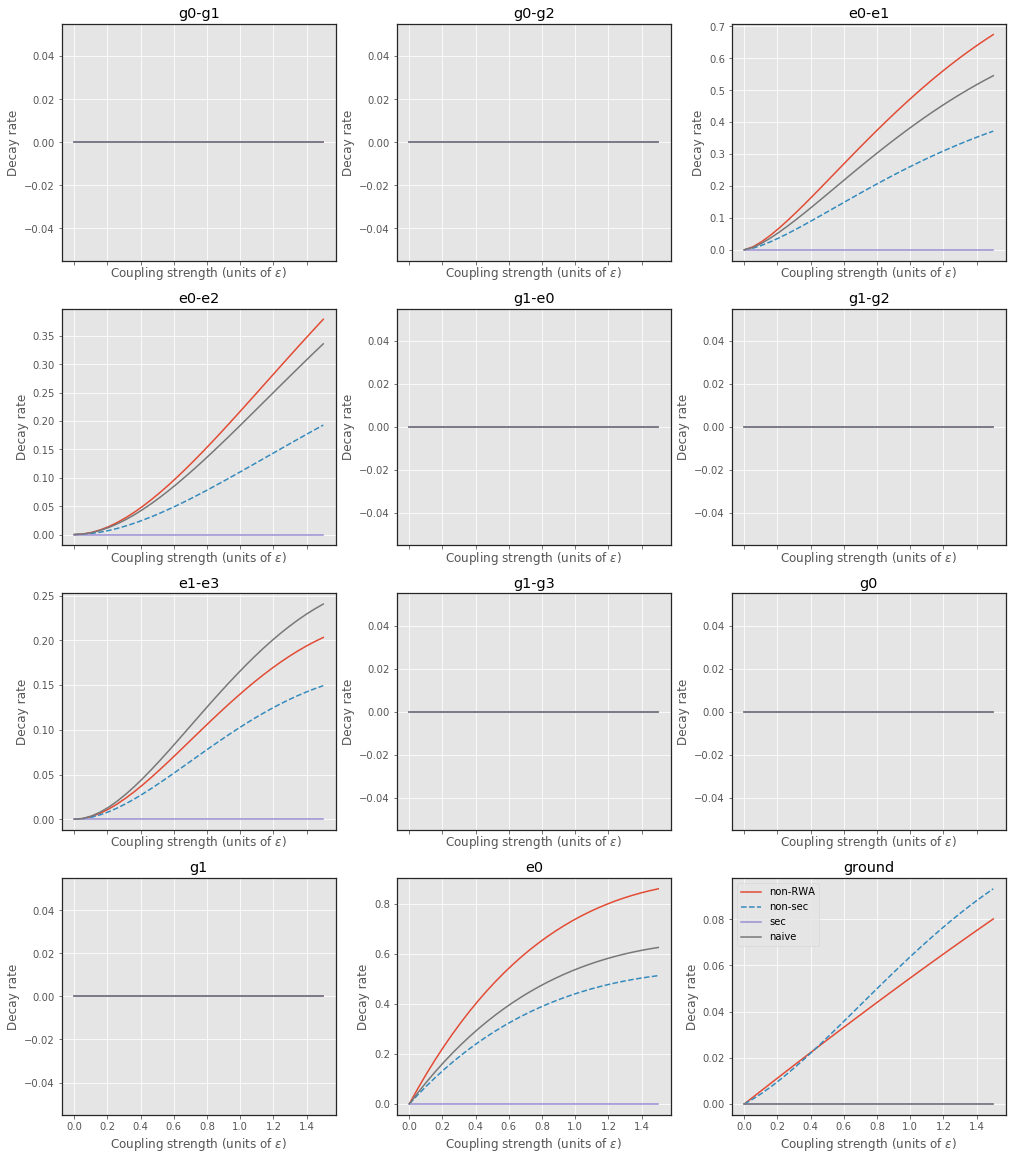

g1-e0 T=6000.
3.33% finished
16.67% finished
33.33% finished
50.00% finished
66.67% finished
83.33% finished
100.00% finished
Initial state is|g;1><e;0|


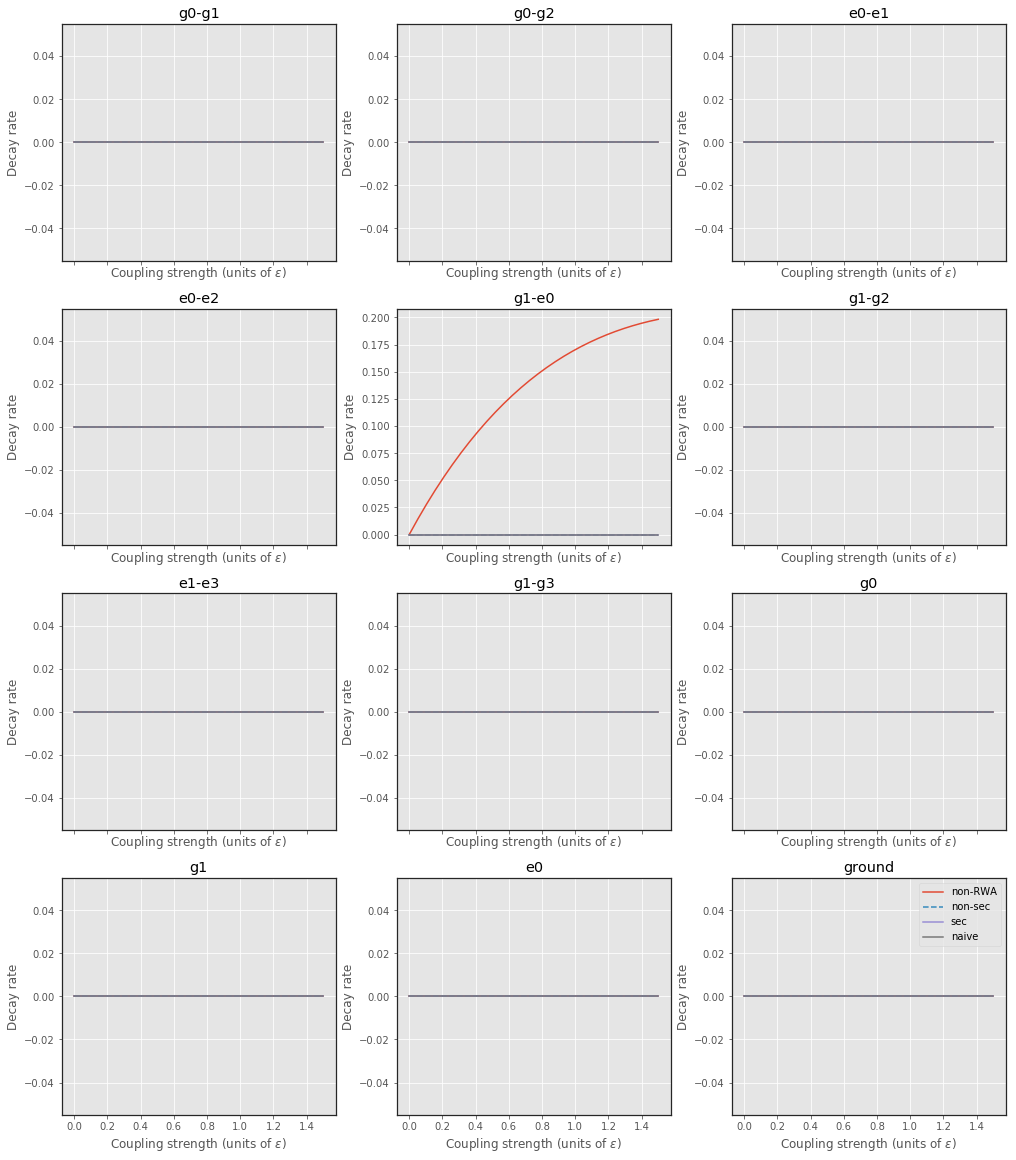

In [20]:
print "e0, T=0."
T_ph = 300.
off_diag_decay_rate_alpha((1,1), (0,0), eps, T_ph,  overdamped=True, T_EM=0.)
print "g0 T=6000"
off_diag_decay_rate_alpha((0,0), (0,0), eps, T_ph,  overdamped=True,  T_EM=6000.)
print "e0-e1 T=0."
off_diag_decay_rate_alpha((1,1), (0,1), eps, T_ph,  overdamped=True,  T_EM=0.)
print "g0-g1 T=6000."
off_diag_decay_rate_alpha((0,0), (0,1), eps, T_ph, overdamped=True, T_EM=6000.)
print "g0-g2 T=6000."
off_diag_decay_rate_alpha((0,0), (0,2), eps, T_ph, overdamped=True, T_EM=6000.)

print "g1-e0 T=6000."
# This initial state is just decoupled from everything apart from the optical field
# only the RWA (it seems) actually describes this.
off_diag_decay_rate_alpha((0,1), (1,0), eps, T_ph,overdamped=True, T_EM=300.)

e1, T=0.
3.33% finished
16.67% finished
33.33% finished
50.00% finished
66.67% finished
83.33% finished
100.00% finished
Initial state is|e;1><e;1|


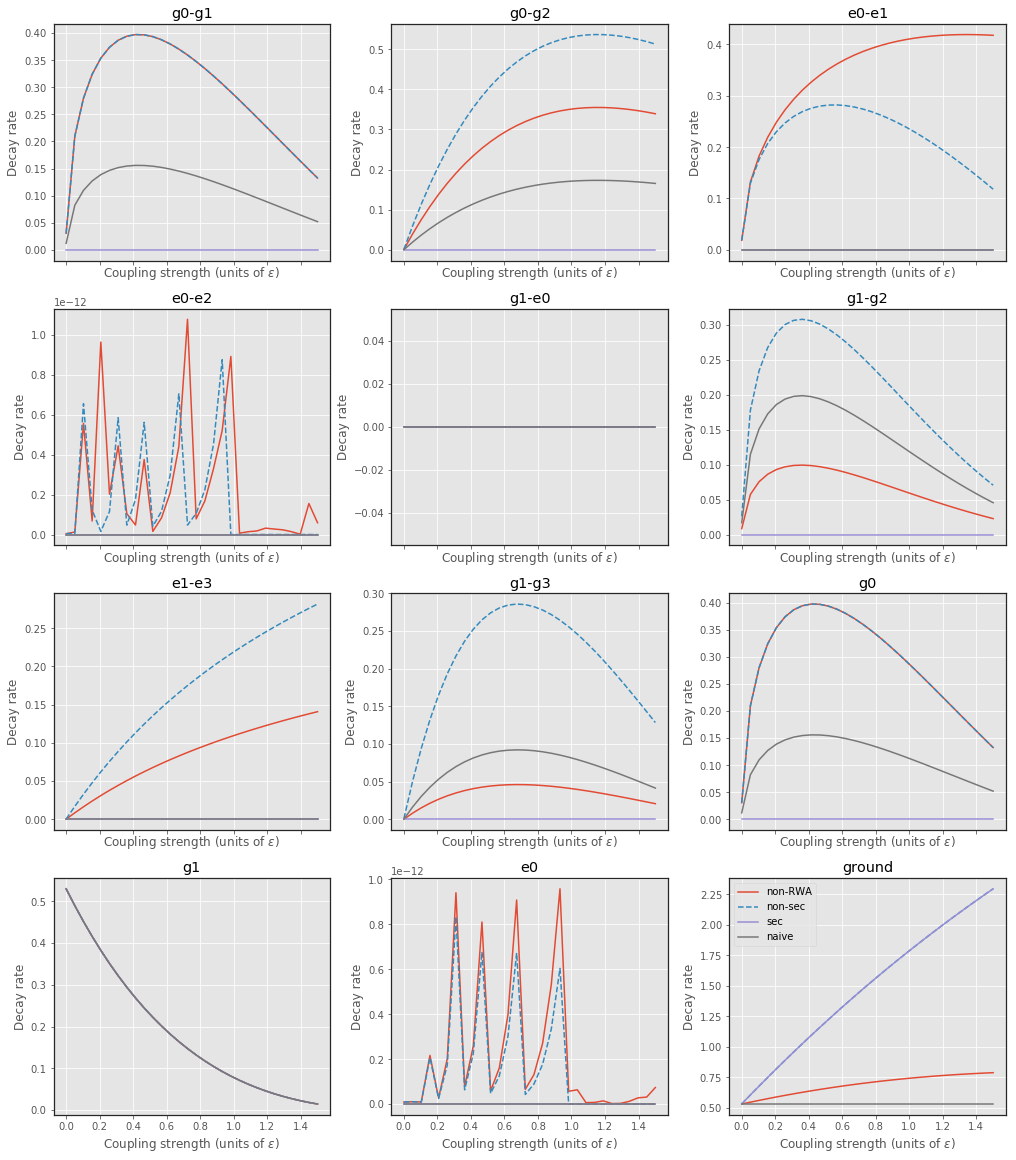

In [21]:
print "e1, T=0."
off_diag_decay_rate_alpha((1,1), (1,1), eps, T_ph, overdamped=True, T_EM=0.)